In [1]:
%load_ext autoreload
%autoreload 2
%config Completer.use_jedi = False

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import h5py
import sys
import corner
import copy
import scipy

from mpl_toolkits.mplot3d import Axes3D
from scipy.special import comb
from astropy import units as u

import analysis
import signals
import estimators
import fitting
import models
import utils

In [463]:
plt.style.use('seaborn-colorblind')
plt.rc('text', usetex=True)
plt.rc('font', family='serif')

colors = plt.rcParams['axes.prop_cycle'].by_key()['color']

## Simulations

In [4]:
box = h5py.File('halos.z8.hdf5', 'r')
box_old = h5py.File('L80_halos_z=6.0155.hdf5', 'r')

In [5]:
masses = np.array(box_old[('mass')])
pos = np.array(box_old[('pos')])
density = np.array(box_old[('rho')])
#x, y, z = pos.T
coords = [*pos.T]

#x = np.array(box[('x')])
#y = np.array(box[('y')])
#z = np.array(box[('z')])

In [6]:
runs = 3
n_bins = 20

In [7]:
box_size = 80.0 # in Mpc
r = np.linspace(0, box_size, 512)
r_vec = np.stack((r, r, r))

In [8]:
mass_voxels, mass_edges = np.histogramdd(coords, bins=512,
                                                weights=masses)

Text(0, 0.5, '$\\frac{dN}{dLog(M)}$')

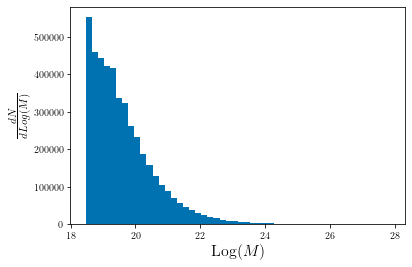

In [9]:
masses_hist = plt.hist(np.log(masses), bins=50)
plt.xlabel(r'Log$(M)$', fontsize=16)
plt.ylabel(r'$\frac{dN}{dLog(M)}$', fontsize=16)

In [10]:
delta = utils.overdensity(density)

In [11]:
#k, P_m = analysis.calc_pspec(r_vec, [delta], n_bins=n_bins, bin_scale='log')

#matter_pspec_results = np.asarray([k_log, density_pspec_log, density_pspec_dimless_log])

In [12]:
#np.savez('matter_pspec', k=k, P_m=P_m)

In [13]:
matter_pspec = np.load('matter_pspec.npz')

In [14]:
matter_pspec.files

['k', 'P_m']

In [15]:
k = matter_pspec['k']
P_m = matter_pspec['P_m']

### Checking power spectrum code with Powerbox

Let's check our power spectrum code to make sure it does what we expect. We'll compare it to the inimitable Steven Murray's Powerbox code.

In [16]:
from powerbox import get_power

p_k_field, bins_field = get_power(delta, box_size,
                                    bins=k, bin_ave=False,
                                    vol_normalised_power=True)

In [17]:
p_k_field_log, bins_field_log = get_power(delta, box_size, log_bins=True, bin_ave=False,
                                    vol_normalised_power=True)

/Users/lisaleemcb/miniconda3/lib/python3.7/site-packages/powerbox/tools.py:106: UserWarning: One or more radial bins had no cells within it.
  warnings.warn("One or more radial bins had no cells within it.")
/Users/lisaleemcb/miniconda3/lib/python3.7/site-packages/powerbox/tools.py:160: RuntimeWarning: invalid value encountered in true_divide
  rl = np.bincount(indx, weights=np.real(field.flatten()), minlength=len(sumweights)+2)[1:-1] / sumweights


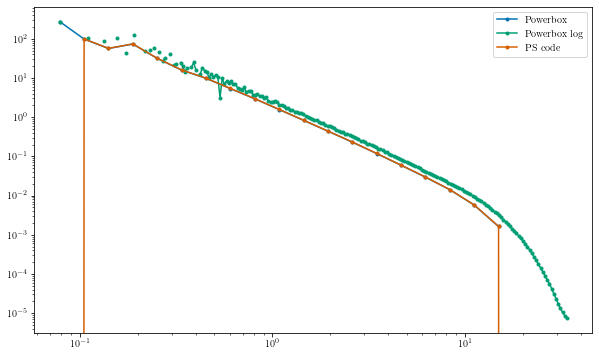

In [18]:
fig = plt.subplots(figsize=(10,6))

plt.plot(bins_field[:-1], p_k_field,label="Powerbox", marker='.')
plt.plot(bins_field_log[:-1], p_k_field_log, label="Powerbox log", marker='.', ls='-')
plt.plot(k, P_m,label="PS code", marker='.')

plt.legend()
plt.xscale('log')
plt.yscale('log')

So our power spectra code is in good agreement with Steven Murray.  A reassuring sign!

### Comparison with CAMB and Powerbox

Now we need to make sure that our spectra our reasonable, compared to known results. Let's compare with the CAMB simulation code.

In [19]:
import sys, platform, os
import camb
from camb import model, initialpower
print('Using CAMB %s installed at %s'%(camb.__version__,os.path.dirname(camb.__file__)))

Using CAMB 1.3.2 installed at /Users/lisaleemcb/miniconda3/lib/python3.7/site-packages/camb


In [20]:
#Set up a new set of parameters for CAMB
pars = camb.CAMBparams()
#This function sets up CosmoMC-like settings, with one massive neutrino and helium set using BBN consistency
pars.set_cosmology(H0=67.5, ombh2=0.022, omch2=0.122, mnu=0.06, omk=0, tau=0.06)
pars.InitPower.set_params(As=2e-9, ns=0.965, r=0)
pars.set_for_lmax(2500, lens_potential_accuracy=0);


In [21]:
#Now get matter power spectra and sigma8 at redshift 0 and 0.8
pars = camb.CAMBparams()
pars.set_cosmology(H0=67.5, ombh2=0.022, omch2=0.122)
pars.InitPower.set_params(ns=0.965)
#Note non-linear corrections couples to smaller scales than you want
pars.set_matter_power(redshifts=[6.0155], kmax=2.0)

#Linear spectra
pars.NonLinear = model.NonLinear_none
results = camb.get_results(pars)
kh, z, pk = results.get_matter_power_spectrum(minkh=bins_field[0], maxkh=bins_field[-5],
                                              npoints=200)
s8 = np.array(results.get_sigma8())

#Non-Linear spectra (Halofit)
pars.NonLinear = model.NonLinear_both
results.calc_power_spectra(pars)
kh_nonlin, z_nonlin, pk_nonlin = results.get_matter_power_spectrum(minkh=bins_field[0],
                                                                   maxkh=bins_field[-5],
                                                                   npoints = 200)


In [22]:
#calculate results for these parameters
results = camb.get_results(pars)

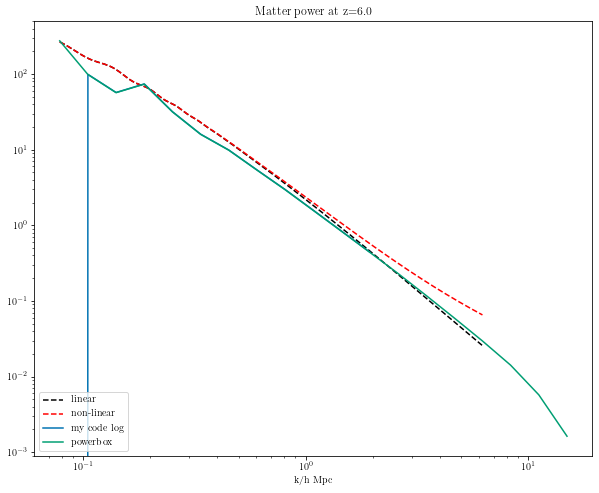

In [23]:
#for i, (redshift, line) in enumerate(zip(z,['-','--'])):
fig = plt.figure()

fig.set_figheight(8)
fig.set_figwidth(10)

plt.loglog(kh, pk[0,:], color='k', ls='--')
plt.loglog(kh_nonlin, pk_nonlin[0,:], color='r', ls='--')
    
#plt.loglog(k_log, density_pspec_log)
plt.loglog(k[0:12], P_m[0:12])
plt.loglog(bins_field[:-1], p_k_field)

plt.xlabel('k/h Mpc');
plt.legend(['linear','non-linear', 'my code log', 'powerbox'], loc='lower left');
plt.title('Matter power at z=6.0');

### Simulating the 21cm brightness temperature field

We also want to cross-correlate our intensities with the 21cm field.  In order to simulate it, we use Paul La Plante's 'quick and dirty' simulation code package <\code zreion>.

In [24]:
import h5py

from zreion import apply_zreion_fast
from astropy.cosmology import Planck15

In [25]:
# parameters
box = 80.0  # Mpc/h
omegam = Planck15.Om0
omegab = Planck15.Ob0
hubble0 = Planck15.H0

alpha = 0.564
k_0 = 0.185 # Mpc/h

# global temperature as a function of redshift
def t0(z):
    return 38.6 * hubble0.value * (omegab / 0.045) * np.sqrt(0.27 / omegam * (1 + z) / 10)

In [26]:
def gen_21cm_fields(delta, box= 80.0, zmean=7, alpha=0.11, k0=0.05):
    # compute zreion field
    print("computing zreion...")
    zreion = apply_zreion_fast(delta, zmean, alpha, k0, box, deconvolve=False)
    
    return zreion

def get_21cm_fields(z, zreion, delta):
    #print("computing t21 at z=", z, "...")
    ion_field = np.where(zreion > z, 1.0, 0.0)
    t21_field = t0(z) * (1 + delta) * (1 - ion_field)
    
    return ion_field, t21_field

In [27]:
zreion = gen_21cm_fields(delta)

computing zreion...


In [28]:
ion_field, t21_field = get_21cm_fields(7, zreion, delta)

In [29]:
zreion1 = gen_21cm_fields(delta, alpha = 0.05, k0 = 0.3)
zreion2 = gen_21cm_fields(delta, alpha = 0.11, k0 = 0.05)
zreion3 = gen_21cm_fields(delta, alpha = 0.15, k0 = 0.1)
zreion4 = gen_21cm_fields(delta, alpha = 0.25, k0 = 0.07)
zreion5 = gen_21cm_fields(delta, alpha = alpha, k0 = k_0)

computing zreion...
computing zreion...
computing zreion...
computing zreion...
computing zreion...


In [30]:
redshifts = np.linspace(5,15)

def create_reion_history(redshifts, zreion, delta):
    neutral_frac = np.zeros_like(redshifts)
    for i, z in enumerate(redshifts):
        ion_field, t21_field = get_21cm_fields(z, zreion, delta)
        ion_frac = ion_field.sum() / 512**3
        neutral_frac[i] = 1 - ion_frac
        
    return neutral_frac

In [31]:
neutral_frac1 = create_reion_history(redshifts, zreion1, delta)
neutral_frac2 = create_reion_history(redshifts, zreion2, delta)
neutral_frac3 = create_reion_history(redshifts, zreion3, delta)
neutral_frac4 = create_reion_history(redshifts, zreion4, delta)
neutral_frac5 = create_reion_history(redshifts, zreion5, delta)

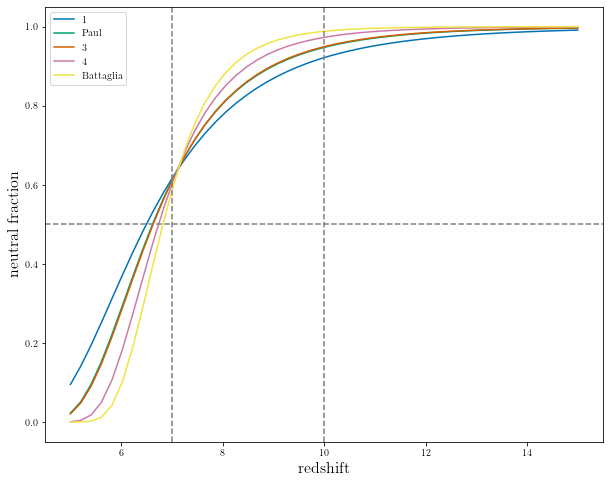

In [32]:
fig = plt.figure(figsize=(10,8))

plt.plot(redshifts, neutral_frac1, label='1')
plt.plot(redshifts, neutral_frac2, label='Paul')
plt.plot(redshifts, neutral_frac3, label='3')
plt.plot(redshifts, neutral_frac4, label='4')
plt.plot(redshifts, neutral_frac5, label='Battaglia')

plt.axhline(.5, color='gray', ls='--')
plt.axvline(7, color='gray', ls='--')
plt.axvline(10, color='gray', ls='--')

plt.xlabel('redshift', fontsize=16)
plt.ylabel('neutral fraction', fontsize=16)

plt.legend()

In [33]:
redshifts = np.linspace(5,15)

neutral_frac = np.zeros_like(redshifts)

for i, z in enumerate(redshifts):
    ion_field, t21_field = get_21cm_fields(z, zreion, delta)
    ion_frac = ion_field.sum() / 512**3
    neutral_frac[i] = 1 - ion_frac

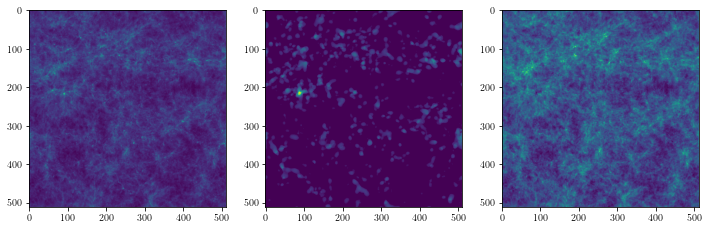

In [34]:
from matplotlib.colors import LogNorm

fig, ax = plt.subplots(1,3, figsize=(12,8))

ax[0].imshow(delta.sum(axis=2))
ax[1].imshow(ion_field.sum(axis=2))
ax[2].imshow(t21_field.sum(axis=2))

### Checking normalisation of luminosity functions 

Next we are going to need to generate some simulated specific intensities from our box our halos. This is done by 'painting' a luminosity onto the halos using a power law prescription,

$$
L(M) = L_0 \left( \frac{M}{M_0} \right)^{\alpha}
$$

Let's plot this relation for our collection our halos,

In [35]:
import astropy.constants as const

In [36]:
H_I_power = 1.3

z = 6.0

L = 2.0 / 3.0
M = 1.0
H = 4.0 / 3.0

power_indices = [H_I_power, L, M]

L_solar=3.828e26
L_CII = 10e6
L_OIII = 10e9

luminosities_L = utils.mass2luminosity(masses, power=L)
luminosities_M = utils.mass2luminosity(masses, power=M)
luminosities_H = utils.mass2luminosity(masses, power=H)

intensities_L = utils.specific_intensity(z, L=luminosities_L)
intensities_M = utils.specific_intensity(z, L=luminosities_M)
intensities_H = utils.specific_intensity(z, L=luminosities_H)

Text(0, 0.5, 'luminosities')

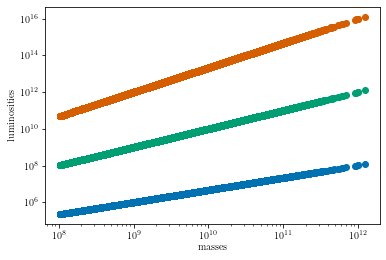

In [37]:
fig, ax = plt.subplots()

ax.scatter(masses, luminosities_L)
ax.scatter(masses, luminosities_M)
ax.scatter(masses, luminosities_H)
ax.set_xscale('log')
ax.set_yscale('log')

ax.set_xlabel('masses')
ax.set_ylabel('luminosities')

In [38]:
np.mean(intensities_L), np.mean(intensities_M), np.mean(intensities_H)

(<Quantity 0.35125622 Jy / sr>,
 <Quantity 389.09235634 Jy / sr>,
 <Quantity 631680.50596367 Jy / sr>)

#### Checking unit conversion

Intensities are often given in units of Janskies.  Let's make sure that we are converting correctly from one to the other, and they are comparable to the Lidz and Beane result (https://arxiv.org/pdf/1806.02796.pdf)

In [39]:
print('Lidz: ', 3.1e2,
      ' My code: ', utils.specific_intensity(9.41))
print('Lidz: ', 7.1e2,
      ' My code: ', utils.specific_intensity(7.37))
print('Lidz: ', 1.1e3,
      'My code: ', utils.specific_intensity(6.43))

Lidz:  310.0  My code:  296.85416094619967 Jy / sr
Lidz:  710.0  My code:  675.7372227764706 Jy / sr
Lidz:  1100.0 My code:  1065.0564106095567 Jy / sr


In [40]:
def gen_spectra(fields): 

    lines_indices = np.zeros((int(comb(runs, 2) + runs), 2))
    pspecs = np.zeros((int(comb(runs, 2) + runs), n_bins))
    pspecs_dim = np.zeros((int(comb(runs, 2) + runs), n_bins))
    
    counter = 0
    for i in range(runs):
        for j in range(i, runs):
            print('Calculating correlation for Lines', i, ' and ', j)
            print('with power indices')
            k, pspec, pspec_dim = analysis.pspec(r_vec,
                            [fields[i], fields[j]],
                            n_bins=n_bins, bin_scale='log')

            pspecs[counter] = pspec
            pspecs_dim[counter] = pspec_dim

            lines_indices[counter,0] = i 
            lines_indices[counter,1] = j

            counter += 1
            
    return k, pspecs, pspecs_dim

In [41]:
indices = utils.lines_indices()
indices

array([[0., 0.],
       [0., 1.],
       [0., 2.],
       [1., 1.],
       [1., 2.],
       [2., 2.]])

In [42]:
# shot_0 = 80**3 * a_0 * I_0.mean()**2 / len(masses) 
# shot_1 = 80**3 * a_1 * I_1.mean()**2 / len(masses) 
# shot_2 = 80**3 * a_2 * I_2.mean()**2 / len(masses)

In [43]:
I_fields_old = np.zeros((runs, 512, 512, 512))
scalings_old = [0.000581, 10**5, 60]

for i, power in enumerate(power_indices):
    print('power =', power)
    intensities = utils.specific_intensity(z,
                            L=scalings_old[i] * utils.mass2luminosity(masses, power=power, mass_0=1.0))

    print('mean intensity = ', intensities.mean())
    print(' ')
    # lumens += np.random.lognormal(mean=0.0, sigma=2.0, size=None)
    I_voxels, I_edges = np.histogramdd(coords, bins=512, weights=intensities)
    I_fields_old[i] = I_voxels

power = 1.3
mean intensity =  171.7529671626317 Jy / sr
 
power = 0.6666666666666666
mean intensity =  35125.62161645958 Jy / sr
 
power = 1.0
mean intensity =  23345.54138022396 Jy / sr
 


In [44]:
I_fields = np.zeros((runs, 512, 512, 512))
scalings = [1, 10**5, 60]

for i, power in enumerate(power_indices):
    print('power =', power)
    intensities = utils.specific_intensity(z,
                            L=scalings[i] * utils.mass2luminosity(masses, power=power, mass_0=1.0))

    print('mean intensity = ', intensities.mean())
    print(' ')
    # lumens += np.random.lognormal(mean=0.0, sigma=2.0, size=None)
    I_voxels, I_edges = np.histogramdd(coords, bins=512, weights=intensities)
    I_fields[i] = I_voxels

power = 1.3
mean intensity =  295616.1224830153 Jy / sr
 
power = 0.6666666666666666
mean intensity =  35125.62161645958 Jy / sr
 
power = 1.0
mean intensity =  23345.54138022396 Jy / sr
 


power= 1.3
mean=  525384632064.2446 solLum
power= 0.6666666666666666
mean=  197411872.38227138 solLum
power= 1.0
mean=  5356456389.954758 solLum


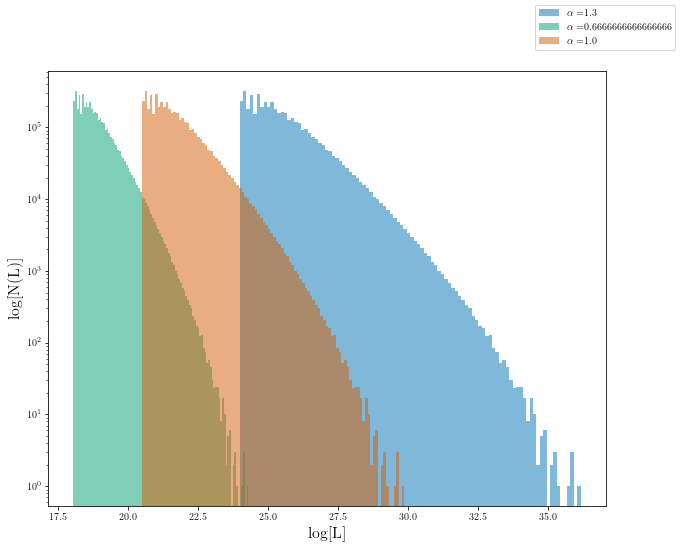

In [45]:
fig, ax = plt.subplots(figsize=(10,8))

for i, power in enumerate(power_indices):
    print('power=', power)
    lumens = np.sqrt(scalings[i]) * utils.mass2luminosity(masses, power=power, mass_0=1.0)
    print('mean= ', lumens.mean())
    n, bins, _ = ax.hist(np.log(lumens.value), 100, alpha = 0.5, lw=3, log=True, label=r'$\alpha=$' + str(power))
    
ax.set_xlabel(r'log[L]', fontsize=16)
ax.set_ylabel(r'log[N(L)]', fontsize=16)

fig.legend()

    
    # print('shot noise for index, alpha=', power, ': is ', integral)
    

In [46]:
def set_I_mean(Lidz_pspec_log, P_x):
    return np.sqrt(Lidz_pspec_log / P_x)

The shot noise can be roughly approximated as such. Since the shot noise is due to number of sources, we expect the shot noise to increase with decreasing number density.  If we assume it scales inversely, then this is roughly,
$$
\sigma_{\text{shot}} \propto \frac{1}{\bar{n}} = \frac{V}{N}
$$
The dimensions of the power spectrum are,
$$
[\text{field}^2][V]
$$
To be consistent dimensionally, we multiply by the mean of the field (in our case, $T$),
$$
\sigma_{\text{shot}} \sim \frac{{<\tilde{T}^2>} V}{N}
$$

In [47]:
#shot_0, shot_1, shot_2

### Generate spectra

Now that we have our 21cm brightness temperature field, we can go ahead and calculate our spectra.

In [48]:
#spectra_old = analysis.gen_spectra(r_vec, I_fields_old)

In [49]:
indices

array([[0., 0.],
       [0., 1.],
       [0., 2.],
       [1., 1.],
       [1., 2.],
       [2., 2.]])

In [50]:
#I_fields[0] = t21_field
#spectra = analysis.gen_spectra(r_vec, I_fields)

In [51]:
#np.savez('p_specs', P_21cm_21cm=spectra[1][0], P_21cm_CII=spectra[1][1],
#                    P_21cm_OIII=spectra[1][2], P_CII_CII=spectra[1][3],
#                    P_CII_OIII=spectra[1][4], P_OIII_OIII=spectra[1][5])

In [52]:
p_specs = np.load('p_specs.npz')
p_specs.files

['P_21cm_21cm',
 'P_21cm_CII',
 'P_21cm_OIII',
 'P_CII_CII',
 'P_CII_OIII',
 'P_OIII_OIII']

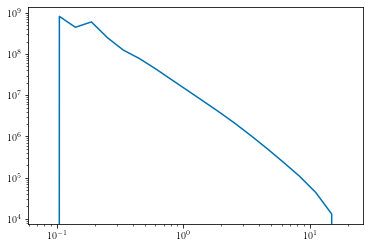

In [53]:
plt.loglog(k, p_specs['P_21cm_21cm'])

In [54]:
indices

array([[0., 0.],
       [0., 1.],
       [0., 2.],
       [1., 1.],
       [1., 2.],
       [2., 2.]])

In [55]:
spectra = (k, [p_specs['P_21cm_21cm'], p_specs['P_21cm_CII'],
               p_specs['P_21cm_OIII'], p_specs['P_CII_CII'],
               p_specs['P_CII_OIII'], p_specs['P_OIII_OIII']])

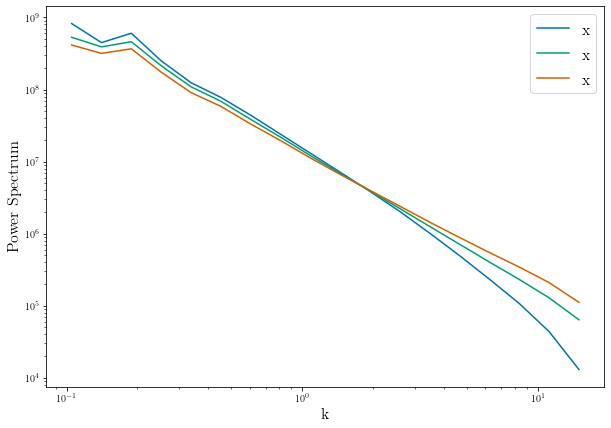

In [56]:
fig, ax = plt.subplots()

fig.set_figheight(7)
fig.set_figwidth(10)

line_labels = ['P_21cm_21cm', 'P_21cm_CII', 'P_21cm_OIII']

for label in line_labels:
#ax.axvline(k[9], color='black', ls='--', alpha=.2)

#plt.loglog(k, Lidz_pspec_log, label='Lidz log')
    #legend_label = r*label

    plt.loglog(k[1:-1], p_specs[label][1:-1], marker='None',
            label=r'x')

#plt.loglog(k[1:-1], spectra[label[1:-1], marker='None',
#        label=r'{} x {} '.format(line_labels[int(indices[3][0])],
#                                                       line_labels[int(indices[3][1])]))

#plt.loglog(k[1:-1], spectra[1][5][1:-1], marker='None',
#        label=r'{} x {} '.format(line_labels[int(indices[5][0])],
#                                                       line_labels[int(indices[5][1])]))


plt.xlabel('k',fontsize=16)
plt.ylabel('Power Spectrum', fontsize=16)

plt.legend(fontsize=16)

Let's plot the power spectrum, $P(k)$,

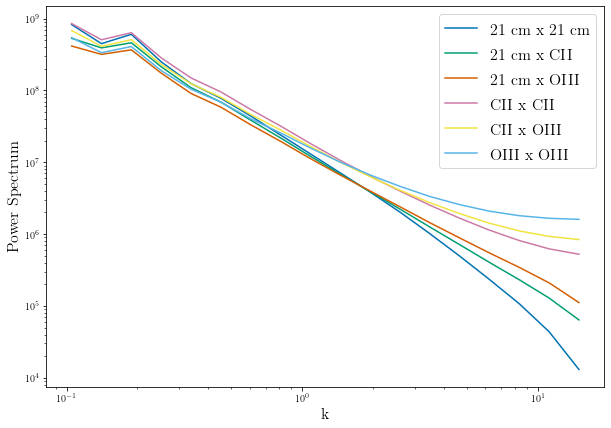

In [57]:
fig, ax = plt.subplots()

fig.set_figheight(7)
fig.set_figwidth(10)

line_labels = [r'21 cm', r'CII', r'OIII']

#ax.axvline(k_log[9], color='black', ls='--', alpha=.2)

#plt.loglog(k_log, Lidz_pspec_log, label='Lidz log')

for i in range(len(spectra[1])):
    plt.loglog(k[1:-1], spectra[1][i][1:-1], marker='None',
        label=r'{} x {} '.format(line_labels[int(indices[i][0])],
                                                       line_labels[int(indices[i][1])]))

plt.xlabel('k',fontsize=16)
plt.ylabel('Power Spectrum', fontsize=16)

plt.legend(fontsize=16)

and the dimensionless power spectrum, $\Delta(k)$,

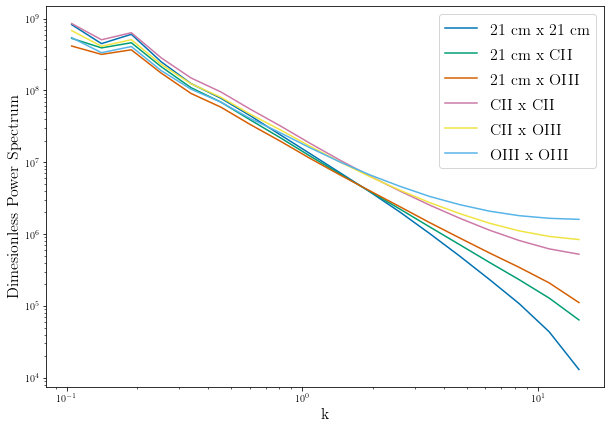

In [58]:
fig, ax = plt.subplots()

fig.set_figheight(7)
fig.set_figwidth(10)

line_labels = [r'21 cm', r'CII', r'OIII']

#ax.axvline(k_log[9], color='black', ls='--', alpha=.2)

#plt.loglog(k_log, Lidz_pspec_log, label='Lidz log')

for i in range(len(spectra[1])):
    plt.loglog(k[1:-1], spectra[1][i][1:-1], marker='None',
        label=r'{} x {} '.format(line_labels[int(indices[i][0])],
                                                       line_labels[int(indices[i][1])]))

plt.xlabel('k',fontsize=16)
plt.ylabel('Dimesionless Power Spectrum', fontsize=16)


plt.legend(fontsize=16)

### Comparing amplitudes with Lidz et al.

We want to make sure that our spectra are reasonable.

#### Autocorrelations

In [59]:
P_21cm_21cm = spectra[1][0] * u.Mpc**3 * u.Jy**2 * u.steradian**(-2)
P_CII_CII = spectra[1][3] * u.Mpc**3 * u.Jy**2 * u.steradian**(-2)
P_OIII_OIII = spectra[1][5] * u.Mpc**3 * u.Jy**2 * u.steradian**(-2)

#### Crosscorrelations 

In [60]:
P_21cm_CII = spectra[1][1] * u.Mpc**3 * u.Jy**2 * u.steradian**(-2)
P_21cm_OIII = spectra[1][2] * u.Mpc**3 * u.Jy**2 * u.steradian**(-2)
P_CII_OIII = spectra[1][4] * u.Mpc**3 * u.Jy**2 * u.steradian**(-2)

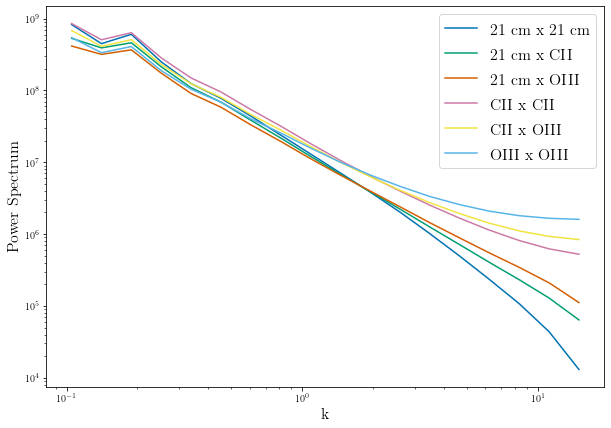

In [61]:
fig, ax = plt.subplots()

fig.set_figheight(7)
fig.set_figwidth(10)

line_labels = [r'21 cm', r'CII', r'OIII']

#ax.axvline(k_log[9], color='black', ls='--', alpha=.2)

#plt.loglog(k_log, Lidz_pspec_log, label='Lidz log')

for i in range(len(spectra[1])):
    plt.loglog(k[1:-1], spectra[1][i][1:-1], marker='None',
        label=r'{} x {} '.format(line_labels[int(indices[i][0])],
                                                       line_labels[int(indices[i][1])]))

plt.xlabel('k',fontsize=16)
plt.ylabel('Power Spectrum', fontsize=16)

plt.legend(fontsize=16)

# Surveys

In [62]:
z = 7

test with different values of the power index, alpha

In [63]:
def error_bars(P_x, P_line1, P_line2, P_N, W_k, N_modes):
    sigma = (1 / np.sqrt(N_modes)) * np.sqrt(P_x**2 
                                            + P_line1 * (P_line2 + P_N / W_k**2))
    return sigma

def var_x(P_i, W_i, P_j, W_j, P_Ni, P_Nj, P_x, N_modes):
    W_x = np.sqrt(W_i * W_j)
    
    return ((P_i * W_i + P_Ni) * (P_j * W_j + P_Nj) + P_x**2 * W_x**2) / (2 * N_modes)
    
def var_auto(P_i, W_i, P_N, N_modes):
    return (P_i * W_i + P_N)**2 / N_modes

def calc_N_modes(k, V_surv, align='center'):
    
    k_vals = np.zeros(len(k) - 1)    
    delta_k = k[1:] - k[:-1] 

    if align is 'left':
        k_vals = k[:-1]

    if align is 'center':
        k_vals = (k[1:] + k[:-1]) / 2 

    if align is 'right':
        k_vals = k[1:]

    N_modes = k_vals**2 * delta_k * V_surv.to_value() / (4 * np.pi**2)

    return N_modes

def calc_P_N(sigma_pix, V_vox, t_pix):
    P_N = sigma_pix**2 * V_vox / t_pix
    
    return P_N

def calc_t_pix(N_det, t_obs, Omega_surv, sigma_beam):
    Omega_pix = 2 * np.pi * sigma_beam**2
    
    t_pix = N_det * t_obs / (Omega_surv / Omega_pix) 
    
    return t_pix.to(u.s, equivalencies=u.dimensionless_angles())

def calc_L_perp(z, Omega):
    # This assumes a square survey   
    return np.sqrt(Planck15.comoving_distance(z)**2 \
            * Omega).to(u.Mpc, equivalencies=u.dimensionless_angles()) * Planck15.h

def calc_L_para(z, nu_rest, delta_nu):
    return ((const.c / Planck15.H(z)) * delta_nu * (1 + z)**2 / \
            nu_rest).to(u.Mpc) * Planck15.h

def calc_V(z, width_perp, width_para, nu_rest):
    L_perp = calc_L_perp(z, width_perp)
    L_para = calc_L_para(z, nu_rest, width_para)
    
    return L_perp**2 * L_para

def calc_V_vox(z, sigma_beam, delta_nu, nu_rest):
    Omega_beam = sigma_beam**2
    V_vox = calc_V(z, Omega_beam, delta_nu, nu_rest)
    
    return V_vox

def calc_V_survey(z, Omega_surv, B_nu, nu_rest):
    V_survey = calc_V(z, Omega_surv, B_nu, nu_rest)
    
    return V_survey

def calc_V_surv_generic(z,lambda_rest, Omega_surv, B_nu):
    A_s = Omega_surv  
    B_nu = B_nu
    r = Planck15.comoving_distance(z)
    y = (lambda_rest * (1 + z)**2) / Planck15.H(z)

    V = r**2 * y * A_s * B_nu * Planck15.h**3
    
    return V.to(u.Mpc**3, equivalencies=u.dimensionless_angles())

def calc_V_surv_ij(z, lambda_i, Omega_surv_j, B_nu_j):
    # units in nanometers, GHz
    A = 3.3e7 * u.Mpc**3 # just a random prefactor (Mpc / h)^3
    V_surv_ij = A * (lambda_i / (158 * u.micron)) * np.sqrt((1 + z) / 8) \
                    * (Omega_surv_j / (16 * u.degree**2)) * (B_nu_j / (20 * u.GHz))

    return V_surv_ij.decompose().to(u.Mpc**3)

### Checking the resolution of the instrument

The maximum resolvable $k$ of the instrument is set by the size of the survey volume. This is roughly,
$$
V \approx R(z)^2\Omega \left[ \frac{c}{H(z)} \frac{B_{\nu} (1+z)^2}{\nu_{\text{rest}}} \right]
$$
Where the term $\sqrt{R(z)^2 \Omega}$ sets the minimum $k_{\perp}$ and $\left[ \frac{c}{H(z)} \frac{B_{\nu} (1+z)^2}{\nu_{\text{rest}}} \right]$ sets the minimum $k_{\parallel}$.

Then the maximum resolution is,
$$k_{\text{max}} = \sqrt{2 k_{\perp, \text{max}}^2 + k_{\parallel, \text{max}}^2} \\
= \sqrt{\left( \frac{4 \pi}{\sqrt{R(z)^2 \Omega}} \right)^2 + \left(\frac{2 \pi}{\left[ \frac{c}{H(z)} \frac{B_{\nu} (1+z)^2}{\nu_{\text{rest}}} \right]}\right)^2 }
$$

### Survey specifications

We now want to construct three surveys that have the same coverage in 2D k-space, such that we can perform cross correlations. We want three different lines, corresponding to 21 cm, CII, and OIII.

In [64]:
def calc_L_perp(z, Omega):
    # This assumes a square survey   
    return np.sqrt(Planck15.comoving_distance(z)**2 \
            * Omega).to(u.Mpc, equivalencies=u.dimensionless_angles()) * Planck15.h

def calc_L_para(z, nu_rest, delta_nu):
    return ((const.c / Planck15.H(z)) * delta_nu * (1 + z)**2 / \
            nu_rest).to(u.Mpc) * Planck15.h

def set_L_perp(k_perp_min, z):
    R_z = Planck15.comoving_distance(z) * Planck15.h
    Omega_surv = ((2 * np.pi)**2 / (k_perp_min * R_z)**2) * u.radian**2

    return Omega_surv.to(u.degree**2)

def set_L_para(k_para_min, z, nu_rest):
    B_nu = (2 * np.pi * Planck15.H(z) * nu_rest) / \
            (const.c * k_para_min * (1 + z)**2) * Planck15.h
    
    return B_nu
    

In [65]:
k_units = k * u.Mpc**(-1)

# max and min k values are partially determined by the simulation box size
k_perp_min_box = (2 * np.pi) / (box_size * u.Mpc)
k_para_min_box = (2 * np.pi) / (box_size * u.Mpc)

k_perp_max_box = (2 * np.pi) / ((box_size * u.Mpc) / 512)
k_para_max_box = (2 * np.pi) / ((box_size * u.Mpc) / 512)

In [66]:
nu_21cm = 1420.4 * u.MHz
nu_21cm_obs = utils.calc_nu_obs(nu_21cm, z)

lambda_21cm = utils.nu_to_wavelength(nu_21cm)

In [67]:
nu_CII = 1.9 * u.THz
nu_CII_obs = utils.calc_nu_obs(nu_CII, z)

lambda_CII = utils.nu_to_wavelength(nu_CII).to(u.micron) # micrometers

In [68]:
lambda_OIII = 88 * u.micron ## micrometers

nu_OIII = utils.wavelength_to_nu(lambda_OIII)
nu_OIII_obs = utils.calc_nu_obs(nu_OIII, z)

In [69]:
set_L_perp(k_perp_min_box, z)

<Quantity 0.58823598 deg2>

In [70]:
sigma_beam = 1.22 * lambda_CII / (3 * u.m)

Omega_surv_21cm = set_L_perp(k_perp_min_box, z)
Omega_surv_CII = set_L_perp(k_perp_min_box, z)
Omega_surv_OIII = set_L_perp(k_perp_min_box, z)

B_21cm = set_L_para(k_para_min_box, z, nu_21cm)
B_CII = set_L_para(k_para_min_box, z, nu_CII)
B_OIII = set_L_para(k_para_min_box, z, nu_OIII)

In [71]:
sigma_perp_21cm = utils.calc_sigma_perp(z, sigma_beam)
sigma_perp_CII = utils.calc_sigma_perp(z, sigma_beam)
sigma_perp_OIII = utils.calc_sigma_perp(z, sigma_beam)

In [72]:
delta_nu_CII = 10 * u.MHz
sigma_para_CII = utils.calc_sigma_para(z, nu_CII_obs, delta_nu_CII)

delta_nu_21cm = utils.set_sigma_para(sigma_para_CII, z, nu_21cm_obs)
sigma_para_21cm = utils.calc_sigma_para(z, nu_21cm_obs, delta_nu_21cm)

delta_nu_OIII = utils.set_sigma_para(sigma_para_CII, z, nu_OIII_obs)
sigma_para_OIII = utils.calc_sigma_para(z, nu_OIII_obs, delta_nu_OIII)

In [73]:
print(delta_nu_21cm.to(u.kHz))
print(delta_nu_CII.to(u.MHz))
print(delta_nu_OIII.to(u.MHz))

7.47578947368421 kHz
10.0 MHz
17.930170933014352 MHz


In [74]:
L_perp_21cm = calc_L_perp(z, Omega_surv_21cm)
L_para_21cm = calc_L_para(z, nu_21cm, B_21cm)

L_perp_CII = calc_L_perp(z, Omega_surv_CII)
L_para_CII = calc_L_para(z, nu_CII, B_CII)

L_perp_OIII = calc_L_perp(z, Omega_surv_OIII)
L_para_OIII = calc_L_para(z, nu_OIII, B_OIII)

In [75]:
k_perp_min_21cm = (2 * np.pi / L_perp_21cm)
k_perp_min_CII = (2 * np.pi / L_perp_CII)
k_perp_min_OIII = (2 * np.pi / L_perp_OIII)

k_para_min_21cm = (2 * np.pi / L_para_21cm)
k_para_min_CII = (2 * np.pi / L_para_CII)
k_para_min_OIII = (2 * np.pi / L_para_OIII)

k_perp_max_21cm = 1 / sigma_perp_21cm
k_perp_max_CII = 1 / sigma_perp_CII
k_perp_max_OIII = 1 / sigma_perp_OIII

k_para_max_21cm = 1 / sigma_para_21cm
k_para_max_CII = 1 / sigma_para_CII
k_para_max_OIII = 1 / sigma_para_OIII

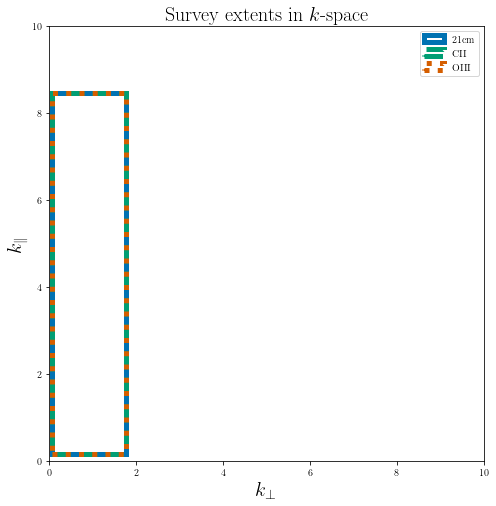

In [76]:
import matplotlib.patches as patches

fig, ax = plt.subplots(1,1, figsize=(8, 8))

# Create a Rectangle patch
rect_21cm = patches.Rectangle((k_perp_min_21cm.value, k_para_min_21cm.value),
                                (k_perp_max_21cm - k_perp_min_21cm).value,
                                (k_para_max_21cm - k_para_min_21cm).value,
                              linewidth=5, edgecolor=colors[0], facecolor='none')

rect_CII = patches.Rectangle((k_perp_min_CII.value, k_para_min_CII.value),
                                (k_perp_max_CII - k_perp_min_CII).value,
                                (k_para_max_CII - k_para_min_CII).value,
                              linewidth=5, ls='--', edgecolor=colors[1], facecolor='none')

rect_OIII = patches.Rectangle((k_perp_min_OIII.value, k_para_min_OIII.value),
                                (k_perp_max_OIII - k_perp_min_OIII).value,
                                (k_para_max_OIII - k_para_min_OIII).value,
                              linewidth=5, ls=':', edgecolor=colors[2], facecolor='none')


# Add the patch to the Axes
ax.add_patch(rect_21cm)
ax.add_patch(rect_CII)
ax.add_patch(rect_OIII)

setup = ax.set(xlim=(0, 10), ylim=(0, 10), aspect=1)
x_l = ax.set_xlabel(r'$k_{\perp}$', fontsize=20)
y_l = ax.set_ylabel(r'$k_{\parallel}$', fontsize=20)

title = ax.set_title('Survey extents in $k$-space', fontsize=20)
leg = ax.legend(['21cm', 'CII', 'OIII'])

### Weighting function for smoothing power spectrum

Now we want to consider the fact that an instrument does have equal sensitivity at all values of $k$.

In [77]:
W_k_21cm = utils.calc_W_k(k_units, sigma_perp_21cm, sigma_para_21cm)
W_k_21cm

array([9.98654457e-01, 9.97590396e-01, 9.95687010e-01, 9.92286954e-01,
       9.86228404e-01, 9.75480480e-01, 9.56564219e-01, 9.23739802e-01,
       8.68198129e-01, 7.78311918e-01, 6.43746783e-01, 4.67425168e-01,
       2.81531058e-01, 1.38858667e-01, 6.13509475e-02, 2.55504645e-02,
       9.06545249e-03, 2.31406139e-03, 3.22559752e-04, 1.51026518e-05])

In [78]:
W_k_CII = utils.calc_W_k(k_units, sigma_perp_CII, sigma_para_CII)
W_k_CII

array([9.98654457e-01, 9.97590396e-01, 9.95687010e-01, 9.92286954e-01,
       9.86228404e-01, 9.75480480e-01, 9.56564219e-01, 9.23739802e-01,
       8.68198129e-01, 7.78311918e-01, 6.43746783e-01, 4.67425168e-01,
       2.81531058e-01, 1.38858667e-01, 6.13509475e-02, 2.55504645e-02,
       9.06545249e-03, 2.31406139e-03, 3.22559752e-04, 1.51026518e-05])

In [79]:
W_k_OIII = utils.calc_W_k(k_units, sigma_perp_OIII, sigma_para_OIII)
W_k_OIII

array([9.98654457e-01, 9.97590396e-01, 9.95687010e-01, 9.92286954e-01,
       9.86228404e-01, 9.75480480e-01, 9.56564219e-01, 9.23739802e-01,
       8.68198129e-01, 7.78311918e-01, 6.43746783e-01, 4.67425168e-01,
       2.81531058e-01, 1.38858667e-01, 6.13509475e-02, 2.55504645e-02,
       9.06545249e-03, 2.31406139e-03, 3.22559752e-04, 1.51026518e-05])

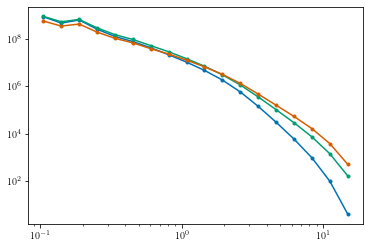

In [80]:
#plt.plot(k, W_k_CCATp, color='red')
plt.loglog(k[1:-1], p_specs['P_21cm_21cm'][1:-1] * W_k_21cm[1:-1],
            color=colors[0], marker='.')

plt.loglog(k[1:-1], p_specs['P_CII_CII'][1:-1] * W_k_CII[1:-1],
            color=colors[1], marker='.')

plt.loglog(k[1:-1], p_specs['P_OIII_OIII'][1:-1] * W_k_OIII[1:-1],
            color=colors[2], marker='.')


#plt.axvline(1 / sigma_para_CCATp.to_value(), color='red', ls='--', alpha=.2)
# plt.axvline(1 / sigma_perp_FYST.to_value(), color='b')

### Current and future surveys

In [81]:
specs_CCATp = {'sigma_pix': 0.86 * (u.MJy * u.s**(1/2) / u.steradian),
               'N_det': 20 * u.dimensionless_unscaled,
               'theta_FWMH': 46.0 * u.arcsec,
               'nu_obs_min': 200.0 * u.GHz,
               'nu_obs_max': 300.0 * u.GHz,
               'delta_nu': 2.5 * u.GHz,
               't_obs': 3400 * u.hr,
               'Omega_surv': 1.7 * u.degree**2,
               'AGN Source': 'COSMOS'}

specs_HERA = {'sigma_pix': None,
               'N_det': None,
               'theta_FWMH': None,
               'nu_obs_min': 100.0 * u.GHz,
               'nu_obs_max': 200.0 * u.GHz,
               'delta_nu': 97.8 * u.kHz,
               't_obs': None,
               'Omega_surv': 1440 * u.degree**2,
               'AGN Source': None}

specs_StageII = {'sigma_pix': 0.21 * (u.MJy * u.s**(1/2) / u.steradian),
               'N_det': 16**4 * u.dimensionless_unscaled,
               'theta_FWMH': 30.1 * u.arcsec,
               'nu_obs_min': 200.0 * u.GHz,
               'nu_obs_max': 300.0 * u.GHz,
               'delta_nu': 0.4 * u.GHz,
               't_obs': 2000 * u.hr,
               'Omega_surv': 100.0 * u.degree**2,
               'AGN Source': 'DESI'}

specs_EXCLAIM = {'sigma_pix': 0.2 * (u.MJy * u.s**(1/2) / u.steradian),
               'N_det': 30 * u.dimensionless_unscaled,
               'theta_FWMH': None,
               'sigma_beam': utils.calc_sigma_beam(6, lambda_OIII, 3.0 * u.m),
               'B_nu': 40.0 * u.GHz,
               'nu_obs_min': 420.0 * u.GHz,
               'nu_obs_max': 540.0 * u.GHz,
               'delta_nu': 1000 * u.MHz,
               't_obs': 8.0 * u.hr,
               'Omega_surv': 100.0 * u.degree**2,
               'AGN Source': 'DESI'}


### Errors

Now we need to make sure our we have realistic estimated errors on our measurements.

In [82]:
V_survey_21cm = calc_V_survey(z, Omega_surv_21cm, B_21cm, nu_21cm)
V_survey_CII = calc_V_survey(z, Omega_surv_CII, B_CII, nu_CII)
V_survey_OIII = calc_V_survey(z, Omega_surv_OIII, B_21cm, nu_OIII)

V_vox_21cm = calc_V_vox(z, sigma_beam, delta_nu_21cm, nu_21cm)
V_vox_CII = calc_V_vox(z, sigma_beam, delta_nu_CII, nu_CII)
V_vox_OIII = calc_V_vox(z, sigma_beam, delta_nu_OIII, nu_OIII)

#### N modes check

In [83]:
N_modes = calc_N_modes(k, V_survey_21cm, align='left')
N_modes

array([9.76323026e-01, 2.34192812e+00, 5.61763592e+00, 1.34751503e+01,
       3.23231477e+01, 7.75342651e+01, 1.85983195e+02, 4.46122094e+02,
       1.07012315e+03, 2.56692860e+03, 6.15734966e+03, 1.47697738e+04,
       3.54285905e+04, 8.49833609e+04, 2.03851509e+05, 4.88983224e+05,
       1.17293511e+06, 2.81354598e+06, 6.74891635e+06])

In [84]:
V_survey_21cm / V_vox_21cm

<Quantity 19960500.72253454>

In [85]:
V_survey_CII / V_vox_CII 

<Quantity 19960500.72253453>

In [86]:
# Need to update with HERA
t_pix_21cm = calc_t_pix(specs_CCATp['N_det'], specs_CCATp['t_obs'],
                                                   Omega_surv_CII, sigma_beam)

t_pix_CII = calc_t_pix(specs_StageII['N_det'], specs_StageII['t_obs'],
                                                   Omega_surv_CII, sigma_beam)
t_pix_OIII = calc_t_pix(specs_EXCLAIM['N_det'], specs_EXCLAIM['t_obs'],
                                                   Omega_surv_OIII, sigma_beam)

P_N_21cm = calc_P_N(specs_StageII['sigma_pix'], V_vox_21cm, t_pix_21cm)
P_N_CII = calc_P_N(specs_StageII['sigma_pix'], V_vox_CII, t_pix_CII)
P_N_OIII = calc_P_N(specs_EXCLAIM['sigma_pix'], V_vox_OIII, t_pix_OIII)

N_modes = calc_N_modes(k, V_survey_21cm, align='left')

#sigma_21cm_CII = error_bars(P_21cm_CII[:-1], P_21cm_21cm[:-1], P_CII_CII[:-1],
#                                                P_N_21cm, W_k_21cm[:-1], N_modes) 

var_21cm_21cm = var_x(P_21cm_21cm[:-1], W_k_21cm[:-1], P_21cm_21cm[:-1], W_k_21cm[:-1],
                     P_N_21cm, P_N_21cm, P_21cm_21cm[:-1], N_modes)
var_CII_CII = var_x(P_CII_CII[:-1], W_k_CII[:-1], P_CII_CII[:-1], W_k_CII[:-1],
                     P_N_CII, P_N_CII, P_CII_CII[:-1], N_modes)
var_OIII_OIII = var_x(P_OIII_OIII[:-1], W_k_OIII[:-1], P_OIII_OIII[:-1], W_k_OIII[:-1],
                     P_N_OIII, P_N_OIII, P_OIII_OIII[:-1], N_modes)

var_21cm_CII = var_x(P_21cm_21cm[:-1], W_k_21cm[:-1], P_CII_CII[:-1], W_k_CII[:-1],
                     P_N_21cm, P_N_CII, P_21cm_CII[:-1], N_modes)
var_21cm_OIII = var_x(P_21cm_21cm[:-1], W_k_21cm[:-1], P_OIII_OIII[:-1], W_k_OIII[:-1],
                     P_N_21cm, P_N_OIII, P_21cm_OIII[:-1], N_modes)
var_CII_OIII = var_x(P_CII_CII[:-1], W_k_CII[:-1], P_OIII_OIII[:-1], W_k_OIII[:-1],
                     P_N_CII, P_N_OIII, P_CII_OIII[:-1], N_modes)

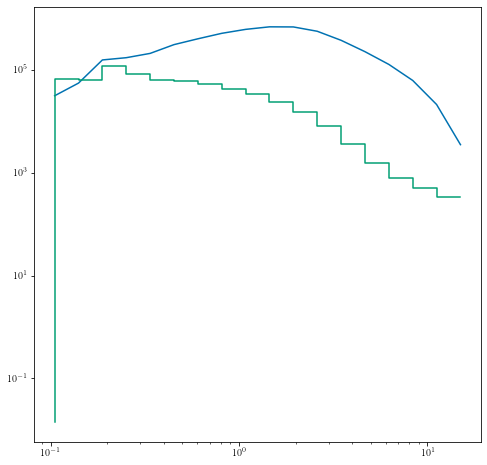

In [87]:
plt.figure(figsize=(8,8))
plt.loglog(k[1:-1], (k[1:-1]**3 * P_21cm_CII[1:-1] * W_k_CII[1:-1])
           / (2 * np.pi**2))
plt.loglog(k[1:-1], (k[1:-1]**3 * np.sqrt(var_21cm_CII[:-1])) / (2 * np.pi**2), 
                              drawstyle='steps')

# plt.ylim(1e2, 1e4)

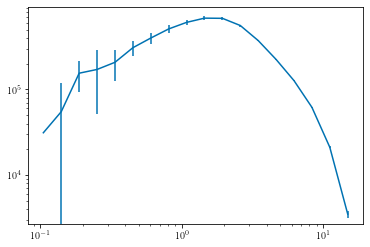

In [88]:
plt.errorbar(k[1:-1], k[1:-1]**3 * P_21cm_CII.value[1:-1] * W_k_21cm[1:-1] / (2 * np.pi**2),
                                         yerr=k[1:-1]**3 * np.sqrt(var_21cm_CII[:-1]).value / (2 * np.pi**2))

plt.xscale('log')
plt.yscale('log')

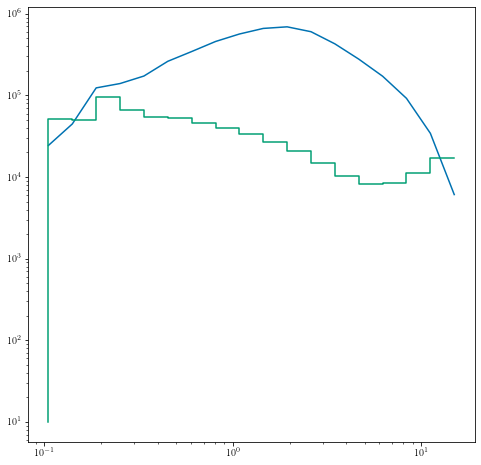

In [89]:
plt.figure(figsize=(8,8))
plt.loglog(k[1:-1], (k[1:-1]**3 * P_21cm_OIII[1:-1] * W_k_OIII[1:-1]).value / (2 * np.pi**2))
plt.loglog(k[1:-1], (k[1:-1]**3 * np.sqrt(var_21cm_OIII[:-1])).value / (2 * np.pi**2), 
                              drawstyle='steps')



### Comparing noise forecasts with Padmanabhan et al.

In [90]:
# this is just checking sigma / t_pix^(1/2) with Chung et al. (2020) for CCATp

t_pix_CCATp = calc_t_pix(specs_CCATp['N_det'], specs_CCATp['t_obs'],
                                        specs_CCATp['Omega_surv'],
                                        utils.FWHM_to_sigma(specs_CCATp['theta_FWMH']))


sig_t_pix_Chung = 6.2e3 * u.Jy / u.steradian
sig_t_pix_CCATp = specs_CCATp['sigma_pix'] / np.sqrt(t_pix_CCATp)


#### CCAT-p specifications

In [91]:
sigma_beam_CCATp = utils.FWHM_to_sigma(specs_CCATp['theta_FWMH'])
V_surv_CCATp = calc_V_survey(z, specs_CCATp['Omega_surv'],
                               specs_CCATp['nu_obs_max'] - specs_CCATp['nu_obs_min'],
                                nu_CII)
V_vox_CCATp = calc_V_vox(z, sigma_beam_CCATp, specs_CCATp['delta_nu'], nu_CII)
t_pix_CCATp = calc_t_pix(specs_CCATp['N_det'], specs_CCATp['t_obs'],
                                        specs_CCATp['Omega_surv'],
                                        sigma_beam_CCATp)

N_modes_CCATp = calc_N_modes(k, V_surv_CCATp, align='left')

sigma_perp_CCATp = utils.calc_sigma_perp(z, sigma_beam_CCATp)
sigma_para_CCATp = utils.calc_sigma_para(z, nu_CII_obs, specs_CCATp['delta_nu'])

P_N_CCATp = calc_P_N(specs_CCATp['sigma_pix'], V_vox_CCATp, t_pix_CCATp)
W_k_CCATp = utils.calc_W_k(k_units, sigma_perp_CCATp, sigma_para_CCATp)

var_auto_CCATp = var_auto(P_CII_CII[:-1], W_k_CCATp[:-1], P_N_CCATp, N_modes_CCATp)
var_x_CCATp = var_x(P_21cm_21cm[:-1], W_k_21cm[:-1], P_CII_CII[:-1], W_k_CCATp[:-1], P_N_21cm,
                     P_N_CCATp, P_21cm_CII[:-1], N_modes_CCATp)

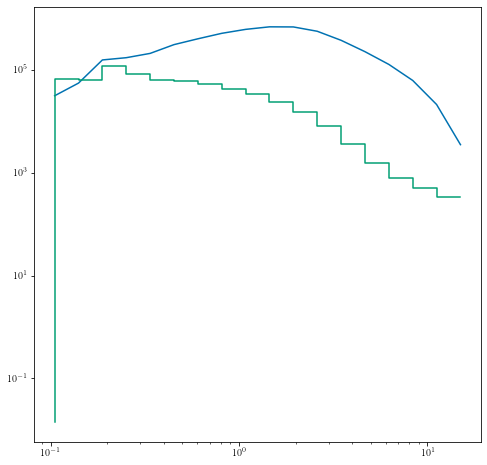

In [92]:
plt.figure(figsize=(8,8))
plt.loglog(k[1:-1], (k[1:-1]**3 * P_21cm_CII[1:-1] * W_k_CII[1:-1]).value / (2 * np.pi**2))
plt.loglog(k[1:-1], (k[1:-1]**3 * np.sqrt(var_21cm_CII[:-1])).value / (2 * np.pi**2), 
                              drawstyle='steps')

#### FYST (or Stage II) specifications

In [93]:
sigma_beam_StageII = utils.FWHM_to_sigma(specs_StageII['theta_FWMH'])
V_surv_StageII = calc_V_survey(z, specs_StageII['Omega_surv'],
                               specs_StageII['nu_obs_max'] - specs_StageII['nu_obs_min'],
                                nu_CII)
V_vox_StageII = calc_V_vox(z, sigma_beam_StageII, specs_StageII['delta_nu'], nu_CII)
t_pix_StageII = calc_t_pix(specs_StageII['N_det'], specs_StageII['t_obs'],
                                        specs_StageII['Omega_surv'],
                                        sigma_beam_StageII)

N_modes_StageII = calc_N_modes(k, V_surv_StageII, align='left')

sigma_perp_StageII = utils.calc_sigma_perp(z, sigma_beam_StageII)
sigma_para_StageII = utils.calc_sigma_para(z, nu_CII_obs, specs_StageII['delta_nu'])

P_N_StageII = calc_P_N(specs_StageII['sigma_pix'], V_vox_StageII, t_pix_StageII)
W_k_StageII = utils.calc_W_k(k_units, sigma_perp_StageII, sigma_para_StageII)

var_auto_StageII = var_auto(P_CII_CII[:-1], W_k_StageII[:-1], P_N_StageII, N_modes_StageII)
var_x_StageII = var_x(P_21cm_21cm[:-1], W_k_21cm[:-1], P_CII_CII[:-1], W_k_StageII[:-1],
                      P_N_21cm, P_N_StageII, P_21cm_CII[:-1], N_modes_StageII)

In [94]:
V_surv_StageII / V_vox_StageII

<Quantity 1.9830217e+09>

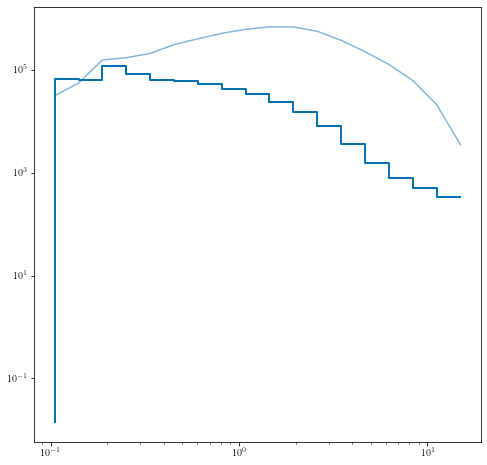

In [95]:
plt.figure(figsize=(8,8))
plt.loglog(k[1:-1], (k[1:-1]**3 * P_21cm_CII[1:-1] * np.sqrt(W_k_CII[1:-1] 
                                                             * W_k_21cm[1:-1])).value / (2 * np.pi**2),
                                          color=colors[0], alpha=.5, label='idealized survey')
plt.loglog(k[1:-1], (k[1:-1]**3 * np.sqrt(var_21cm_CII[:-1])).value / (2 * np.pi**2), 
                              drawstyle='steps', color=colors[0], lw=2)

(1, 1000000)

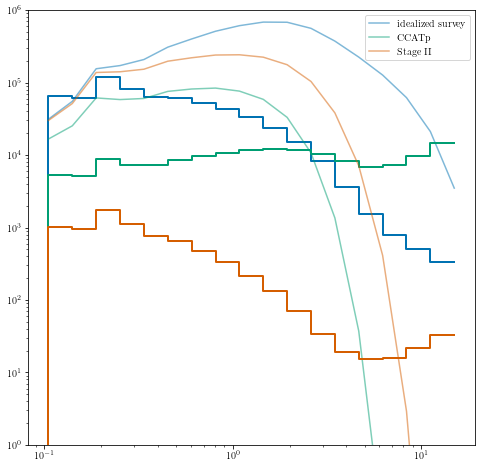

In [96]:
plt.figure(figsize=(8,8))
plt.loglog(k[1:-1], (k[1:-1]**3 * P_21cm_CII[1:-1] * np.sqrt(W_k_CII[1:-1] 
                                                             * W_k_21cm[1:-1])).value / (2 * np.pi**2),
                                          color=colors[0], alpha=.5, label='idealized survey')
plt.loglog(k[1:-1], (k[1:-1]**3 * np.sqrt(var_21cm_CII[:-1])).value / (2 * np.pi**2), 
                              drawstyle='steps', color=colors[0], lw=2)

plt.loglog(k[1:-1], (k[1:-1]**3 * P_21cm_CII[1:-1] * np.sqrt(W_k_CCATp[1:-1] 
                                                             * W_k_21cm[1:-1])).value / (2 * np.pi**2),
                                          color=colors[1], alpha=.5, label='CCATp')
plt.loglog(k[1:-1], (k[1:-1]**3 * np.sqrt(var_x_CCATp[:-1])).value / (2 * np.pi**2), 
                              drawstyle='steps', color=colors[1], lw=2)

plt.loglog(k[1:-1], (k[1:-1]**3 * P_21cm_CII[1:-1] * np.sqrt(W_k_StageII[1:-1] 
                                                             * W_k_21cm[1:-1])).value / (2 * np.pi**2),
                                          color=colors[2], alpha=.5, label='Stage II')
plt.loglog(k[1:-1], (k[1:-1]**3 * np.sqrt(var_x_StageII[:-1])).value / (2 * np.pi**2), 
                              drawstyle='steps', color=colors[2], lw=2)

plt.legend()
plt.ylim(10**0, 10**6)

Text(0, 0.5, '$\\Delta^2 (k) \\times W(k) \\, [$ Jy/sr $]^2$')

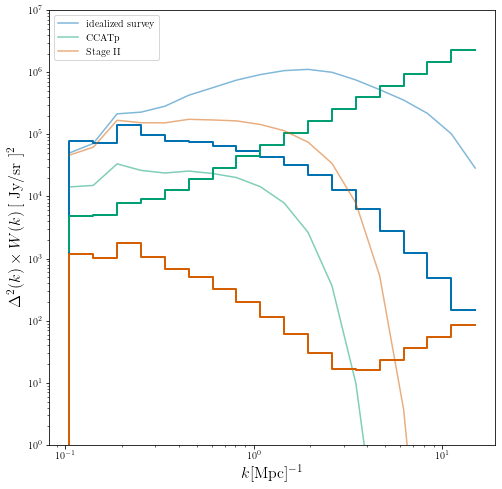

In [97]:
plt.figure(figsize=(8,8))
plt.loglog(k[1:-1], (k[1:-1]**3 * P_CII_CII[1:-1] * W_k_CII[1:-1]).value / (2 * np.pi**2),
                                          color=colors[0], alpha=.5, label='idealized survey')
plt.loglog(k[1:-1], (k[1:-1]**3 * np.sqrt(var_CII_CII[:-1])).value / (2 * np.pi**2), 
                              drawstyle='steps', color=colors[0], lw=2)

plt.loglog(k[1:-1], (k[1:-1]**3 * P_CII_CII[1:-1] * W_k_CCATp[1:-1]).value / (2 * np.pi**2),
                                          color=colors[1], alpha=.5, label='CCATp')
plt.loglog(k[1:-1], (k[1:-1]**3 * np.sqrt(var_auto_CCATp[:-1])).value / (2 * np.pi**2), 
                              drawstyle='steps', color=colors[1], lw=2)

plt.loglog(k[1:-1], (k[1:-1]**3 * P_CII_CII[1:-1] * W_k_StageII[1:-1]).value / (2 * np.pi**2),
                                          color=colors[2], alpha=.5, label='Stage II')
plt.loglog(k[1:-1], (k[1:-1]**3 * np.sqrt(var_auto_StageII[:-1])).value / (2 * np.pi**2), 
                              drawstyle='steps', color=colors[2], lw=2)

plt.legend()
plt.ylim(10**0, 10**7)
plt.xlabel(r'$k [$Mpc$]^{-1}$', fontsize=16)
plt.ylabel(r'$\Delta^2 (k) \times W(k) \, [$ Jy/sr $]^2$', fontsize=16)

#### EXCLAIM specifications

In [98]:
V_surv_EXCLAIM = calc_V_survey(z, specs_EXCLAIM['Omega_surv'],
                               specs_EXCLAIM['B_nu'],
                                nu_OIII)
V_vox_EXCLAIM = calc_V_vox(z, specs_EXCLAIM['sigma_beam'], specs_EXCLAIM['delta_nu'], nu_OIII)
t_pix_EXCLAIM = calc_t_pix(specs_EXCLAIM['N_det'], specs_EXCLAIM['t_obs'],
                                        specs_EXCLAIM['Omega_surv'],
                                        specs_EXCLAIM['sigma_beam'])
N_modes_EXCLAIM = calc_N_modes(k, V_surv_EXCLAIM, align='left')

sigma_perp_EXCLAIM = utils.calc_sigma_perp(z, specs_EXCLAIM['sigma_beam'])
sigma_para_EXCLAIM = utils.calc_sigma_para(z, nu_OIII_obs, specs_EXCLAIM['delta_nu'])

P_N_EXCLAIM = calc_P_N(specs_EXCLAIM['sigma_pix'], V_vox_EXCLAIM, t_pix_EXCLAIM)
W_k_EXCLAIM = utils.calc_W_k(k_units, sigma_perp_EXCLAIM, sigma_para_EXCLAIM)

var_auto_EXCLAIM = var_auto(P_OIII_OIII[:-1], W_k_EXCLAIM[:-1], P_N_EXCLAIM, N_modes_EXCLAIM)
var_x_EXCLAIM = var_x(P_21cm_21cm[:-1], W_k_21cm[:-1], P_OIII_OIII[:-1], W_k_EXCLAIM[:-1], P_N_21cm,
                     P_N_EXCLAIM, P_21cm_OIII[:-1], N_modes_EXCLAIM)

In [99]:
N_modes_EXCLAIM

array([8.07311318e+02, 1.93651591e+03, 4.64516450e+03, 1.11424611e+04,
       2.67276734e+04, 6.41122744e+04, 1.53787562e+05, 3.68893702e+05,
       8.84873663e+05, 2.12256646e+06, 5.09144816e+06, 1.22129718e+07,
       2.92955316e+07, 7.02718540e+07, 1.68562685e+08, 4.04335123e+08,
       9.69887802e+08, 2.32649180e+09, 5.58060847e+09])

Text(0, 0.5, '$\\Delta^2 (k) \\times W(k) \\, [$ Jy/sr $]^2$')

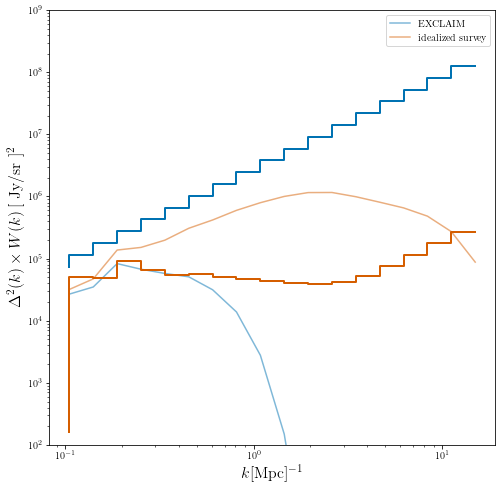

In [100]:
plt.figure(figsize=(8,8))
plt.loglog(k[1:-1], (k[1:-1]**3 * P_OIII_OIII[1:-1] * W_k_EXCLAIM[1:-1]).value / (2 * np.pi**2),
                                      color=colors[0], alpha=0.5, label='EXCLAIM')
plt.loglog(k[1:-1], (k[1:-1]**3 * np.sqrt(var_auto_EXCLAIM[:-1])).value / (2 * np.pi**2), 
                              drawstyle='steps', color=colors[0], lw=2)

plt.loglog(k[1:-1], (k[1:-1]**3 * P_OIII_OIII[1:-1] * W_k_OIII[1:-1]).value / (2 * np.pi**2),
                                      color=colors[2], alpha=0.5, label='idealized survey')
plt.loglog(k[1:-1], (k[1:-1]**3 * np.sqrt(var_OIII_OIII[:-1])).value / (2 * np.pi**2), 
                              drawstyle='steps', color=colors[2], lw=2)

plt.legend()
plt.ylim(1e2, 1e9)
plt.xlabel(r'$k [$Mpc$]^{-1}$', fontsize=16)
plt.ylabel(r'$\Delta^2 (k) \times W(k) \, [$ Jy/sr $]^2$', fontsize=16)

### Current and upcoming surveys

In [101]:
import matplotlib.transforms as mtransforms
import matplotlib.patches as mpatch
from matplotlib.patches import FancyBboxPatch

In [102]:
sigma_beam_CCATp = utils.FWHM_to_sigma(specs_CCATp['theta_FWMH']) # FWHM_to_sigma(46) #arcsec
sigma_perp_CCATp = utils.calc_sigma_perp(z, sigma_beam_CCATp)
sigma_para_CCATp = utils.calc_sigma_para(z, nu_CII_obs, specs_CCATp['delta_nu'])

In [103]:
def add_fancy_patch_around(ax, bb, **kwargs):
    fancy = FancyBboxPatch((bb.xmin, bb.ymin), bb.width, bb.height,
                           **kwargs)
    ax.add_patch(fancy)
    return fancy

def draw_control_points_for_patches(ax):
    for patch in ax.patches:
        patch.axes.plot(*patch.get_path().vertices.T, ".",
                        c=patch.get_edgecolor())
        
def plot_box(ax, k_perp_min, k_perp_max, k_para_min, k_para_max, color):
    # Bbox object around which the fancy box will be drawn.
    bb = mtransforms.Bbox([[k_perp_min, k_para_min], [k_perp_max, k_para_max]])


    # a fancy box with round corners. pad=0.1
    fancy = add_fancy_patch_around(ax, bb, boxstyle="round,pad=0.0",
                                alpha=.2, color=color)

In [104]:
sigma_beam_FYST = 1.22 * lambda_CII / (3 * u.m)

sigma_perp_FYST = utils.calc_sigma_perp(z, sigma_beam_FYST.decompose())
sigma_perp_HERA = utils.calc_sigma_perp(z, sigma_beam_FYST.decompose())
sigma_perp_CCATp = utils.calc_sigma_perp(z, utils.FWHM_to_sigma(specs_CCATp['theta_FWMH']))
sigma_perp_StageII = utils.calc_sigma_perp(z, utils.FWHM_to_sigma(specs_StageII['theta_FWMH']))
sigma_perp_EXCLAIM_1 = utils.calc_sigma_perp(z, specs_EXCLAIM['sigma_beam'])

sigma_para_FYST = utils.calc_sigma_para(z, nu_CII_obs, 300 * u.MHz)
sigma_para_HERA = utils.calc_sigma_para(z, nu_21cm_obs, specs_HERA['delta_nu'])
sigma_para_CCATp = utils.calc_sigma_para(z, nu_CII_obs, specs_CCATp['delta_nu'])
sigma_para_StageII = utils.calc_sigma_para(z, nu_CII_obs, specs_StageII['delta_nu'])
sigma_perp_EXCLAIM_1 = utils.calc_sigma_perp(z, specs_EXCLAIM['sigma_beam'])

In [105]:
L_perp_CCATp = (np.sqrt(Planck15.comoving_distance(z)**2 \
            * specs_CCATp['Omega_surv'])).to(u.Mpc, equivalencies=u.dimensionless_angles())
L_para_CCATp = ((const.c / Planck15.H(z)) * (100 * u.GHz) \
          * (1 + z)**2 / nu_CII).to(u.Mpc)

L_perp_StageII = (np.sqrt(Planck15.comoving_distance(z)**2 \
            * specs_StageII['Omega_surv'])).to(u.Mpc, equivalencies=u.dimensionless_angles())
L_para_StageII = ((const.c / Planck15.H(z)) * (100 * u.GHz) \
          * (1 + z)**2 / nu_CII).to(u.Mpc)

L_perp_HERA = (np.sqrt(Planck15.comoving_distance(z)**2 \
            * specs_HERA['Omega_surv'])).to(u.Mpc, equivalencies=u.dimensionless_angles())
L_para_HERA = ((const.c / Planck15.H(z)) * (100 * u.MHz) \
          * (1 + z)**2 / nu_21cm).to(u.Mpc)

L_perp_EXCLAIM_1 = (np.sqrt(Planck15.comoving_distance(z)**2 \
            * (100 * u.degree**2))).to(u.Mpc, equivalencies=u.dimensionless_angles())
L_para_EXCLAIM_1 = ((const.c / Planck15.H(z)) * (100 * u.GHz) \
          * (1 + z)**2 / nu_OIII).to(u.Mpc)

In [106]:
colors = ['#0072B2', '#009E73', '#D55E00', '#CC79A7', '#F0E442', '#56B4E9']

In [107]:
L_perp_CCATp = (np.sqrt(Planck15.comoving_distance(z)**2 \
            * specs_CCATp['Omega_surv'])).to(u.Mpc, equivalencies=u.dimensionless_angles())
L_para_CCATp = ((const.c / Planck15.H(z)) * (100 * u.GHz) \
          * (1 + z)**2 / nu_CII).to(u.Mpc)

L_perp_FYST = (np.sqrt(Planck15.comoving_distance(z)**2 \
            * (100 * u.degree**2))).to(u.Mpc, equivalencies=u.dimensionless_angles())
L_para_FYST = ((const.c / Planck15.H(z)) * (100 * u.GHz) \
          * (1 + z)**2 / nu_CII).to(u.Mpc)

L_perp_FYST_2 = (np.sqrt(Planck15.comoving_distance(z)**2 \
            * (100 * u.degree**2))).to(u.Mpc, equivalencies=u.dimensionless_angles())
L_para_FYST_2 = ((const.c / Planck15.H(z)) * (100 * u.GHz) \
          * (1 + z)**2 / nu_CII).to(u.Mpc)

print(L_perp_CCATp, L_para_CCATp)
print(L_perp_FYST, L_para_FYST)
print(L_perp_FYST_2, L_para_FYST_2)

200.7675231027197 Mpc 1181.5679862626573 Mpc
1539.8166111739163 Mpc 1181.5679862626573 Mpc
1539.8166111739163 Mpc 1181.5679862626573 Mpc


In [108]:
print('CCATp:')
print(L_perp_CCATp, L_para_CCATp)

print('StageII:')
print(L_perp_StageII, L_para_StageII)

print('HERA:')
print(L_perp_HERA, L_para_HERA)

print('Box:')
print(box_size * u.Mpc, box_size * u.Mpc)

CCATp:
200.7675231027197 Mpc 1181.5679862626573 Mpc
StageII:
1539.8166111739163 Mpc 1181.5679862626573 Mpc
HERA:
5843.193204325746 Mpc 1580.5260306245063 Mpc
Box:
80.0 Mpc 80.0 Mpc


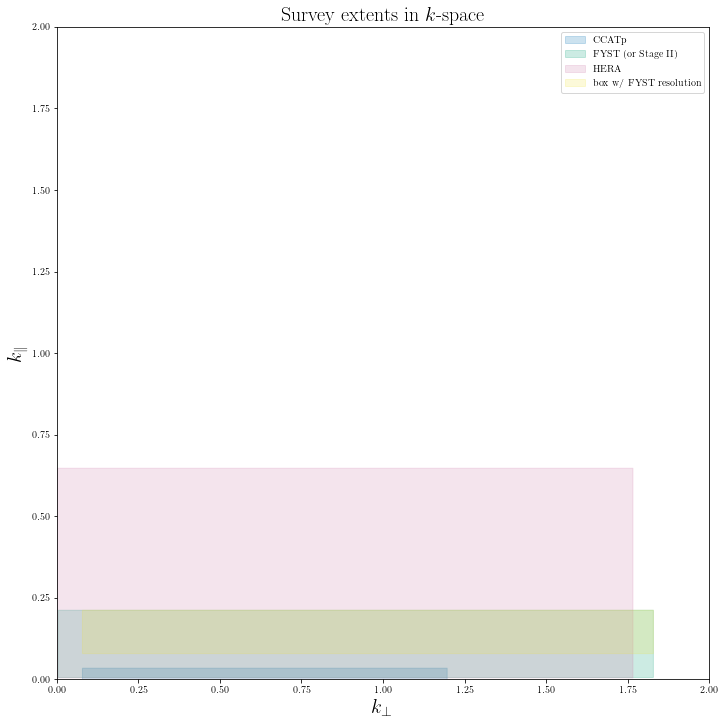

In [109]:
fig, ax = plt.subplots(1,1, figsize=(12, 12))

k_perp_min_CCATp = (2 * np.pi) / L_perp_21cm
k_perp_min_StageII = (2 * np.pi) / L_perp_StageII
k_perp_min_HERA = (2 * np.pi) / L_perp_HERA
k_perp_min_EXCLAIM_1 = (2 * np.pi) / L_perp_EXCLAIM_1
#k_perp_min_EXCLAIM_2 = (2 * np.pi) / L_perp_21cm

k_para_min_CCATp = (2 * np.pi) / L_para_21cm
k_para_min_StageII = (2 * np.pi) / L_para_StageII
k_para_min_HERA = (2 * np.pi) / L_para_HERA
k_para_min_EXCLAIM_1 = (2 * np.pi) / L_para_EXCLAIM_1
#k_para_min_EXCLAIM_2 = (2 * np.pi) / L_para_EXCLAIM_2

k_perp_max_CCATp = 1 / sigma_perp_CCATp
k_perp_max_StageII = 1 / sigma_perp_StageII
k_perp_max_HERA = 1 / sigma_perp_HERA
#k_perp_max_EXCLAIM_1 = 1 / sigma_perp_EXCLAIM_1
#k_perp_max_EXCLAIM_2 = 1 / sigma_perp_EXCLAIM_2

k_para_max_CCATp = 1 / sigma_para_CCATp
k_para_max_StageII = 1 / sigma_para_StageII
k_para_max_HERA = 1 / sigma_para_HERA
#k_perp_max_EXCLAIM_1 = 1 / sigma_para_EXCLAIM_1
#k_perp_max_EXCLAIM_2 = 1 / sigma_para_EXCLAIM_2

plot_box(ax, k_perp_min_CCATp.value, k_perp_max_CCATp.value,
                             k_para_min_CCATp.value, k_para_max_CCATp.value, colors[0])
plot_box(ax, k_perp_min_StageII.value, k_perp_max_StageII.value, 
                             k_para_min_StageII.value, k_para_max_StageII.value, colors[1])
#plot_box(ax, k_perp_min_box.value, k_perp_max_box.value, k_para_min_box.value,
#                             k_para_max_box.value, colors[2])
plot_box(ax, k_perp_min_HERA.value, k_perp_max_HERA.value,
                             k_para_min_HERA.value, k_para_max_HERA.value, colors[3])
plot_box(ax, k_perp_min_box.value, k_perp_max_StageII.value, k_para_min_box.value,
                     k_para_max_StageII.value, colors[4])



setup = ax.set(xlim=(0, 2), ylim=(0, 2), aspect=1)
x_l = ax.set_xlabel(r'$k_{\perp}$', fontsize=20)
y_l = ax.set_ylabel(r'$k_{\parallel}$', fontsize=20)

title = ax.set_title('Survey extents in $k$-space', fontsize=20)
leg = ax.legend(['CCATp', 'FYST (or Stage II)', 'HERA', 'box w/ FYST resolution'])

In [110]:
def calc_V_surv_generic_check(z, nu_rest, Omega_surv, B_nu):
    A_s = Omega_surv  
    B_nu = B_nu
    r = Planck15.comoving_distance(z)
    y = (const.c * (1 + z)**2) / (Planck15.H(z) * nu_rest)
    
    V = r**2 * y * A_s * B_nu * Planck15.h**3
    
    return V.to(u.Mpc**3, equivalencies=u.dimensionless_angles())

# Fitting

Now that we have our simulated data, and our survey specifications, we can now run our full simulations and recover the best fit parameters.

In [111]:
import copy as cp

spectra_superfake = cp.deepcopy(spectra)

In [112]:
b_i = np.sqrt(spectra[1][0] / P_m)
b_j = np.sqrt(spectra[1][3] / P_m)
b_k = np.sqrt(spectra[1][5] / P_m)

biases = [b_i, b_j, b_k]

for i in range(len(indices)):
    spectra_superfake[1][i] = biases[int(indices[i][0])] * biases[int(indices[i][1])] \
                            * P_m
    
P_21_Beane_superfake = spectra_superfake[1][1] *  spectra_superfake[1][2] \
                            /  spectra_superfake[1][4]

/Users/lisaleemcb/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: RuntimeWarning: invalid value encountered in true_divide
  """Entry point for launching an IPython kernel.
/Users/lisaleemcb/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in true_divide
  
/Users/lisaleemcb/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: RuntimeWarning: invalid value encountered in true_divide
  This is separate from the ipykernel package so we can avoid doing imports until


Let's initialize our simulations with the desired specifications.  Let's set three different noise levels: optimistic, conservative, pessimistic.

In [890]:
k_indices = [6]

biases = utils.extract_bias(k_indices, spectra[1], P_m)
biases_sf = utils.extract_bias(k_indices, spectra_superfake[1], P_m)

p_names = np.asarray(['b_i','b_j', 'b_k', 'P_m'])
p_vals = np.asarray([*biases, P_m], dtype=object)

model_params = dict(zip(p_names, p_vals))
ndim = utils.choose_params(model_params, k_indices).size

model = models.ScalarBias(k=spectra[0], params=model_params)
model_cross = models.ScalarBias_crossonly(k=spectra[0], params=model_params)

data = utils.fetch_data(spectra[0], k_indices, spectra[1], b_0=model_params['b_i'])
data_sf = utils.fetch_data(spectra_superfake[0], k_indices, spectra_superfake[1], b_0=model_params['b_i'])

variances = [var_21cm_21cm, var_21cm_CII, var_21cm_OIII, var_CII_OIII, b_i * .25]

N_op = analysis.estimate_errors(data, frac_error=.1)
N_con = analysis.estimate_errors(data, frac_error=.25)
N_pess = analysis.estimate_errors(data, frac_error=.35)

N = analysis.create_noise_matrix(k_indices, variances)

In [855]:
utils.fetch_data(spectra[0], k_indices, spectra[1])

array([77809270.4268876 , 68800708.48450793, 80327185.39862339,
       58499994.10887054,        0.        ])

In [859]:
N_op

array([[4.73353749e+13, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [0.00000000e+00, 6.45245671e+13, 0.00000000e+00, 0.00000000e+00],
       [0.00000000e+00, 0.00000000e+00, 3.42224931e+13, 0.00000000e+00],
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 7.86003876e+04]])

### Least Square Estimators

We first want to fit our data using our least squares formalism,

In [868]:
LSE_op = estimators.Estimators(k, data_sf, N_op)
LSE_results_op = LSE_op.LSE_3cross_1bias()

We want these results in our original parameterization.  The standard expression for the propagation of uncertainty is given by,

$\sigma_f = \sqrt{\left( \frac{\partial f}{\partial x} \right)^2 \sigma_x^2}$

We have two cases:

1) a parameter that looks like $b = e^{i \eta}$,

then,
$\sigma_b = \sqrt{\left( \frac{\partial f(\eta)}{\partial \eta} \right)^2 \sigma_\eta^2}$

$= \sqrt{\left( \frac{\partial}{\partial \eta} e^{\eta} \right)^2 \sigma_\eta^2}$

$= \sqrt{ \left( e^{\eta} \right)^2 \sigma_\eta^2}$

$\sigma_b = e^{\eta} \eta$

2) fitting $\ln{P_m}$ in lieu of $P_m$,

with $f(x) = e^x$ and $x=\ln{P_m}$, yielding,

$\sigma_{P_m} = \sqrt{\left( \frac{\partial }{\partial(\ln{P_m})}\left[ e^{\ln{P_m}} \right] \right)^2 \sigma_{\ln{P_m}}^2} $

$= \sqrt{\left(e^{\ln{P_m}}\right)^2 \sigma_{\ln{P_m}}^2}$
$= \sqrt{P^2_m \sigma_{\ln{P_m}}^2}$

$\sigma_{P_m} = P_m \sigma_{\ln{P_m}}$

In [874]:
P_m

array([0.00000000e+00, 9.91432762e+01, 5.70728734e+01, 7.40156501e+01,
       3.18019094e+01, 1.60424968e+01, 9.89934945e+00, 5.40108399e+00,
       2.97116482e+00, 1.58045389e+00, 8.38070921e-01, 4.42899755e-01,
       2.32886610e-01, 1.18974580e-01, 5.99164584e-02, 2.97635196e-02,
       1.42383400e-02, 5.77166379e-03, 1.63821461e-03, 0.00000000e+00])

In [879]:
LSE_params, LSE_errors = fitting.recover_params_LSE(k, k_indices, spectra_superfake[1], model_cross, P_m, variances,
                            inject_noise=False)

[7.78092704e+07 8.61120454e+07 8.09719869e+07 7.31648075e+07
 2.80357607e+03]
DATA:  [8.61120454e+07 8.09719869e+07 7.31648075e+07 2.80357607e+03]
NOISE:  [2.96611375e+14 2.62258506e+14 2.14123562e+14 7.86003876e+04]
noise has shape  (5, 5)


In [881]:
LSE_params, LSE_errors

(array([2803.57606707, 3102.73657944, 2636.22961747,    9.89934945]),
 array([7.86003876e+04, 1.91299218e+10, 1.76189489e+10, 9.51333989e+07]))

### MCMC's

In [115]:
def frac_diff(model, true=P_21cm_21cm.value[1:-1]):
    return (true - model) / model

In [884]:
N_low

array([[6.79074077e+15, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00],
       [0.00000000e+00, 7.03114266e+15, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00],
       [0.00000000e+00, 0.00000000e+00, 4.63576471e+15, 0.00000000e+00,
        0.00000000e+00],
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 4.47726322e+15,
        0.00000000e+00],
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00]])

In [891]:
mcmc_results_low = fitting.recover_params_mcmc(k, k_indices, spectra_superfake[1], model_cross,
                                    P_m, variances, N=N_op, priors='gaussian',
                                    nwalkers=48, nsteps=1e6,
                                    positivity=True, priors_width=.1)

PARAMS:  [2803.576067067669 3102.736579435258 2636.2296174741623
 array([0.00000000e+00, 9.91432762e+01, 5.70728734e+01, 7.40156501e+01,
        3.18019094e+01, 1.60424968e+01, 9.89934945e+00, 5.40108399e+00,
        2.97116482e+00, 1.58045389e+00, 8.38070921e-01, 4.42899755e-01,
        2.32886610e-01, 1.18974580e-01, 5.99164584e-02, 2.97635196e-02,
        1.42383400e-02, 5.77166379e-03, 1.63821461e-03, 0.00000000e+00])]
DATA:  [86112045.40106638 80971986.87567894 73164807.48387933]
NOISE:  [4.73353749e+13 6.45245671e+13 3.42224931e+13]
running mcmc with the following settings:
fitting data from k:  [6]
prior is:  gaussian
prior width is:  0.1
positivity prior is:  True
pdf is:  gaussian
nsteps:  1000000.0
no backend initialized
Mean acceptance fraction during burnin: 0.551
Mean acceptance fraction: 0.550
Mean autocorrelation time: 88.985 steps


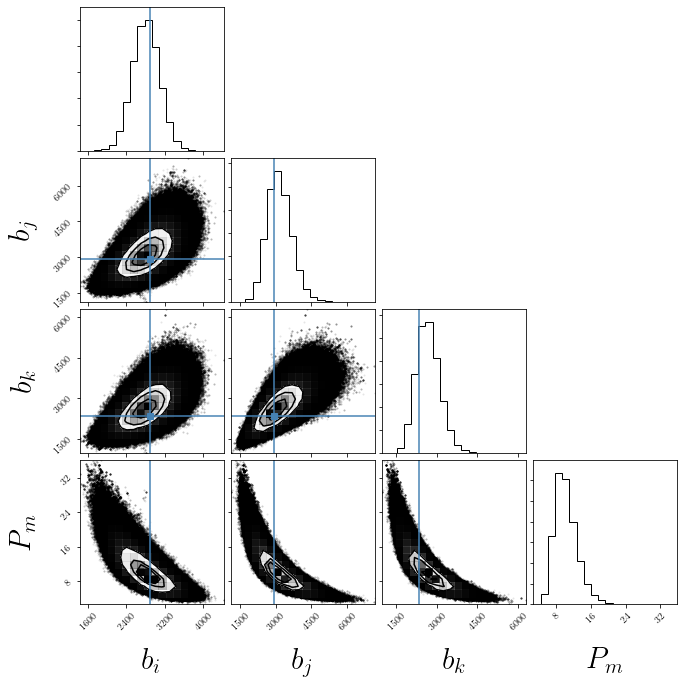

In [893]:
figure = corner.corner(mcmc_results_low[0][0], truths=model_params,
                           labels=[r'$b_i$', r'$b_j$', r'$b_k$', r'$P_m$'],
                           label_kwargs={'fontsize': 30}
                          )



In [118]:
model_params

{'b_i': 2803.576067067669,
 'b_j': 3102.736579435258,
 'b_k': 2636.2296174741623,
 'P_m': array([0.00000000e+00, 9.91432762e+01, 5.70728734e+01, 7.40156501e+01,
        3.18019094e+01, 1.60424968e+01, 9.89934945e+00, 5.40108399e+00,
        2.97116482e+00, 1.58045389e+00, 8.38070921e-01, 4.42899755e-01,
        2.32886610e-01, 1.18974580e-01, 5.99164584e-02, 2.97635196e-02,
        1.42383400e-02, 5.77166379e-03, 1.63821461e-03, 0.00000000e+00])}

### Fisher analysis

#### Reparameterization

In [227]:
def diagonalize(M, S):
    S_inv = np.linalg.inv(S)
    
    return np.matmul(S_inv, np.matmul(M, S))

def transform_theta(theta, truths, Fisher, S_inv):
    diff = theta - truths
    diff = np.matmul(S_inv, diff)
    
    theta_prime = np.matmul(np.sqrt(Fisher), diff)

    return theta_prime

def transform_samples(theta, truths, Fisher, S_inv):
    diff = np.asarray(theta) - np.asarray(truths)
    diff = np.matmul(S_inv, diff.reshape(nsteps * nwalkers,4,1))
    
    theta_prime = np.matmul(np.sqrt(Fisher), diff)

    return theta_prime.reshape(nsteps * nwalkers, 4)

def untransform_theta(theta_prime, truths, Fisher, S):
    theta_temp = np.matmul(np.linalg.inv(np.sqrt(Fisher)), theta_prime)
    theta_temp = np.matmul(S, theta_temp)

    theta = theta_temp + truths

    return theta

def untransform_samples(theta_prime, truths, Fisher, S):
    num = theta_prime.shape[1]
    theta_temp = np.matmul(np.linalg.inv(np.sqrt(Fisher)), theta_prime.reshape(nsteps * nwalkers,4,1))
    theta_temp = np.matmul(S, theta_temp)

    theta = theta_temp.reshape(nsteps * nwalkers,4) + truths

    return theta
                           
def log_prob_Fisher(guess, truth, Fisher):
    
    diff = (np.asarray(guess) - np.asarray(truth))

    return -.5 * np.dot(diff.T, np.dot(Fisher,diff))
    
def transform_lnprob_Fisher(guess, truth, Fisher):    
    scaling = np.linalg.inv(np.sqrt(Fisher))
    guess_transformed = np.matmul(scaling, guess)
    guess_transformed += truth
    
    diff = (np.asarray(guess_transformed) - np.asarray(truth))

    return log_prob_Fisher(guess_transformed, truth, Fisher)

def transform_lnprob(guess, pvals, params, Fisher, S, k_indices, data, model, noise):   
    guess = untransform_theta(guess, pvals, Fisher, S)
    
    return fitting.log_prob(guess, params, k_indices, data, model, noise)

In [504]:
runs = [noise0, noise1, noise2, noise3, noise4, noise5]

In [710]:
p_n = 1 

noise_levels = np.array([.01, .05, .1, .25, .35, .5])

medians = np.zeros_like(noise_levels,)
means = np.zeros_like(noise_levels)
max_lps = np.zeros_like(noise_levels)

medians_trans = np.zeros_like(noise_levels,)
means_trans = np.zeros_like(noise_levels)
max_lps_trans = np.zeros_like(noise_levels)

all_samples = [runs[i][0][0][:,p_n] for i in range(len(noise_levels))]

In [711]:
for i in range(6):
    medians[i] = np.median(runs[i][0][0][:,p_n])
    means[i] = np.mean(runs[i][0][0][:,p_n])
    arg_ind = np.argmax(runs[i][1][0])
    max_lps[i] = (runs[i][0][0][arg_ind,p_n])
    
    medians_trans[i] = np.median(runs[i][0][1][:,p_n])
    means_trans[i] = np.mean(runs[i][0][1][:,p_n])
    arg_ind = np.argmax(runs[i][1][1])
    max_lps_trans[i] = (runs[i][0][1][arg_ind,p_n])

In [712]:
medians, pvals, means, max_lps

(array([3010.08353026, 2956.81804376, 2953.96037178, 3101.65845028,
        3493.14451785, 4555.02873793]),
 [2883.0199982056624, 2933.6076798800073, 2340.967543617764, 99.143276214235],
 array([ 3027.20145581,  2979.04326334,  3017.74472196,  3533.83077431,
         5593.64641055, 75238.33335434]),
 array([2959.60138805, 2930.69507405, 2931.39915851, 2938.66783556,
        2914.34168852, 3048.94093927]))

In [713]:
all_samples[0:-2]

[array([2755.30594907, 2720.56986747, 3091.67549436, ..., 3204.24934431,
        4012.98948954, 3939.55880435]),
 array([3115.87707225, 3156.08861906, 3058.68806165, ..., 3483.90718687,
        2633.41061738, 3102.19800284]),
 array([2208.16262513, 2707.6142989 , 3131.88086376, ..., 3587.32748243,
        2901.10211263, 4290.64086877]),
 array([3729.88266219, 2470.56688566, 4225.87578839, ..., 3592.4874729 ,
        3121.19834173, 5861.3864222 ])]

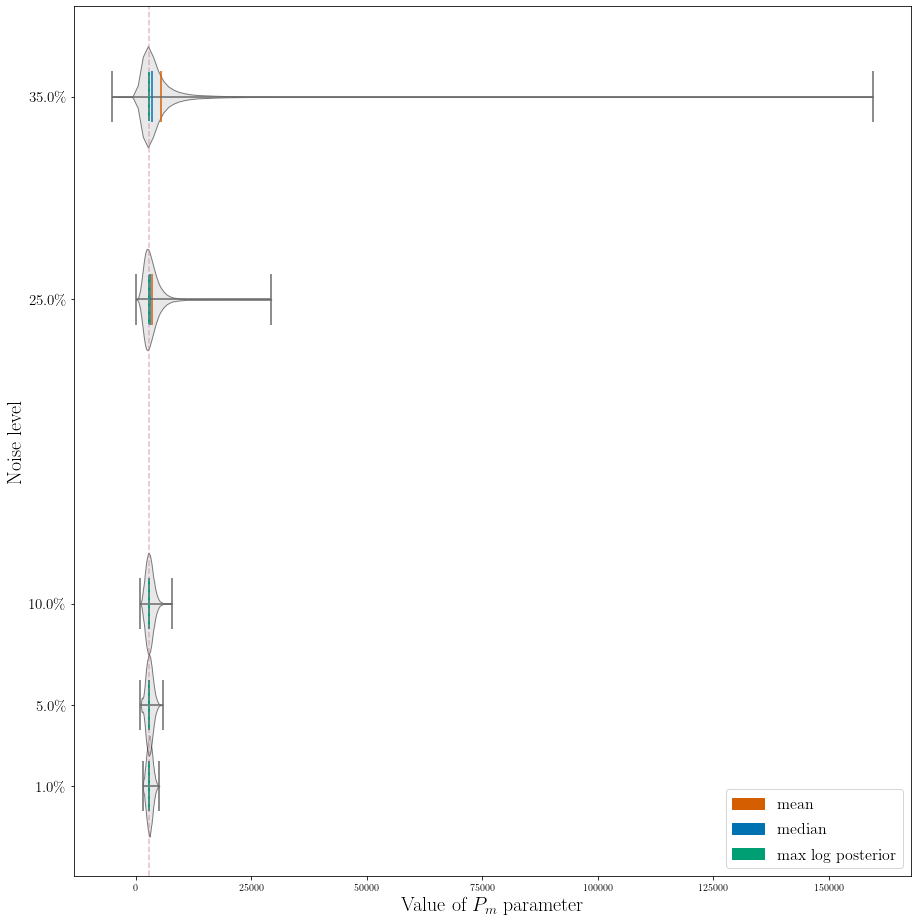

In [719]:
import matplotlib.patches as mpatches
import matplotlib.ticker as mtick

fig, ax = plt.subplots(figsize=(15,16))

ind = noise_levels * 100

ax.axvline(pvals[p_n], color=colors[3], ls='--', alpha=.5)

violins = ax.violinplot(all_samples[:-1], ind[:-1], widths=5.0, vert=False, points=150,
              showmeans=True, showextrema=True, showmedians=True)

violins['cmeans'].set_color(colors[2])
violins['cmedians'].set_color(colors[0])
violins['cmins'].set_color('dimgrey')
violins['cmaxes'].set_color('dimgrey')
violins['cbars'].set_color('dimgrey')

for pc in violins['bodies']:
    pc.set_facecolor('lightgray')
    pc.set_edgecolor('black')
    pc.set_alpha(.5)

[ax.vlines(max_lps[i], ind[i]-1.2, ind[i]+1.2, color=colors[1],
                                               lw=2) for i in range(len(ind[:-1]))]

mean_legend = mpatches.Patch(color=colors[2], label='mean')
median_legend = mpatches.Patch(color=colors[0], label='median')
maxlps_legend = mpatches.Patch(color=colors[1], label='max log posterior')
ax.legend(handles=[mean_legend, median_legend, maxlps_legend], fontsize=16,
                                             loc='lower right')

ax.set_ylabel('Noise level', fontsize=20)
ax.set_xlabel(r'Value of $P_m$ parameter', fontsize=20)


def set_axis_style(ax, labels):
    ax.yaxis.set_tick_params(direction='out')
    ax.yaxis.set_ticks_position('left')
    ax.set_yticks(ind[:-1])
    #ax.set_ylim(0.25, len(labels) + 0.75)
    ax.set_yticklabels(labels, fontsize=15)
    ax.yaxis.set_major_formatter(mtick.PercentFormatter())

labels = [str(int(n * 100)) for n in noise_levels[:-1]]

set_axis_style(ax, labels)

Text(0, 0.5, 'Value of $P_m$ parameter')

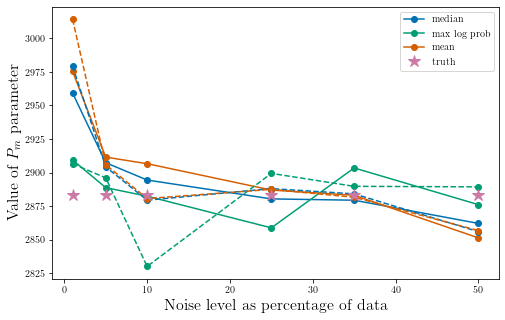

In [580]:
fig, ax = plt.subplots(1,1, figsize=(8,5))

ax.plot(noise_levels * 100, medians, marker='o', label='median')
ax.plot(noise_levels * 100, max_lps, marker='o', label='max log prob')
ax.plot(noise_levels * 100, means, marker='o', label='mean')

ax.plot(noise_levels * 100, medians_trans, marker='o', ls='--', color=colors[0])
ax.plot(noise_levels * 100, max_lps_trans, marker='o', ls='--', color=colors[1])
ax.plot(noise_levels * 100, means_trans, marker='o', ls='--', color=colors[2])

ax.plot(noise_levels * 100, pvals[p_n] * np.ones_like(noise_levels), marker='*',
                                        markersize=12, ls=' ', label='truth')

ax.legend()

ax.set_xlabel('Noise level as percentage of data', fontsize=16)
ax.set_ylabel(r'Value of $P_m$ parameter', fontsize=16)

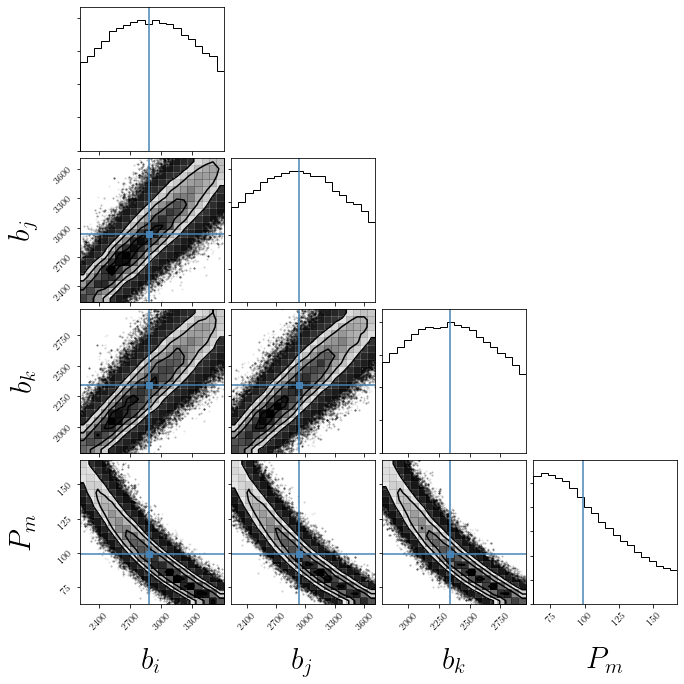

In [766]:
figure = corner.corner(samples1, truths=pvals,
                           labels=[r'$b_i$', r'$b_j$', r'$b_k$', r'$P_m$'],
                           label_kwargs={'fontsize': 30},
                          range=[.68,.68,.68,.68])

# Extract the axes
axes = np.array(figure.axes).reshape((ndim, ndim))
cmap = matplotlib.cm.get_cmap('hsv')

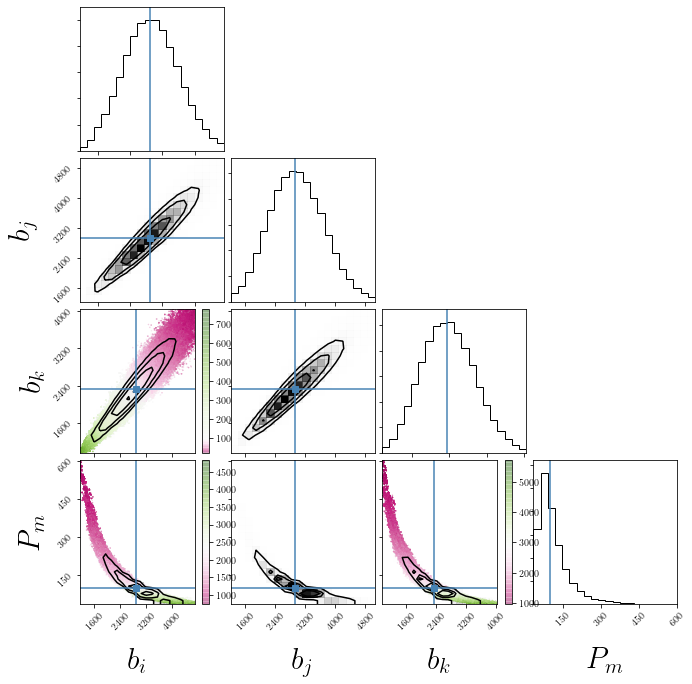

In [820]:
from matplotlib import colors

figure = corner.corner(samples1, truths=pvals,
                           labels=[r'$b_i$', r'$b_j$', r'$b_k$', r'$P_m$'],
                           label_kwargs={'fontsize': 30},
                          range=[.99,.99,.99,.99], plot_datapoints=False)

# Extract the axes
axes = np.array(figure.axes).reshape((ndim, ndim))
cmap = matplotlib.cm.get_cmap('hsv')

divnorm1=colors.TwoSlopeNorm(vcenter=pvals[3])
sc1 = axes[2,0].scatter(samples1[:,0], samples1[:,2], s=.2,
                  alpha=.2, c=samples1[:,3], norm=divnorm1, cmap='PiYG')
figure.colorbar(sc1, ax=axes[2,0])

divnorm2=colors.TwoSlopeNorm(vcenter=pvals[2])
sc2 = axes[3,0].scatter(samples1[:,0], samples1[:,3], s=.2,
                        alpha=.2, c=samples1[:,2], norm=divnorm2, cmap='PiYG')
plt.colorbar(sc2, ax=axes[3,0])

divnorm3=colors.TwoSlopeNorm(vcenter=pvals[0])
sc3 = axes[3,2].scatter(samples1[:,2], samples1[:,3], s=.2,
                        alpha=.2, c=samples1[:,0], norm=divnorm3, cmap='PiYG')

plt.colorbar(sc3, ax=axes[3,2])

#figure.savefig('projection.pdf')
#axes[2,3].annotate('local max', xy=(3, 1),  xycoords='data',
#            xytext=(0.8, 0.95), textcoords='axes fraction',
#            arrowprops=dict(facecolor='black', shrink=0.05),
#            horizontalalignment='right', verticalalignment='top',
#            )


# Loop over the diagonal
#for i in range(ndim):
#    ax = axes[i, i]
#    for l, n in enumerate(max_lp_indices):
#        ax.axvline(samples1[n,i], color=cmap(l/max_lp_indices.size), lw=.8)
        #ax.axvline(pvals[n], color="r")
        
#    for l, n in enumerate(max_P_m_indices):
#        ax.axvline(samples1[n,i], color=cmap(l/max_P_m_indices.size), ls='--', lw=.8)
    
# Loop over the histograms
#for yi in range(ndim):
#    for xi in range(yi):
#        ax = axes[yi, xi]
#        for l, n in enumerate(max_lp_indices):
#            ax.axvline(samples1[n,xi], color=cmap(l/max_lp_indices.size), lw=.8)
#            
#        for l, n in enumerate(max_P_m_indices):
#            ax.axvline(samples1[n,xi], color=cmap(l/max_P_m_indices.size), ls='--', lw=.8)

In [828]:
below = np.where(samples1[:,3] < pvals[3])
below

(array([     0,      1,      6, ..., 999992, 999993, 999995]),)

In [832]:
below = np.where(samples1[:,2] < pvals[2])
below[0].size

491287

In [829]:
above = np.where(samples1[:,3] > pvals[3])
above

(array([     2,      3,      4, ..., 999997, 999998, 999999]),)

In [833]:
above = np.where(samples1[:,2] > pvals[2])
above[0].size

508713

In [830]:
below[0].size, above[0].size

(513061, 486939)

In [774]:
samples1[:,0][0:-1:50].shape

(20000,)

In [791]:
fig2 = plt.figure()
fig2.axes.append(axes[0,0])


<Figure size 432x288 with 0 Axes>

RuntimeError: Can not put single artist in more than one figure

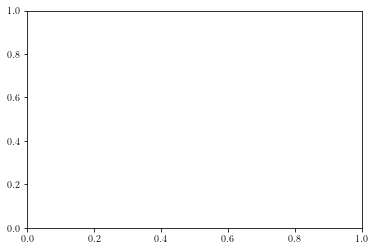

In [750]:
fig, ax = plt.subplots()

sc1 = axes[2,0].scatter(samples1[:,0][0:-1:10], samples1[:,2][0:-1:10], s=.2,
                  alpha=.1, c=samples1[:,3][0:-1:10])
plt.colorbar(sc, ax=axes[2,0])

In [757]:
H, edges = np.histogramdd(samples1, bins=20)

In [758]:
H

array([[[[   0.,    0.,    0., ..., 1034.,  877., 1426.],
         [   0.,    0.,    0., ...,    0.,    0.,    0.],
         [   0.,    0.,    0., ...,    0.,    0.,    0.],
         ...,
         [   0.,    0.,    0., ...,    0.,    0.,    0.],
         [   0.,    0.,    0., ...,    0.,    0.,    0.],
         [   0.,    0.,    0., ...,    0.,    0.,    0.]],

        [[   0.,    0.,    0., ...,    0.,    0.,    0.],
         [   0.,    0.,    0., ...,    0.,    0.,    0.],
         [   0.,    0.,    0., ...,    0.,    0.,    0.],
         ...,
         [   0.,    0.,    0., ...,    0.,    0.,    0.],
         [   0.,    0.,    0., ...,    0.,    0.,    0.],
         [   0.,    0.,    0., ...,    0.,    0.,    0.]],

        [[   0.,    0.,    0., ...,    0.,    0.,    0.],
         [   0.,    0.,    0., ...,    0.,    0.,    0.],
         [   0.,    0.,    0., ...,    0.,    0.,    0.],
         ...,
         [   0.,    0.,    0., ...,    0.,    0.,    0.],
         [   0.,    0.,   

In [736]:
def get_hist(ax):
    n,bins = [],[]
    for rect in ax.patches:
        ((x0, y0), (x1, y1)) = rect.get_bbox().get_points()
        n.append(y1-y0)
        bins.append(x0) # left edge of each bin
    bins.append(x1) # also get right edge of last bin

    return n,bins

n, bins = get_hist(axes[0,0])

print(n)
print(bins)

plt.show()


AttributeError: 'Polygon' object has no attribute 'get_bbox'

Text(0, 0.5, 'log p')

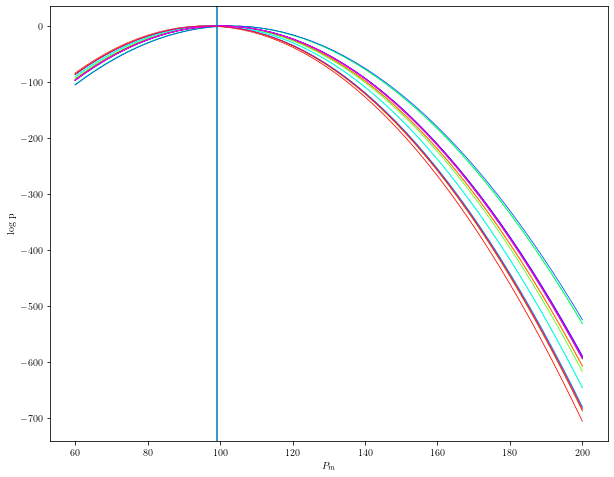

In [709]:
fig, ax = plt.subplots(figsize=(10,8))

P = np.linspace(60, 200)
N = analysis.estimate_errors(data, frac_error=noise_levels[1])

for l, n in enumerate(max_lp_indices):
    guesses = samples1[n,:]
    marg_lnp = np.zeros_like(P)
    for i in range(P.size):
        guesses_P = [*guesses[:3], P[i]]
        marg_lnp[i] = fitting.log_prob(guesses_P, params, [1], data[1:-1], model_cross,
                                                                   N[1:-1,1:-1])
    ax.plot(P, marg_lnp, color=cmap(l/max_lp_indices.size), lw=.8)
    
ax.axvline(pvals[-1])
ax.set_xlabel(r'$P_m$')
ax.set_ylabel('log p')

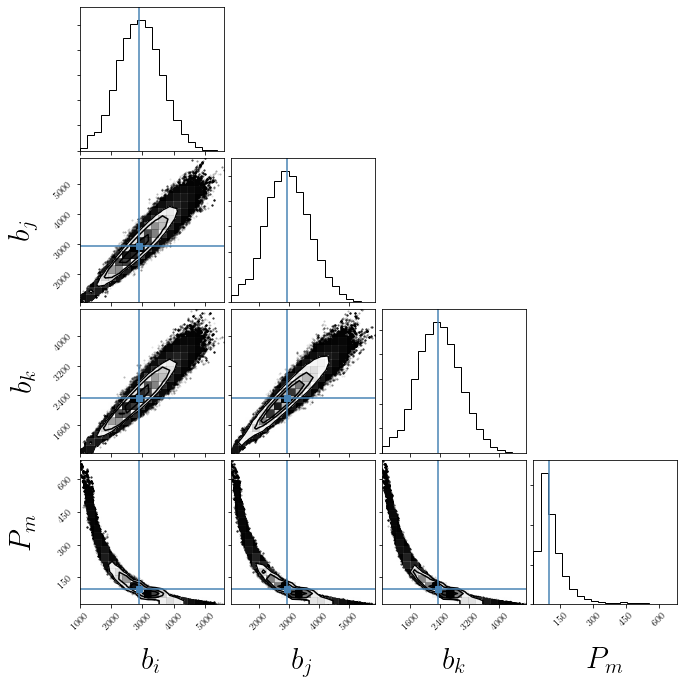

In [549]:
corner_fig = corner.corner(runs[1][0][0], truths=pvals,
                           labels=[r'$b_i$', r'$b_j$', r'$b_k$', r'$P_m$'],
                           label_kwargs={'fontsize': 30})

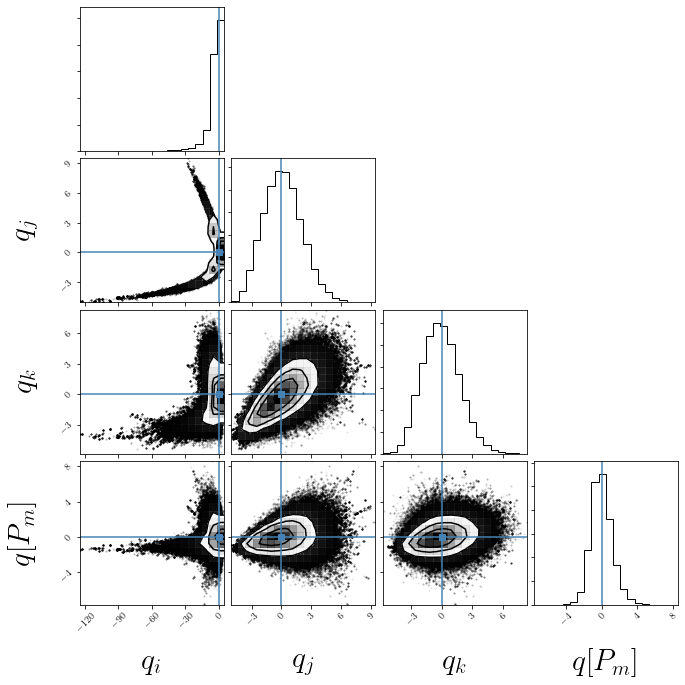

In [300]:
corner_fig_trans = corner.corner(samples_trans_low, truths=[0,0,0,0],
                                labels=[r'$q_i$', r'$q_j$', r'$q_k$', r'$q[P_m]$'],
                                label_kwargs={'fontsize': 30})

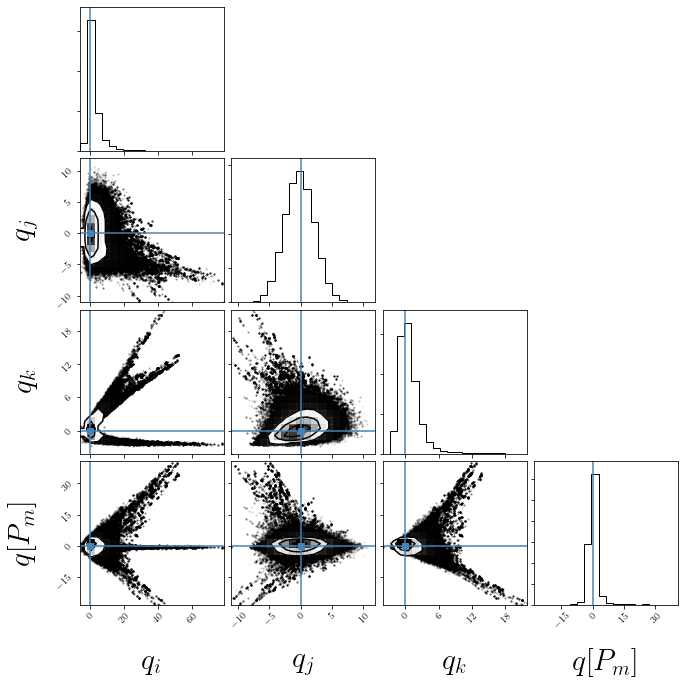

In [301]:
corner_fig_trans = corner.corner(samples_trans_high, truths=[0,0,0,0],
                                labels=[r'$q_i$', r'$q_j$', r'$q_k$', r'$q[P_m]$'],
                                label_kwargs={'fontsize': 30})

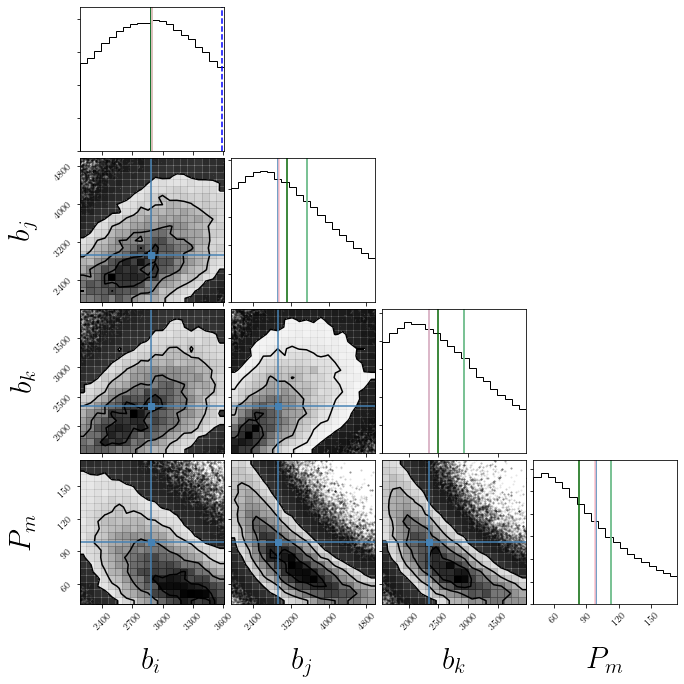

In [312]:
corner_fig_trans = corner.corner(untransform_samples(samples_trans_high,
                                        pvals, Fisher_diag_high, S_high), truths=pvals,
                           labels=[r'$b_i$', r'$b_j$', r'$b_k$', r'$P_m$'],
                           label_kwargs={'fontsize': 30},
                                range=[.68,.68,.68,.68])

axes = np.array(corner_fig_trans.axes).reshape((4, 4))

lp_high = sampler_trans_high.get_log_prob()

max_index = np.argmax(lp_high)

# Loop over the diagonal
for i in range(ndim):
    ax = axes[i, i]
    ax.axvline(np.median(untransform_samples(samples_trans_high,
                        pvals, Fisher_diag_high, S_high)[:,i]), color='darkgreen')
    ax.axvline(np.mean(untransform_samples(samples_trans_high,
                        pvals, Fisher_diag_high, S_high)[:,i]), color='darkblue')
    ax.axvline(np.mean(untransform_samples(samples_trans_high,
                        pvals, Fisher_diag_high, S_high)[:,i]), color="lightgreen")
    ax.axvline(untransform_samples(samples_trans_high,
                        pvals, Fisher_diag_high, S_high)[max_index,i], color="pink")
    ax.axvline(pvals[i] + np.sqrt(untransform_samples(samples_trans_high,
                        pvals, Fisher_diag_high, S_high)[:,i].var()), color="blue", ls='--')
    ax.axvline(pvals[i] - np.sqrt(untransform_samples(samples_trans_high,
                        pvals, Fisher_diag_high, S_high)[:,i].var()), color="blue", ls='--')

#axes[4,4].axvline(np.median(samples_22[:,4]), color='darkgreen')

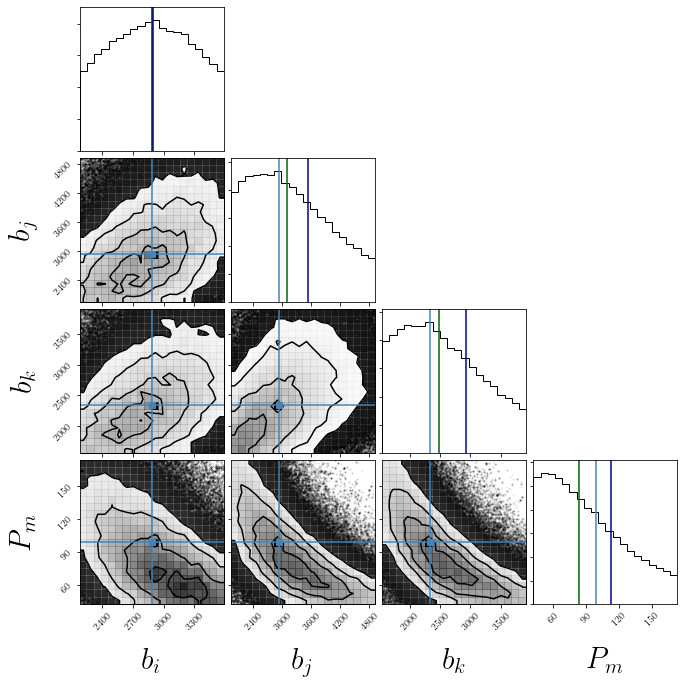

In [303]:
corner_fig = corner.corner(samples_high, truths=pvals,
                           labels=[r'$b_i$', r'$b_j$', r'$b_k$', r'$P_m$'],
                           label_kwargs={'fontsize': 30},
                           range=[.68,.68,.68,.68])

axes = np.array(corner_fig.axes).reshape((4, 4))

lp_high = sampler_high.get_log_prob()

max_index = np.argmax(lp_high)

# Loop over the diagonal
for i in range(ndim):
    ax = axes[i, i]
    ax.axvline(np.median(untransform_samples(samples_trans_high,
                                        pvals, Fisher_diag_high, S_high)[:,i]), color='darkgreen')
    ax.axvline(np.mean(untransform_samples(samples_trans_high,
                                        pvals, Fisher_diag_high, S_high)[:,i]), color='darkblue')

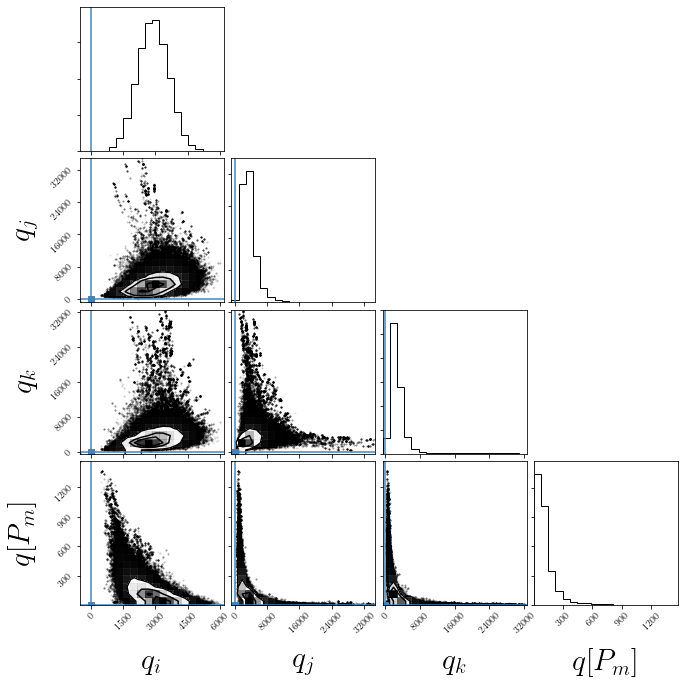

In [304]:
corner_fig_trans = corner.corner(untransform_samples(samples_trans_high, 
                                    pvals, Fisher_diag_high, S_high), truths=[0,0,0,0],
                                    labels=[r'$q_i$', r'$q_j$', r'$q_k$', r'$q[P_m]$'],
                               label_kwargs={'fontsize': 30})

In [ ]:
corner_fig_trans = corner.corner(untransform_samples(samples_trans_low,
                                        pvals, Fisher_diag_low, S_low), truths=pvals,
                           labels=[r'$b_i$', r'$b_j$', r'$b_k$', r'$P_m$'],
                           label_kwargs={'fontsize': 30})

In [ ]:
corner_fig_Fisher_diag = corner.corner(samples_Fisher_diag, truths=params_diag)

In [ ]:
samples_transformed.shape, (nwalkers * nsteps)

In [ ]:
samples_untransformed = np.zeros_like(samples_transformed)

for i in range(nwalkers * nsteps):
    samples_untransformed[i] = untransform_theta(samples_transformed[i],
                                        pvals, Fisher, S)

corner_fig_2 = corner.corner(samples_untransformed, truths=pvals)

In [ ]:
corner_fig_Fisher_transformed = corner.corner(samples_Fisher_transformed)

In [317]:
mcmc_results_sf = fitting.recover_params_mcmc(k, [1], spectra_superfake[1], model_cross,
                                    P_m, variances, priors='gaussian', N_frac_error=.1,
                                    positivity=False, priors_width=.1)

Noise level is:  10.0 % of specific_intensity
PARAMS:  [2883.0199982056624 2933.6076798800073 2340.967543617764
 array([0.00000000e+00, 9.91432762e+01, 5.70728734e+01, 7.40156501e+01,
        3.18019094e+01, 1.60424968e+01, 9.89934945e+00, 5.40108399e+00,
        2.97116482e+00, 1.58045389e+00, 8.38070921e-01, 4.42899755e-01,
        2.32886610e-01, 1.18974580e-01, 5.99164584e-02, 2.97635196e-02,
        1.42383400e-02, 5.77166379e-03, 1.63821461e-03, 0.00000000e+00])]
DATA:  [8.38519091e+08 6.80864503e+08 6.69123547e+08]
NOISE:  [7.03114266e+15 4.63576471e+15 4.47726322e+15]
running mcmc with the following settings:
fitting data from k:  [1]
prior is:  gaussian
prior width is:  0.1
positivity prior is:  False
pdf is:  gaussian
nsteps:  100000.0
no backend initialized
Mean acceptance fraction during burnin: 0.554
Mean acceptance fraction: 0.553
Mean autocorrelation time: 82.846 steps


In [318]:
mcmc_results_sf = fitting.recover_params_mcmc(k, [1], spectra_superfake[1], model_cross,
                                    P_m, variances, priors='gaussian', N_frac_error=.25,
                                    positivity=False, priors_width=.1)

Noise level is:  25.0 % of specific_intensity
PARAMS:  [2883.0199982056624 2933.6076798800073 2340.967543617764
 array([0.00000000e+00, 9.91432762e+01, 5.70728734e+01, 7.40156501e+01,
        3.18019094e+01, 1.60424968e+01, 9.89934945e+00, 5.40108399e+00,
        2.97116482e+00, 1.58045389e+00, 8.38070921e-01, 4.42899755e-01,
        2.32886610e-01, 1.18974580e-01, 5.99164584e-02, 2.97635196e-02,
        1.42383400e-02, 5.77166379e-03, 1.63821461e-03, 0.00000000e+00])]
DATA:  [8.38519091e+08 6.80864503e+08 6.69123547e+08]
NOISE:  [4.39446416e+16 2.89735294e+16 2.79828951e+16]
running mcmc with the following settings:
fitting data from k:  [1]
prior is:  gaussian
prior width is:  0.1
positivity prior is:  False
pdf is:  gaussian
nsteps:  100000.0
no backend initialized
Mean acceptance fraction during burnin: 0.503
Mean acceptance fraction: 0.494
Mean autocorrelation time: 250.620 steps


In [320]:
mcmc_results_sf = fitting.recover_params_mcmc(k, [1], spectra_superfake[1], model_cross,
                                    P_m, variances, priors='gaussian', N_frac_error=.35,
                                    positivity=False, priors_width=.1)

Noise level is:  35.0 % of specific_intensity
PARAMS:  [2883.0199982056624 2933.6076798800073 2340.967543617764
 array([0.00000000e+00, 9.91432762e+01, 5.70728734e+01, 7.40156501e+01,
        3.18019094e+01, 1.60424968e+01, 9.89934945e+00, 5.40108399e+00,
        2.97116482e+00, 1.58045389e+00, 8.38070921e-01, 4.42899755e-01,
        2.32886610e-01, 1.18974580e-01, 5.99164584e-02, 2.97635196e-02,
        1.42383400e-02, 5.77166379e-03, 1.63821461e-03, 0.00000000e+00])]
DATA:  [8.38519091e+08 6.80864503e+08 6.69123547e+08]
NOISE:  [8.61314976e+16 5.67881177e+16 5.48464744e+16]
running mcmc with the following settings:
fitting data from k:  [1]
prior is:  gaussian
prior width is:  0.1
positivity prior is:  False
pdf is:  gaussian
nsteps:  100000.0
no backend initialized
Mean acceptance fraction during burnin: 0.424
Mean acceptance fraction: 0.324


AutocorrError: The chain is shorter than 50 times the integrated autocorrelation time for 2 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 2000;
tau: [ 278.68235344 2340.9582338  2558.14914966 1318.27079299]

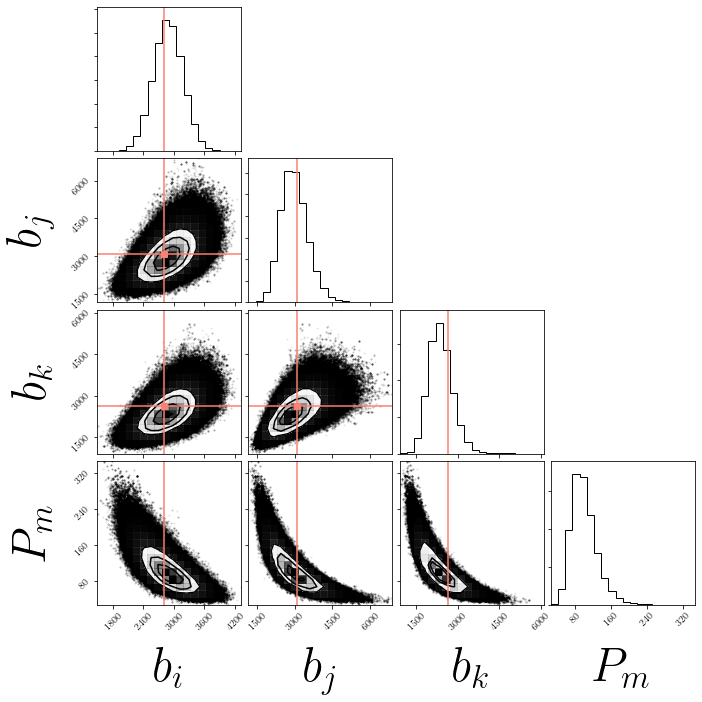

In [259]:
corner_results = corner.corner(mcmc_results_sf[0][0],
                            truths=utils.choose_params(model_params, k_indices),
                            labels=[r'$b_i$', r'$b_j$', r'$b_k$', r'$P_m$'], 
                            label_kwargs={'fontsize':48}, truth_color='salmon')

In [ ]:
mcmc_results_noise20 = fitting.recover_params_mcmc(k, [1], spectra_superfake[1], model_cross,
                                    P_m, variances, priors='gaussian',
                                    nwalkers=72, nsteps=1e6,
                                    positivity=True, priors_width=.1, noise=False)

In [ ]:
mcmc_results_sf2 = fitting.recover_params_mcmc(k, [6], spectra_superfake[1], model_cross,
                                    P_m, variances, priors='gaussian', N_frac_error=.5,
                                    positivity=True, priors_width=.1)

In [ ]:
mcmc_results = fitting.recover_params_mcmc(k, k_indices, spectra[1], model,
                                    P_m, variances, priors='gaussian',
                                    positivity=True, priors_width=.1, noise=False)

#mcmc_results_cross = fitting.recover_params_mcmc(k, k_indices, spectra[1], model_cross,
#                                    density_pspec_log, variances, priors='gaussian',
#                                    positivity=True, priors_width=.1, noise=False)

In [ ]:
mcmc_results1

In [ ]:
ndim_corner = ndim + 3

samples = mcmc_all_k_sf_pess[0][0][0]
samples_00 = analysis.add_P(samples, [1], (0,0))
samples_11 = analysis.add_P(samples_00, [1], (1,1))
samples_22 = analysis.add_P(samples_11, [1], (2,2))

corner_gaussian = corner.corner(samples_22,
            truths=[*utils.choose_params(mcmc_all_k_sf_pess[0][1], [1]), spectra[1][1][[1]],
                   spectra[1][3][[1]], spectra[1][5][[1]]],
            labels=[r'$b_i$', r'$b_j$', r'$b_k$', r'$P_m$', r'$P_{ii}$', r'$P_{jj}$', r'$P_{kk}$'],
            label_kwargs={'fontsize':48}, truth_color='salmon')

axes = np.array(corner_gaussian.axes).reshape((ndim_corner, ndim_corner))

# Loop over the diagonal
for i in range(ndim):
    ax = axes[i, i]
  #  ax.axvline(np.median(samples[:,i]), color='darkgreen')
  #  ax.axvline(np.median(samples[:,i]) - np.sqrt(samples[:,i].var()), color="lightgreen")
  #  ax.axvline(np.median(samples[:,i]) + np.sqrt(samples[:,i].var()), color="lightgreen")

axes[4,4].axvline(np.median(samples_22[:,4]), color='darkgreen')

In [ ]:
#mcmc_all_k_sf_pess = [[] for i in range(18)] 

#for ind in range(1, k.size - 1):
#    print(ind)
#mcmc_all_k_sf_pess[ind-1] = fitting.recover_params_mcmc(k, [ind], spectra_superfake[1], model_cross,
#                                  P_m, variances, priors='gaussian',
#                                   positivity=False, priors_width=.1, noise=False)

mcmc_check_converge_noise = fitting.recover_params_mcmc(k, [1], spectra_superfake[1], model_cross,
                                    P_m, variances, priors='gaussian', nsteps=1e6,
                                    nwalkers=150, positivity=False, priors_width=.1, 
                                    noise=True)

In [ ]:
mcmc_check_convergek6_noise = fitting.recover_params_mcmc(k, [6], spectra_superfake[1], model_cross,
                                    P_m, variances, priors='gaussian', nsteps=1e4,
                                    nwalkers=100, positivity=False, priors_width=.1,
                                    noise=True)

In [ ]:
np.savez('mcmc_check_converge', results=mcmc_check_converge[0],
                                params=mcmc_check_converge[1],
                                data=mcmc_check_converge[2])

In [ ]:
np.savez('mcmc_check_convergk6e', results=mcmc_check_convergek6[0],
                                params=mcmc_check_convergek6[1],
                                data=mcmc_check_convergek6[2])

In [ ]:
results, params, data

In [ ]:
mcmc_check_converge[0][0].shape

In [ ]:
ndim_corner = ndim + 6

samples = mcmc_check_converge[0][0]
samples_00 = analysis.add_P(samples, [1], (0,0))
samples_11 = analysis.add_P(samples_00, [1], (1,1))
samples_22 = analysis.add_P(samples_11, [1], (2,2))
samples_01 = analysis.add_P(samples_22, [1], (0,1))
samples_12 = analysis.add_P(samples_01, [1], (1,2))
samples_02 = analysis.add_P(samples_12, [1], (0,2))

corner_gaussian = corner.corner(samples_02,
            truths=[*utils.choose_params(mcmc_check_converge[1], [1]), *spectra[1][0][[1]],
                   *spectra[1][3][[1]], *spectra[1][5][[1]],
                   *spectra[1][1][[1]], spectra[1][4][[1]],
                   spectra[1][2][[1]]],
            labels=[r'$b_i$', r'$b_j$', r'$b_k$', r'$P_m$', r'$P_{ii}$', r'$P_{jj}$', r'$P_{kk}$',
                   r'$P_{ij}$', r'$P_{jk}$', r'$P_{ik}$'],
            label_kwargs={'fontsize':48}, truth_color='salmon')

axes = np.array(corner_gaussian.axes).reshape((ndim_corner, ndim_corner))

# Loop over the diagonal
for i in range(7,10):
    ax = axes[i, i]
    print(samples_02[:,i].var())
    ax.axvline(np.median(samples_02[:,i]), color='darkgreen')
    ax.axvline(np.median(samples_02[:,i]) - np.sqrt(samples_02[:,i].var()), color="lightgreen")
    ax.axvline(np.median(samples_02[:,i]) + np.sqrt(samples_02[:,i].var()), color="lightgreen")

In [ ]:
LSE_all_k_sf = [[] for i in range(18)] 

for ind in range(1, k.size - 1):
    LSE_all_k_sf[ind-1] = fitting.recover_params_LSE(k, [ind], spectra_superfake[1], model_cross,
                                                   P_m, variances)

In [ ]:
results, params, data = mcmc_check_converge
samples, lnprob = results

samples = samples.reshape(1000000, 150, 4)
lnprob =lnprob.reshape(1000000, 150)

In [ ]:
samples

In [ ]:
samples[:,0,2]

In [ ]:
for i in range(0,72,8):
    print(samples[:,i,1])

In [ ]:
fig = plt.figure(figsize=(12,12))
gs = fig.add_gridspec(3,2,figure=fig)
# fig, ax = plt.subplots(2, 2, figsize=(12,6))

fig_ax1 = fig.add_subplot(gs[0, 0])
fig_ax2 = fig.add_subplot(gs[0, 1])
fig_ax3 = fig.add_subplot(gs[1, 0])
fig_ax4 = fig.add_subplot(gs[1, 1])
fig_ax5 = fig.add_subplot(gs[2, :])

for i in range(0,72,8):
    fig_ax1.plot(samples[:,i,0], alpha=.2)
    fig_ax2.plot(samples[:,i,1], alpha=.2, label='walker ' + str(i))
    fig_ax3.plot(samples[:,i,2], alpha=.2)
    fig_ax4.plot(samples[:,i,3], alpha=.2)
    fig_ax5.plot(lnprob[:,i], alpha=.3)


fig_ax2.set_yscale('log')
fig_ax3.set_yscale('log')

fig.legend()

    
#ax[0].axhline(params['b_i'], color='black')
#ax[1].axhline(params['b_j'], color='black')
#ax[2].axhline(params['b_k'], color='black')
#ax[3].axhline(params['P_m'][ind], color='black')

In [ ]:
results, params, data = mcmc_check_converge_noise
samples, lnprob = results

samples = samples.reshape(1000000, 150, 4)
lnprob =lnprob.reshape(1000000, 150)

fig = plt.figure(figsize=(12,12))
gs = fig.add_gridspec(3,2,figure=fig)
# fig, ax = plt.subplots(2, 2, figsize=(12,6))

fig_ax1 = fig.add_subplot(gs[0, 0])
fig_ax2 = fig.add_subplot(gs[0, 1])
fig_ax3 = fig.add_subplot(gs[1, 0])
fig_ax4 = fig.add_subplot(gs[1, 1])
fig_ax5 = fig.add_subplot(gs[2, :])

for i in range(0,72,8):
    fig_ax1.plot(samples[:,i,0], alpha=.2)
    fig_ax2.plot(samples[:,i,1], alpha=.2, label='walker ' + str(i))
    fig_ax3.plot(samples[:,i,2], alpha=.2)
    fig_ax4.plot(samples[:,i,3], alpha=.2)
    fig_ax5.plot(lnprob[:,i], alpha=.3)


fig_ax2.set_yscale('log')
fig_ax3.set_yscale('log')

fig.legend()

    
#ax[0].axhline(params['b_i'], color='black')
#ax[1].axhline(params['b_j'], color='black')
#ax[2].axhline(params['b_k'], color='black')
#ax[3].axhline(params['P_m'][ind], color='black')

In [ ]:
corner_results = corner.corner(mcmc_check_converge[0][0],
                            truths=utils.choose_params(model_params, [1]),
                            labels=[r'$b_i$', r'$b_j$', r'$b_k$', r'$P_m$'], 
                            range=[1.0, .68, .68, .68],
                            label_kwargs={'fontsize':48}, truth_color='salmon')

In [ ]:
corner_results = corner.corner(mcmc_check_converge_noise[0][0],
                            truths=utils.choose_params(model_params, [1]),
                            labels=[r'$b_i$', r'$b_j$', r'$b_k$', r'$P_m$'], 
                            label_kwargs={'fontsize':48}, truth_color='salmon')

In [ ]:
P_21_Beane = P_21cm_CII.value[1:-1] * P_21cm_OIII.value[1:-1] / P_CII_OIII.value[1:-1]

In [ ]:
LSE_all_k_05_sf_LSE = [[] for i in range(18)] 

for ind in range(1, k.size - 1):
    LSE_all_k_05_sf_LSE[ind-1] = fitting.recover_params_LSE(k, [ind], spectra_superfake[1], model_cross,
                                                   P_m, variances, noise=False)

In [ ]:
LSE_all_k_50_sf_LSE_noise = [[] for i in range(18)] 

for ind in range(1, k.size - 1):
    LSE_all_k_50_sf_LSE_noise[ind-1] = fitting.recover_params_LSE(k, [ind], spectra_superfake[1], model_cross,
                                                   P_m, variances, noise=True)

In [ ]:
mcmc_all_k_sf[0][0][0][:,0]

In [ ]:
def recover_P21(mcmc_list):
    P_21 = np.zeros(len(mcmc_list))
    var_21 = np.zeros(len(mcmc_list))
    b_i = np.zeros(len(mcmc_list))
    P_m = np.zeros(len(mcmc_list))

    for i in range(len(mcmc_list)):
        samples = mcmc_list[i][0][0]

        samples_b_i = samples[:,0]
        samples_P_m = samples[:,3]

        P_21_samples = samples_b_i**2 * samples_P_m

        P_21[i] = np.median(P_21_samples)
        var_21[i] = np.var(P_21_samples)
        b_i[i] = np.median(samples_b_i)
        P_m[i] = np.median(samples_P_m)
        
    return P_21, var_21

def recover_P21_LSE(LSE_list):
    P_21 = np.zeros(len(LSE_list))
    var_21 = np.zeros(len(LSE_list))
    var_b_i = np.zeros(len(LSE_list))
    var_P_m = np.zeros(len(LSE_list))
    b_i = np.zeros(len(LSE_list))
    P_m = np.zeros(len(LSE_list))
    
    for i in range(len(LSE_list)):
        var_b_i[i] = np.exp(2 * LSE_list[i][0][0]) * LSE_list[i][1][0,0]
        var_P_m[i] = (np.exp(LSE_list[i][0][3]) * np.sqrt(LSE_list[i][1][3,3]))**2

        b_i[i] = np.exp(LSE_list[i][0][0])
        P_m[i] = np.exp(LSE_list[i][0][3])
    
    P_21 = b_i**2 * P_m
    var_21 = (var_b_i / b_i**2 + var_P_m / P_m**2) # * P_21
    
    return P_21, var_21

In [ ]:
fitting.log_likelihood(model_params, k_indices, data_sf[1:-1], model_cross, N[1:-1,1:-1],
                    pdf='gaussian')

In [ ]:
data_sf, model_params

In [ ]:
model_params['b_i'] * model_params['b_j'] * P_m[k_indices]

In [ ]:
b_0 = np.zeros_like(P_21_mcmc)

for i in range(len(P_21_mcmc)):
    b_0[i] = params_true[i]['b_i']

In [ ]:
variances[0] / spectra_superfake[1][0][1:]

In [ ]:
variances[0] / spectra[1][0][1:]

In [ ]:
P_21_05, var_21_05 = recover_P21(mcmc_all_k_05)
P_21_10, var_21_10 = recover_P21(mcmc_all_k_10)
P_21_25, var_21_25 = recover_P21(mcmc_all_k_25)
P_21_35, var_21_35 = recover_P21(mcmc_all_k_35)
P_21_50, var_21_50 = recover_P21(mcmc_all_k_50)
P_21_calc, var_21_calc = recover_P21(mcmc_all_k)

In [ ]:
P_21_05_sf, var_21_05_sf = recover_P21(mcmc_all_k_05_sf)
P_21_10_sf, var_21_10_sf = recover_P21(mcmc_all_k_10_sf)
P_21_15_sf, var_21_15_sf = recover_P21(mcmc_all_k_15_sf)
P_21_20_sf, var_21_20_sf = recover_P21(mcmc_all_k_20_sf)
P_21_25_sf, var_21_25_sf = recover_P21(mcmc_all_k_25_sf)
P_21_30_sf, var_21_30_sf = recover_P21(mcmc_all_k_30_sf)
P_21_35_sf, var_21_35_sf = recover_P21(mcmc_all_k_35_sf)
P_21_40_sf, var_21_40_sf = recover_P21(mcmc_all_k_40_sf)
P_21_45_sf, var_21_45_sf = recover_P21(mcmc_all_k_45_sf)
P_21_50_sf, var_21_50_sf = recover_P21(mcmc_all_k_50_sf)

In [ ]:
P_21_05_sf_noise, var_21_05_sf_noise = recover_P21(mcmc_all_k_05_sf_noise)
P_21_10_sf_noise, var_21_10_sf_noise = recover_P21(mcmc_all_k_10_sf_noise)
P_21_15_sf_noise, var_21_15_sf_noise = recover_P21(mcmc_all_k_15_sf_noise)
P_21_20_sf_noise, var_21_20_sf_noise = recover_P21(mcmc_all_k_20_sf_noise)
P_21_25_sf_noise, var_21_25_sf_noise = recover_P21(mcmc_all_k_25_sf_noise)
P_21_30_sf_noise, var_21_30_sf_noise = recover_P21(mcmc_all_k_30_sf_noise)
P_21_35_sf_noise, var_21_35_sf_noise = recover_P21(mcmc_all_k_35_sf_noise)
P_21_40_sf_noise, var_21_40_sf_noise = recover_P21(mcmc_all_k_40_sf_noise)
P_21_45_sf_noise, var_21_45_sf_noise = recover_P21(mcmc_all_k_45_sf_noise)
P_21_50_sf_noise, var_21_50_sf_noise = recover_P21(mcmc_all_k_50_sf_noise)

In [ ]:
LSE_all_k_05_sf_LSE[:]

In [ ]:
P_21_05_sf_LSE_noise, var_21_05_sf_LSE_noise = recover_P21_LSE(LSE_all_k_05_sf_LSE_noise)
P_21_05_sf_LSE, var_21_05_sf_LSE = recover_P21_LSE(LSE_all_k_05_sf_LSE)

In [ ]:
P_21_05_sf_LSE_noise, var_21_05_sf_LSE_noise = recover_P21_LSE(LSE_all_k_05_sf_LSE_noise)
P_21_10_sf_LSE_noise, var_21_10_sf_LSE_noise = recover_P21_LSE(LSE_all_k_10_sf_LSE_noise)
P_21_15_sf_LSE_noise, var_21_15_sf_LSE_noise = recover_P21_LSE(LSE_all_k_15_sf_LSE_noise)
P_21_20_sf_LSE_noise, var_21_20_sf_LSE_noise = recover_P21_LSE(LSE_all_k_20_sf_LSE_noise)
P_21_25_sf_LSE_noise, var_21_25_sf_LSE_noise = recover_P21_LSE(LSE_all_k_25_sf_LSE_noise)
P_21_30_sf_LSE_noise, var_21_30_sf_LSE_noise = recover_P21_LSE(LSE_all_k_30_sf_LSE_noise)
P_21_35_sf_LSE_noise, var_21_35_sf_LSE_noise = recover_P21_LSE(LSE_all_k_35_sf_LSE_noise)
P_21_40_sf_LSE_noise, var_21_40_sf_LSE_noise = recover_P21_LSE(LSE_all_k_40_sf_LSE_noise)
P_21_45_sf_LSE_noise, var_21_45_sf_LSE_noise = recover_P21_LSE(LSE_all_k_45_sf_LSE_noise)
P_21_50_sf_LSE_noise, var_21_50_sf_LSE_noise = recover_P21_LSE(LSE_all_k_50_sf_LSE_noise)

In [ ]:
P_21_05_sf_LSE_noise, P_21_05_sf_LSE

In [ ]:
rainbow = ['red', 'hotpink', 'orange', 'yellow', 'chartreuse', 'green', 'deepskyblue', 'blue',
              'darkviolet', 'violet']
fig, ax = plt.subplots(figsize=(10,7))

ax.errorbar(k[1:-1], spectra[1][0][1:-1] * k[1:-1]**3 / (2 * np.pi**2),
            yerr=None, label='True', color='black', lw=3)

ax.errorbar(k[1:-1], P_21_05_sf * k[1:-1]**3 / (2 * np.pi**2),
            yerr=np.sqrt(var_21_05_sf) * k[1:-1]**3 / (2 * np.pi**2),
           label=r'MCMC 5\% noise', lw=2, color=rainbow[0])

ax.errorbar(k[1:-1], P_21_10_sf * k[1:-1]**3 / (2 * np.pi**2),
            yerr=np.sqrt(var_21_10_sf) * k[1:-1]**3 / (2 * np.pi**2),
           label=r'MCMC 10\% noise', lw=2, color=rainbow[1])

ax.errorbar(k[1:-1], P_21_15_sf * k[1:-1]**3 / (2 * np.pi**2),
            yerr=np.sqrt(var_21_15_sf) * k[1:-1]**3 / (2 * np.pi**2),
           label=r'MCMC 15\% noise', lw=2, color=rainbow[2])

ax.errorbar(k[1:-1], P_21_20_sf * k[1:-1]**3 / (2 * np.pi**2),
            yerr=np.sqrt(var_21_20_sf) * k[1:-1]**3 / (2 * np.pi**2),
           label=r'MCMC 20\% noise', lw=2, color=rainbow[3])

ax.errorbar(k[1:-1], P_21_25_sf * k[1:-1]**3 / (2 * np.pi**2),
            yerr=np.sqrt(var_21_25_sf) * k[1:-1]**3 / (2 * np.pi**2),
           label=r'MCMC 25\% noise', lw=2, color=rainbow[4])

ax.errorbar(k[1:-1], P_21_30_sf * k[1:-1]**3 / (2 * np.pi**2),
            yerr=np.sqrt(var_21_30_sf) * k[1:-1]**3 / (2 * np.pi**2),
           label=r'MCMC 35\% noise', lw=2, color=rainbow[5])

ax.errorbar(k[1:-1], P_21_35_sf * k[1:-1]**3 / (2 * np.pi**2),
            yerr=np.sqrt(var_21_35_sf) * k[1:-1]**3 / (2 * np.pi**2),
           label=r'MCMC 35\% noise', lw=2, color=rainbow[6])

ax.errorbar(k[1:-1], P_21_40_sf * k[1:-1]**3 / (2 * np.pi**2),
            yerr=np.sqrt(var_21_40_sf) * k[1:-1]**3 / (2 * np.pi**2),
           label=r'MCMC 35\% noise', lw=2, color=rainbow[7])

ax.errorbar(k[1:-1], P_21_45_sf * k[1:-1]**3 / (2 * np.pi**2),
            yerr=np.sqrt(var_21_45_sf) * k[1:-1]**3 / (2 * np.pi**2),
           label=r'MCMC 35\% noise', lw=2, color=rainbow[8])

ax.errorbar(k[1:-1], P_21_50 * k[1:-1]**3 / (2 * np.pi**2),
            yerr=np.sqrt(var_21_50) * k[1:-1]**3 / (2 * np.pi**2),
           label=r'MCMC 50\% noise', lw=2, color=rainbow[9])

#ax.errorbar(k[1:-1], P_21_calc * k[1:-1]**3 / (2 * np.pi**2),
#            yerr=np.sqrt(var_21_calc) * k[1:-1]**3 / (2 * np.pi**2),
#           label=r'MCMC calculated noise', lw=2, color=rainbow[4])

ax.errorbar(k[1:-1], P_21_Beane_superfake[1:-1] * k[1:-1]**3 / (2 * np.pi**2),
            yerr=np.sqrt(var_Beane[:-1]) * k[1:-1]**3 / (2 * np.pi**2),
           label='Beane et al.', color='black', ls=':')

#ax.errorbar(k[1:-1], b_i_LSE**2 * P_m_LSE * k[1:-1]**3 / (2 * np.pi**2),
#            yerr=np.sqrt(var_21_LSE) * k[1:-1]**3 / (2 * np.pi**2),
 #          label='LSE reconstructed', ls='-')

#ax.errorbar(k[1:-1], b_i_LSE_auto**2 * P_m_LSE_auto * k[1:-1]**3 / (2 * np.pi**2),
#            yerr=np.sqrt(var_21_LSE_auto) * k[1:-1]**3 / (2 * np.pi**2),
#           label='LSE reconstructed auto', ls='-')

ax.legend()

ax.set_xlim(k[1], k[10])
#ax.set_ylim(5e4, 1e6)

ax.set_yscale('log')
ax.set_xscale('log')

In [ ]:
rainbow = ['red', 'hotpink', 'orange', 'yellow', 'chartreuse', 'green', 'deepskyblue', 'blue',
              'darkviolet', 'violet']

fig, ax = plt.subplots(figsize=(10,7))

ax.errorbar(k[1:-1], spectra[1][0][1:-1] * k[1:-1]**3 / (2 * np.pi**2),
            yerr=None, label='True', color='black', lw=3)

ax.errorbar(k[1:-1], P_21_05_sf_noise * k[1:-1]**3 / (2 * np.pi**2),
            yerr=np.sqrt(var_21_05_sf_noise) * k[1:-1]**3 / (2 * np.pi**2),
           label=r'MCMC 5\% noise', lw=2, color=rainbow[0])

ax.errorbar(k[1:-1], P_21_10_sf_noise * k[1:-1]**3 / (2 * np.pi**2),
            yerr=np.sqrt(var_21_10_sf_noise) * k[1:-1]**3 / (2 * np.pi**2),
           label=r'MCMC 10\% noise', lw=2, color=rainbow[1])

ax.errorbar(k[1:-1], P_21_15_sf_noise * k[1:-1]**3 / (2 * np.pi**2),
            yerr=np.sqrt(var_21_15_sf_noise) * k[1:-1]**3 / (2 * np.pi**2),
           label=r'MCMC 15\% noise', lw=2, color=rainbow[2])

ax.errorbar(k[1:-1], P_21_20_sf_noise * k[1:-1]**3 / (2 * np.pi**2),
            yerr=np.sqrt(var_21_20_sf_noise) * k[1:-1]**3 / (2 * np.pi**2),
           label=r'MCMC 20\% noise', lw=2, color=rainbow[3])

ax.errorbar(k[1:-1], P_21_25_sf_noise * k[1:-1]**3 / (2 * np.pi**2),
            yerr=np.sqrt(var_21_25_sf_noise) * k[1:-1]**3 / (2 * np.pi**2),
           label=r'MCMC 25\% noise', lw=2, color=rainbow[4])

ax.errorbar(k[1:-1], P_21_30_sf_noise * k[1:-1]**3 / (2 * np.pi**2),
            yerr=np.sqrt(var_21_30_sf_noise) * k[1:-1]**3 / (2 * np.pi**2),
           label=r'MCMC 35\% noise', lw=2, color=rainbow[5])

ax.errorbar(k[1:-1], P_21_35_sf_noise * k[1:-1]**3 / (2 * np.pi**2),
            yerr=np.sqrt(var_21_35_sf_noise) * k[1:-1]**3 / (2 * np.pi**2),
           label=r'MCMC 35\% noise', lw=2, color=rainbow[6])

ax.errorbar(k[1:-1], P_21_40_sf_noise * k[1:-1]**3 / (2 * np.pi**2),
            yerr=np.sqrt(var_21_40_sf_noise) * k[1:-1]**3 / (2 * np.pi**2),
           label=r'MCMC 35\% noise', lw=2, color=rainbow[7])

ax.errorbar(k[1:-1], P_21_45_sf_noise * k[1:-1]**3 / (2 * np.pi**2),
            yerr=np.sqrt(var_21_45_sf_noise) * k[1:-1]**3 / (2 * np.pi**2),
           label=r'MCMC 35\% noise', lw=2, color=rainbow[8])

ax.errorbar(k[1:-1], P_21_50 * k[1:-1]**3 / (2 * np.pi**2),
            yerr=np.sqrt(var_21_50) * k[1:-1]**3 / (2 * np.pi**2),
           label=r'MCMC 50\% noise', lw=2, color=rainbow[9])

#ax.errorbar(k[1:-1], P_21_calc * k[1:-1]**3 / (2 * np.pi**2),
#            yerr=np.sqrt(var_21_calc) * k[1:-1]**3 / (2 * np.pi**2),
#           label=r'MCMC calculated noise', lw=2, color=rainbow[4])

ax.errorbar(k[1:-1], P_21_Beane_superfake[1:-1] * k[1:-1]**3 / (2 * np.pi**2),
            yerr=np.sqrt(var_Beane[:-1]) * k[1:-1]**3 / (2 * np.pi**2),
           label='Beane et al.', color='black', ls=':')

#ax.errorbar(k[1:-1], b_i_LSE**2 * P_m_LSE * k[1:-1]**3 / (2 * np.pi**2),
#            yerr=np.sqrt(var_21_LSE) * k[1:-1]**3 / (2 * np.pi**2),
 #          label='LSE reconstructed', ls='-')

#ax.errorbar(k[1:-1], b_i_LSE_auto**2 * P_m_LSE_auto * k[1:-1]**3 / (2 * np.pi**2),
#            yerr=np.sqrt(var_21_LSE_auto) * k[1:-1]**3 / (2 * np.pi**2),
#           label='LSE reconstructed auto', ls='-')

ax.legend()

ax.set_xlim(k[1], k[10])
#ax.set_ylim(5e4, 1e6)

ax.set_yscale('log')
ax.set_xscale('log')

In [ ]:
k_indices, ind

In [ ]:
model_cross.pspec(k_indices), model_cross.pspec([ind])

In [ ]:
def plot_lklhd(which_p, p_range, ind, model=model_cross):
    biases_sf = utils.extract_bias([ind], spectra_superfake[1], P_m)
    p_names = np.asarray(['b_i','b_j', 'b_k', 'P_m'])
    p_vals = np.asarray([*biases_sf, P_m], dtype=object)

    p_truths = dict(zip(p_names, p_vals))

    lklhd = np.zeros_like(p_range)
    p_test = cp.deepcopy(p_truths)
    
    if which_p is not 'P_m':
        for i, p in enumerate(p_range):
            p_test[which_p] = p
            #print(p_test)
            data = model.pspec([ind], params=p_truths)
          #  print('data:  ', data)
          #  print('model: ', model.pspec([ind], params=p_test))

            lklhd[i] = fitting.log_likelihood(p_test, [ind], data,
                                        model, N[1:-1,1:-1], pdf='gaussian')
            
    if which_p is 'P_m':
        for i, p in enumerate(p_range):
            p_test[which_p][[ind]] = p
            data = model.pspec([ind], params=p_truths)

            lklhd[i] = fitting.log_likelihood(p_test, [ind], data,
                                        model, N[1:-1,1:-1], pdf='gaussian')
        
    return lklhd

def plot_lnprob(which_p, p_range, ind, model=model_cross):
    biases_sf = utils.extract_bias([ind], spectra_superfake[1], P_m)
    p_names = np.asarray(['b_i','b_j', 'b_k', 'P_m'])
    p_vals = np.asarray([*biases_sf, P_m], dtype=object)

    p_truths = dict(zip(p_names, p_vals))
    guesses = [p_truths['b_i'], p_truths['b_j'], p_truths['b_k'], p_truths['P_m'][ind]]
    lnprob = np.zeros_like(p_range)

    for i, p in enumerate(p_range):
        guesses[which_p] = p

        param_guesses = copy.deepcopy(p_truths)

        for j, (names, vals) in enumerate(p_truths.items()):
            if names != 'P_m':
                param_guesses[names] = guesses[j]

            if names == 'P_m':
                P_m_params = guesses[j:]
                for l, k in enumerate([ind]):
                    param_guesses['P_m'][k] = P_m_params[l]
                        
        data = model.pspec([ind], params=p_truths)
        #print(param_guesses)
        #print('data:  ', data)
        #print('model: ', model.pspec([ind], params=param_guesses))

        lnprob[i] = fitting.log_probability(guesses, p_truths, [ind], data,
                                    model, N[1:-1,1:-1], pdf='gaussian')

    return lnprob

In [ ]:
fig, ax = plt.subplots(3,2, figsize=(10,12))

ax = ax.flatten()

ind = 1
biases_sf = utils.extract_bias([ind], spectra_superfake[1], P_m)
p_names = np.asarray(['b_i','b_j', 'b_k', 'P_m'])
p_vals = np.asarray([*biases_sf, P_m], dtype=object)

p_truths = dict(zip(p_names, p_vals))

samples = mcmc_all_k_sf[ind - 1][0][0]

i_range = np.linspace(samples[:,0].min(), samples[:,0].max())
j_range = np.linspace(samples[:,1].min(), samples[:,1].max())
k_range = np.linspace(samples[:,2].min(), samples[:,2].max())
P_m_range = np.linspace(samples[:,3].min(), samples[:,3].max())

lkhd_i = plot_lklhd('b_i', i_range, ind)
lkhd_j = plot_lklhd('b_j', j_range, ind)
lkhd_k = plot_lklhd('b_k', k_range, ind)
lkhd_P_m = plot_lklhd('P_m', P_m_range, ind)

lnprob_i = plot_lnprob(0, i_range, ind)
lnprob_j = plot_lnprob(1, j_range, ind)
lnprob_k = plot_lnprob(2, k_range, ind)
lnprob_P_m = plot_lnprob(3, P_m_range, ind)

#ax[0].plot(i_range, lkhd_i)
#ax[1].plot(j_range, lkhd_j)
#ax[2].plot(k_range, lkhd_k)
#ax[3].plot(P_m_range, lkhd_P_m)
#ax[4].plot(j_range, lkhd_j)
#ax[5].plot(k_range, lkhd_k)

ax[0].plot(i_range, lnprob_i)
ax[1].plot(j_range, lnprob_j)
ax[2].plot(k_range, lnprob_k)
ax[3].plot(P_m_range, lnprob_P_m)
ax[4].plot(j_range, lnprob_j)
ax[5].plot(k_range, lnprob_k)

ax[0].axvline(p_truths['b_i'], color='black')
ax[1].axvline(p_truths['b_j'], color='black', label='Truths')
ax[2].axvline(p_truths['b_k'], color='black')
ax[3].axvline(p_truths['P_m'][ind], color='black')
ax[4].axvline(p_truths['b_j'], color='black')
ax[5].axvline(p_truths['b_k'], color='black')

ax[0].axvline(mcmc_samples[mcmc_lnprob.argmax(),0], color='gold')
ax[1].axvline(mcmc_samples[mcmc_lnprob.argmax(),1], color='gold', label='maximum likelihood')
ax[2].axvline(mcmc_samples[mcmc_lnprob.argmax(),2], color='gold')
ax[3].axvline(mcmc_samples[mcmc_lnprob.argmax(),3], color='gold')
ax[4].axvline(mcmc_samples[mcmc_lnprob.argmax(),1], color='gold')
ax[5].axvline(mcmc_samples[mcmc_lnprob.argmax(),2], color='gold')

ax[0].axvline(np.median(mcmc_samples[:,0]), color='red', alpha=.5)
ax[1].axvline(np.median(mcmc_samples[:,1]), color='red', alpha=.5, label='median')
ax[2].axvline(np.median(mcmc_samples[:,2]), color='red', alpha=.5)
ax[3].axvline(np.median(mcmc_samples[:,3]), color='red', alpha=.5)
ax[4].axvline(np.median(mcmc_samples[:,1]), color='red', alpha=.5)
ax[5].axvline(np.median(mcmc_samples[:,2]), color='red', alpha=.5)

ax[0].axvline(np.mean(mcmc_samples[:,0]), color='blue', alpha=.5)
ax[1].axvline(np.mean(mcmc_samples[:,1]), color='blue', alpha=.5, label='mean')
ax[2].axvline(np.mean(mcmc_samples[:,2]), color='blue', alpha=.5)
ax[3].axvline(np.mean(mcmc_samples[:,3]), color='blue', alpha=.5)
ax[4].axvline(np.mean(mcmc_samples[:,1]), color='blue', alpha=.5)
ax[5].axvline(np.mean(mcmc_samples[:,2]), color='blue', alpha=.5)


ax[4].set_xlim(p_truths['b_j'] - 3 * p_truths['b_j'], p_truths['b_j'] + 1200 * p_truths['b_j'])
ax[5].set_xlim(p_truths['b_k'] - 3 * p_truths['b_k'], p_truths['b_k'] + 200 * p_truths['b_k'])

ax[1].legend()              
              
fig.tight_layout()

In [ ]:
biases_sf[1] / np.median(mcmc_samples[:,1])

In [ ]:
MLE_params = mcmc_all_k_sf[0]

In [ ]:
mcmc_samples = mcmc_all_k_sf[0][0][0]
mcmc_lnprob = mcmc_all_k_sf[0][0][1].flatten()

In [ ]:
mcmc_samples.shape

In [ ]:
mcmc_samples[mcmc_lnprob.argmax(),:]

In [ ]:
fig, ax = plt.subplots(3,2, figsize=(10,12))

ax = ax.flatten()

ind = 1
biases_sf = utils.extract_bias([ind], spectra_superfake[1], P_m)
p_names = np.asarray(['b_i','b_j', 'b_k', 'P_m'])
p_vals = np.asarray([*biases_sf, P_m], dtype=object)

p_truths = dict(zip(p_names, p_vals))

samples = mcmc_all_k_sf[ind - 1][0][0]

i_range = np.linspace(samples[:,0].min(), samples[:,0].max())
j_range = np.linspace(samples[:,1].min(), samples[:,1].max())
k_range = np.linspace(samples[:,2].min(), samples[:,2].max())
P_m_range = np.linspace(samples[:,3].min(), samples[:,3].max())

lkhd_i = plot_lklhd('b_i', i_range, ind)
lkhd_j = plot_lklhd('b_j', j_range, ind)
lkhd_k = plot_lklhd('b_k', k_range, ind)
lkhd_P_m = plot_lklhd('P_m', P_m_range, ind)

lnprob_i = plot_lnprob(0, i_range, ind)
lnprob_j = plot_lnprob(1, j_range, ind)
lnprob_k = plot_lnprob(2, k_range, ind)
lnprob_P_m = plot_lnprob(3, P_m_range, ind)

ax[0].plot(i_range, lkhd_i)
ax[1].plot(j_range, lkhd_j)
ax[2].plot(k_range, lkhd_k)
ax[3].plot(P_m_range, lkhd_P_m)
ax[4].plot(j_range, lkhd_j)
ax[5].plot(k_range, lkhd_k)

#ax[0].plot(i_range, lkhd2_i)
#ax[1].plot(j_range, lkhd2_j)
#ax[2].plot(k_range, lkhd2_k)
#ax[3].plot(P_m_range, lkhd2_P_m)

ax[0].plot(i_range, lnprob_i)
ax[1].plot(j_range, lnprob_j)
ax[2].plot(k_range, lnprob_k)
ax[3].plot(P_m_range, lnprob_P_m)
ax[4].plot(j_range, lnprob_j)
ax[5].plot(k_range, lnprob_k)

#ax[0].plot(i_range_pess, lkhd_i_pess)
#ax[1].plot(j_range_pess, lkhd_j_pess)
#ax[2].plot(k_range_pess, lkhd_k_pess)
#ax[3].plot(P_m_range_pess, lkhd_P_m_pess)
#ax[4].plot(j_range_pess, lkhd_j_pess)
#ax[5].plot(k_range_pess, lkhd_k_pess)

ax[0].plot(i_range_pess, lnprob_i_pess, alpha=.2)
ax[1].plot(j_range_pess, lnprob_j_pess, alpha=.2)
ax[2].plot(k_range_pess, lnprob_k_pess, alpha=.2)
ax[3].plot(P_m_range_pess, lnprob_P_m_pess, alpha=.2)
ax[4].plot(j_range_pess, lnprob_j_pess, alpha=.2)
ax[5].plot(k_range_pess, lnprob_k_pess, alpha=.2)

ax[0].axvline(p_truths['b_i'], color='black')
ax[1].axvline(p_truths['b_j'], color='black')
ax[2].axvline(p_truths['b_k'], color='black')
ax[3].axvline(p_truths['P_m'][ind], color='black')
ax[4].axvline(p_truths['b_j'], color='black')
ax[5].axvline(p_truths['b_k'], color='black')

ax[4].set_xlim(p_truths['b_j'] - .25 * p_truths['b_j'], p_truths['b_j'] + .25 * p_truths['b_j'])
ax[5].set_xlim(p_truths['b_k'] - .25 * p_truths['b_k'], p_truths['b_k'] + .25 * p_truths['b_k'])

fig.tight_layout()

In [ ]:
fig, ax = plt.subplots(3,2, figsize=(10,12))

ax = ax.flatten()

ind = 1
biases_sf = utils.extract_bias([ind], spectra_superfake[1], P_m)
p_names = np.asarray(['b_i','b_j', 'b_k', 'P_m'])
p_vals = np.asarray([*biases_sf, P_m], dtype=object)

p_truths = dict(zip(p_names, p_vals))

samples = mcmc_all_k_sf_pess[ind - 1][0][0]

i_range_pess = np.linspace(samples[:,0].min(), samples[:,0].max())
j_range_pess = np.linspace(samples[:,1].min(), samples[:,1].max())
k_range_pess = np.linspace(samples[:,2].min(), samples[:,2].max())
P_m_range_pess = np.linspace(samples[:,3].min(), samples[:,3].max())

lkhd_i_pess = plot_lklhd('b_i', i_range, ind)
lkhd_j_pess = plot_lklhd('b_j', j_range, ind)
lkhd_k_pess = plot_lklhd('b_k', k_range, ind)
lkhd_P_m_pess = plot_lklhd('P_m', P_m_range, ind)

lnprob_i_pess = plot_lnprob(0, i_range, ind)
lnprob_j_pess = plot_lnprob(1, j_range, ind)
lnprob_k_pess = plot_lnprob(2, k_range, ind)
lnprob_P_m_pess = plot_lnprob(3, P_m_range, ind)

ax[0].plot(i_range_pess, lkhd_i_pess)
ax[1].plot(j_range_pess, lkhd_j_pess)
ax[2].plot(k_range_pess, lkhd_k_pess)
ax[3].plot(P_m_range_pess, lkhd_P_m_pess)
ax[4].plot(j_range_pess, lkhd_j_pess)
ax[5].plot(k_range_pess, lkhd_k_pess)

#ax[0].plot(i_range, lkhd2_i)
#ax[1].plot(j_range, lkhd2_j)
#ax[2].plot(k_range, lkhd2_k)
#ax[3].plot(P_m_range, lkhd2_P_m)

ax[0].plot(i_range_pess, lnprob_i_pess)
ax[1].plot(j_range_pess, lnprob_j_pess)
ax[2].plot(k_range_pess, lnprob_k_pess)
ax[3].plot(P_m_range_pess, lnprob_P_m_pess)
ax[4].plot(j_range_pess, lnprob_j_pess)
ax[5].plot(k_range_pess, lnprob_k_pess)

ax[0].axvline(p_truths['b_i'], color='black')
ax[1].axvline(p_truths['b_j'], color='black')
ax[2].axvline(p_truths['b_k'], color='black')
ax[3].axvline(p_truths['P_m'][ind], color='black')
ax[4].axvline(p_truths['b_j'], color='black')
ax[5].axvline(p_truths['b_k'], color='black')

ax[4].set_xlim(p_truths['b_j'] - .25 * p_truths['b_j'], p_truths['b_j'] + .25 * p_truths['b_j'])
ax[5].set_xlim(p_truths['b_k'] - .25 * p_truths['b_k'], p_truths['b_k'] + .25 * p_truths['b_k'])

fig.tight_layout()

In [ ]:
P_m_range

In [ ]:
P_21_mcmc, var_21_mcmc = recover_P21(mcmc_all_k_sf)
P_21_mcmc_pess, var_21_mcmc_pess = recover_P21(mcmc_all_k_sf_pess)
P_21_LSE, var_21_LSE = recover_P21_LSE(LSE_all_k_sf)

rainbow = ['red', 'hotpink', 'orange', 'yellow', 'chartreuse', 'green', 'deepskyblue', 'blue',
              'darkviolet', 'violet']

fig, ax = plt.subplots(figsize=(10,7))

ax.errorbar(k[1:-1], spectra_superfake[1][0][1:-1] * k[1:-1]**3 / (2 * np.pi**2),
            yerr=None, label='True', color='black', lw=3)

ax.errorbar(k[1:-1], P_21_mcmc * k[1:-1]**3 / (2 * np.pi**2),
            yerr=np.sqrt(var_21_mcmc) * k[1:-1]**3 / (2 * np.pi**2),
           label=r'MCMC', lw=2)

ax.errorbar(k[1:-1], P_21_LSE * k[1:-1]**3 / (2 * np.pi**2),
            yerr=np.sqrt(var_21_LSE) * k[1:-1]**3 / (2 * np.pi**2),
           label=r'LSE', lw=2)

ax.errorbar(k[1:-1], P_21_mcmc_pess * k[1:-1]**3 / (2 * np.pi**2),
            yerr=np.sqrt(var_21_mcmc_pess) * k[1:-1]**3 / (2 * np.pi**2),
           label=r'MCMC no positivity prior', lw=2)

ax.legend()

ax.set_xlim(k[1], k[10])
ax.set_ylim(5e4, 1e6)

ax.set_yscale('log')
ax.set_xscale('log')

In [ ]:
rainbow = ['red', 'hotpink', 'orange', 'yellow', 'chartreuse', 'green', 'deepskyblue', 'blue',
              'darkviolet', 'violet']
fig, ax = plt.subplots(figsize=(10,7))

ax.errorbar(k[1:-1], spectra[1][0][1:-1] * k[1:-1]**3 / (2 * np.pi**2),
            yerr=None, label='True', color='black', lw=3)

ax.errorbar(k[1:-1], P_21_05_sf_LSE_noise * k[1:-1]**3 / (2 * np.pi**2),
            yerr=np.sqrt(var_21_05_sf_LSE_noise) * k[1:-1]**3 / (2 * np.pi**2),
           label=r'LSE 5\% noise', lw=2, color=rainbow[0])

ax.errorbar(k[1:-1], P_21_10_sf_LSE_noise * k[1:-1]**3 / (2 * np.pi**2),
            yerr=np.sqrt(var_21_10_sf_LSE_noise) * k[1:-1]**3 / (2 * np.pi**2),
           label=r'LSE 10\% noise', lw=2, color=rainbow[1])

ax.errorbar(k[1:-1], P_21_15_sf_LSE_noise * k[1:-1]**3 / (2 * np.pi**2),
            yerr=np.sqrt(var_21_15_sf_LSE_noise) * k[1:-1]**3 / (2 * np.pi**2),
           label=r'LSE 15\% noise', lw=2, color=rainbow[2])

ax.errorbar(k[1:-1], P_21_20_sf_LSE_noise * k[1:-1]**3 / (2 * np.pi**2),
            yerr=np.sqrt(var_21_20_sf_LSE_noise) * k[1:-1]**3 / (2 * np.pi**2),
           label=r'LSE 20\% noise', lw=2, color=rainbow[3])

ax.errorbar(k[1:-1], P_21_25_sf_LSE_noise * k[1:-1]**3 / (2 * np.pi**2),
            yerr=np.sqrt(var_21_25_sf_LSE_noise) * k[1:-1]**3 / (2 * np.pi**2),
           label=r'LSE 25\% noise', lw=2, color=rainbow[4])

ax.errorbar(k[1:-1], P_21_30_sf_LSE_noise * k[1:-1]**3 / (2 * np.pi**2),
            yerr=np.sqrt(var_21_30_sf_LSE_noise) * k[1:-1]**3 / (2 * np.pi**2),
           label=r'LSE 35\% noise', lw=2, color=rainbow[5])

ax.errorbar(k[1:-1], P_21_35_sf_LSE_noise * k[1:-1]**3 / (2 * np.pi**2),
            yerr=np.sqrt(var_21_35_sf_LSE_noise) * k[1:-1]**3 / (2 * np.pi**2),
           label=r'LSE 35\% noise', lw=2, color=rainbow[6])

ax.errorbar(k[1:-1], P_21_40_sf_LSE_noise * k[1:-1]**3 / (2 * np.pi**2),
            yerr=np.sqrt(var_21_40_sf_LSE_noise) * k[1:-1]**3 / (2 * np.pi**2),
           label=r'LSE 35\% noise', lw=2, color=rainbow[7])

ax.errorbar(k[1:-1], P_21_45_sf_LSE_noise * k[1:-1]**3 / (2 * np.pi**2),
            yerr=np.sqrt(var_21_45_sf_LSE_noise) * k[1:-1]**3 / (2 * np.pi**2),
           label=r'LSE 35\% noise', lw=2, color=rainbow[8])

ax.errorbar(k[1:-1], P_21_50 * k[1:-1]**3 / (2 * np.pi**2),
            yerr=np.sqrt(var_21_50) * k[1:-1]**3 / (2 * np.pi**2),
           label=r'LSE 50\% noise', lw=2, color=rainbow[9])

#ax.errorbar(k[1:-1], P_21_calc * k[1:-1]**3 / (2 * np.pi**2),
#            yerr=np.sqrt(var_21_calc) * k[1:-1]**3 / (2 * np.pi**2),
#           label=r'LSE calculated noise', lw=2, color=rainbow[4])

ax.errorbar(k[1:-1], P_21_Beane_superfake[1:-1] * k[1:-1]**3 / (2 * np.pi**2),
            yerr=np.sqrt(var_Beane[:-1]) * k[1:-1]**3 / (2 * np.pi**2),
           label='Beane et al.', color='black', ls=':')

#ax.errorbar(k[1:-1], b_i_LSE**2 * P_m_LSE * k[1:-1]**3 / (2 * np.pi**2),
#            yerr=np.sqrt(var_21_LSE) * k[1:-1]**3 / (2 * np.pi**2),
 #          label='LSE reconstructed', ls='-')

#ax.errorbar(k[1:-1], b_i_LSE_auto**2 * P_m_LSE_auto * k[1:-1]**3 / (2 * np.pi**2),
#            yerr=np.sqrt(var_21_LSE_auto) * k[1:-1]**3 / (2 * np.pi**2),
#           label='LSE reconstructed auto', ls='-')

ax.legend()

ax.set_xlim(k[1], k[10])
#ax.set_ylim(5e4, 1e6)

ax.set_yscale('log')
ax.set_xscale('log')

In [ ]:
rainbow = ['red', 'orange', 'yellow', 'green', 'blue', 'purple']
fig, ax = plt.subplots(figsize=(10,7))

ax.errorbar(k[1:-1], spectra[1][0][1:-1] * k[1:-1]**3 / (2 * np.pi**2),
            yerr=np.sqrt(var_21cm_21cm[:-1].value) * k[1:-1]**3 / (2 * np.pi**2),
           label='True', color='black', lw=3)

ax.errorbar(k[1:-1], P_21_05 * k[1:-1]**3 / (2 * np.pi**2),
            yerr=np.sqrt(var_21_05) * k[1:-1]**3 / (2 * np.pi**2),
           label=r'MCMC 5\% noise', lw=2, color=rainbow[0])

ax.errorbar(k[1:-1], P_21_10 * k[1:-1]**3 / (2 * np.pi**2),
            yerr=np.sqrt(var_21_10) * k[1:-1]**3 / (2 * np.pi**2),
           label=r'MCMC 10\% noise', lw=2, color=rainbow[1])

ax.errorbar(k[1:-1], P_21_25 * k[1:-1]**3 / (2 * np.pi**2),
            yerr=np.sqrt(var_21_25) * k[1:-1]**3 / (2 * np.pi**2),
           label=r'MCMC 25\% noise', lw=2, color=rainbow[2])

ax.errorbar(k[1:-1], P_21_35 * k[1:-1]**3 / (2 * np.pi**2),
            yerr=np.sqrt(var_21_35) * k[1:-1]**3 / (2 * np.pi**2),
           label=r'MCMC 35\% noise', lw=2, color=rainbow[3])

ax.errorbar(k[1:-1], P_21_50 * k[1:-1]**3 / (2 * np.pi**2),
            yerr=np.sqrt(var_21_50) * k[1:-1]**3 / (2 * np.pi**2),
           label=r'MCMC 50\% noise', lw=2, color=rainbow[5])

ax.errorbar(k[1:-1], P_21_calc * k[1:-1]**3 / (2 * np.pi**2),
            yerr=np.sqrt(var_21_calc) * k[1:-1]**3 / (2 * np.pi**2),
           label=r'MCMC calculated noise', lw=2, color=rainbow[4])

ax.errorbar(k[1:-1], P_21_Beane * k[1:-1]**3 / (2 * np.pi**2),
            yerr=np.sqrt(var_Beane[:-1]) * k[1:-1]**3 / (2 * np.pi**2),
           label='Beane et al.', color='black', ls=':')

#ax.errorbar(k[1:-1], b_i_LSE**2 * P_m_LSE * k[1:-1]**3 / (2 * np.pi**2),
#            yerr=np.sqrt(var_21_LSE) * k[1:-1]**3 / (2 * np.pi**2),
 #          label='LSE reconstructed', ls='-')

#ax.errorbar(k[1:-1], b_i_LSE_auto**2 * P_m_LSE_auto * k[1:-1]**3 / (2 * np.pi**2),
#            yerr=np.sqrt(var_21_LSE_auto) * k[1:-1]**3 / (2 * np.pi**2),
#           label='LSE reconstructed auto', ls='-')

ax.legend()

ax.set_xlim(k[1], k[10])
ax.set_ylim(1e3, 1e6)

ax.set_yscale('log')
ax.set_xscale('log')

In [ ]:
fig, ax = plt.subplots(figsize=(10,7))

ax.errorbar(k[1:-1], P_21cm_21cm.value[1:-1] * k[1:-1]**3 / (2 * np.pi**2),
            yerr=np.sqrt(var_21cm_21cm[:-1].value) * k[1:-1]**3 / (2 * np.pi**2),
           label='True')

ax.errorbar(k[1:-1], P_21_10 * k[1:-1]**3 / (2 * np.pi**2),
            yerr=np.sqrt(var_21_mcmc) * k[1:-1]**3 / (2 * np.pi**2),
           label='MCMC reconstructed median', lw=2)

ax.errorbar(k[1:-1], P_21_mcmc_mean * k[1:-1]**3 / (2 * np.pi**2),
            yerr=np.sqrt(var_21_mcmc) * k[1:-1]**3 / (2 * np.pi**2),
           label='MCMC reconstructed mean', lw=2)

ax.errorbar(k[1:-1], P_21_mcmc_auto * k[1:-1]**3 / (2 * np.pi**2),
            yerr=np.sqrt(var_21_mcmc_auto) * k[1:-1]**3 / (2 * np.pi**2),
           label='MCMC auto reconstructed', lw=2)

ax.errorbar(k[1:-1], P_21cm_CII.value[1:-1] * P_21cm_OIII.value[1:-1] / P_CII_OIII.value[1:-1] * k[1:-1]**3 / (2 * np.pi**2),
            yerr=np.sqrt(var_Beane[:-1]) * k[1:-1]**3 / (2 * np.pi**2),
           label='Beane et al.')

ax.errorbar(k[1:-1], b_i_LSE**2 * P_m_LSE * k[1:-1]**3 / (2 * np.pi**2),
            yerr=np.sqrt(var_21_LSE) * k[1:-1]**3 / (2 * np.pi**2),
           label='LSE reconstructed', ls='-')

ax.errorbar(k[1:-1], b_i_LSE_auto**2 * P_m_LSE_auto * k[1:-1]**3 / (2 * np.pi**2),
            yerr=np.sqrt(var_21_LSE_auto) * k[1:-1]**3 / (2 * np.pi**2),
           label='LSE reconstructed auto', ls='-')

ax.legend()

ax.set_yscale('log')
ax.set_xscale('log')

In [ ]:
fig, ax = plt.subplots()

ax.plot(k[1:-1], b_0, marker='.')
ax.plot(k[1:-1], b_i_mcmc)
ax.plot(k[1:-1], b_i_LSE)

ax.fill_between(k[1:-1], b_0 + b_0 * .1 , b_0 - b_0 * .1, alpha=.1, facecolor=colors[0])
ax.fill_between(k[1:-1], b_0 + b_0 * .2 , b_0 + b_0 * .1, alpha=.1, facecolor=colors[1])
ax.fill_between(k[1:-1], b_0 - b_0 * .2 , b_0 - b_0 * .1, alpha=.1, facecolor=colors[1])

ax.set_xscale('log')

In [ ]:
fig, ax = plt.subplots(figsize=(10,7))

ax.plot(k[1:-1], frac_diff(P_21cm_21cm.value[1:-1]),
           label='True')

ax.plot(k[1:-1], frac_diff(b_0**2 * P_m[1:-1]),
           label='True from Crosscorrelations')

ax.plot(k[1:-1], frac_diff(P_21_mcmc),
           label='MCMC reconstructed')

ax.plot(k[1:-1], frac_diff(P_21_Beane),
           label='Beane et al.')

ax.plot(k[1:-1], frac_diff(b_i_mcmc**2 * P_m_mcmc),
           label='MCMC params')


ax.set_ylim(-1e-2, 2)

ax.legend()

In [ ]:
P_21_Beane / P_21cm_21cm.value[1:-1]

In [ ]:
fig, ax = plt.subplots(figsize=(10,7))

ax.errorbar(k[1:-1], P_21cm_21cm.value[1:-1] * k[1:-1]**3 / (2 * np.pi**2),
            yerr=np.sqrt(var_21cm_21cm[:-1].value) * k[1:-1]**3 / (2 * np.pi**2),
           label='True')

ax.errorbar(k[1:-1], P_21_mcmc_median * k[1:-1]**3 / (2 * np.pi**2),
            yerr=np.sqrt(var_21_mcmc) * k[1:-1]**3 / (2 * np.pi**2),
           label='MCMC reconstructed median', lw=2)

ax.errorbar(k[1:-1], P_21_mcmc_mean * k[1:-1]**3 / (2 * np.pi**2),
            yerr=np.sqrt(var_21_mcmc) * k[1:-1]**3 / (2 * np.pi**2),
           label='MCMC reconstructed mean', lw=5, ls=':')

ax.errorbar(k[1:-1], P_21_mcmc_auto * k[1:-1]**3 / (2 * np.pi**2),
            yerr=np.sqrt(var_21_mcmc_auto) * k[1:-1]**3 / (2 * np.pi**2),
           label='MCMC auto reconstructed', lw=2)

ax.errorbar(k[1:-1], P_21cm_CII.value[1:-1] * P_21cm_OIII.value[1:-1] / P_CII_OIII.value[1:-1] * k[1:-1]**3 / (2 * np.pi**2),
            yerr=np.sqrt(var_Beane[:-1]) * k[1:-1]**3 / (2 * np.pi**2),
           label='Beane et al.', lw=3.0)

ax.errorbar(k[1:-1], b_i_LSE**2 * P_m_LSE * k[1:-1]**3 / (2 * np.pi**2),
            yerr=np.sqrt(var_21_LSE) * k[1:-1]**3 / (2 * np.pi**2),
           label='LSE reconstructed', ls=':', color='purple')

ax.errorbar(k[1:-1], b_i_LSE_auto**2 * P_m_LSE_auto * k[1:-1]**3 / (2 * np.pi**2),
            yerr=np.sqrt(var_21_LSE_auto) * k[1:-1]**3 / (2 * np.pi**2),
           label='LSE reconstructed auto', ls=':', color='red')

ax.legend()

ax.set_xlim(k[1], 1.0)
ax.set_yscale('log')
ax.set_xscale('log')

In [ ]:
fig, ax = plt.subplots(figsize=(10,7))

ax.errorbar(k[1:-1], P_21cm_21cm.value[1:-1] * k[1:-1]**3 / (2 * np.pi**2),
            yerr=np.sqrt(var_21cm_21cm[:-1].value) * k[1:-1]**3 / (2 * np.pi**2),
           label='True')

ax.errorbar(k[1:-1], b_i_LSE**2 * P_m_LSE * k[1:-1]**3 / (2 * np.pi**2),
            yerr=np.sqrt(var_21_LSE) * k[1:-1]**3 / (2 * np.pi**2),
           label='LSE reconstructed', ls='-')

#ax.errorbar(k[1:-1], b_i_LSE_auto**2 * P_m_LSE_auto * k[1:-1]**3 / (2 * np.pi**2),
#            yerr=np.sqrt(var_21_LSE_auto) * k[1:-1]**3 / (2 * np.pi**2),
#           label='LSE reconstructed auto', ls='-')

ax.legend()

ax.set_yscale('log')
ax.set_xscale('log')

In [ ]:
P_21_mcmc, P_21cm_21cm[1:-1]

In [ ]:
mcmc_results_cross = fitting.recover_params_mcmc(k, k_indices, spectra[1], model_cross,
                                    P_m, variances, priors='gaussian',
                                    positivity=True, priors_width=.1, noise=False)

In [ ]:
k[k_ind]

In [ ]:
which_k = 2
k_ind = [which_k + 1]
ndim_corner = ndim + 6

samples = mcmc_all_k[which_k][0][0]
samples_00 = analysis.add_P(samples, k_ind, (0,0))
samples_11 = analysis.add_P(samples_00, k_ind, (1,1))
samples_22 = analysis.add_P(samples_11, k_ind, (2,2))
samples_01 = analysis.add_P(samples_22, k_ind, (0,1))
samples_12 = analysis.add_P(samples_01, k_ind, (1,2))
samples_02 = analysis.add_P(samples_12, k_ind, (0,2))

corner_gaussian = corner.corner(samples_02,
            truths=[*utils.choose_params(mcmc_all_k[which_k][1], k_ind), *spectra[1][0][k_ind],
                   *spectra[1][3][k_ind], *spectra[1][5][k_ind],
                   *spectra[1][1][k_ind], spectra[1][4][k_ind],
                   spectra[1][2][k_ind]],
            labels=[r'$b_i$', r'$b_j$', r'$b_k$', r'$P_m$', r'$P_{ii}$', r'$P_{jj}$', r'$P_{kk}$',
                   r'$P_{ij}$', r'$P_{jk}$', r'$P_{ik}$'],
            label_kwargs={'fontsize':48}, truth_color='salmon')

axes = np.array(corner_gaussian.axes).reshape((ndim_corner, ndim_corner))

# Loop over the diagonal
for i in range(7,10):
    ax = axes[i, i]
    print(samples_02[:,i].var())
    ax.axvline(np.median(samples_02[:,i]), color='darkgreen')
    ax.axvline(np.median(samples_02[:,i]) - np.sqrt(samples_02[:,i].var()), color="lightgreen")
    ax.axvline(np.median(samples_02[:,i]) + np.sqrt(samples_02[:,i].var()), color="lightgreen")

### Error comparison with Beane et al.

In [ ]:
var_Beane = analysis.var_Pii_Beane_et_al(spectra[1], np.sqrt(var_21cm_21cm.value),
                        np.sqrt(var_CII_CII.value), np.sqrt(var_OIII_OIII.value), N_modes)

In [ ]:
var_21_LSE / P_21_LSE

In [ ]:
np.sqrt(var_21cm_21cm)[k_indices] * np.sqrt(var_CII_CII)[k_indices], var_21cm_CII[k_indices]

In [ ]:
fig, ax = plt.subplots()

ax.errorbar(k[:-1], P_21cm_CII.value[:-1] * P_21cm_OIII.value[:-1] / P_CII_OIII.value[:-1] * k[:-1]**3 / (2 * np.pi**2),
            yerr=np.sqrt(var_Beane) * k[:-1]**3 / (2 * np.pi**2))

ax.errorbar(k[:-1], P_21cm_21cm.value[:-1] * k[:-1]**3 / (2 * np.pi**2),
            yerr=np.sqrt(var_21cm_21cm.value) * k[:-1]**3 / (2 * np.pi**2))

ax.set_yscale('log')
ax.set_xscale('log')

In [ ]:
corner_results = corner.corner(mcmc_results[0][0],
                            truths=utils.choose_params(model_params, k_indices),
                            labels=[r'$b_i$', r'$b_j$', r'$b_k$', r'$P_m$'], 
                            label_kwargs={'fontsize':48}, truth_color='royalblue')

In [ ]:
ndim_corner = ndim + 3

samples = mcmc_results[0][0]
samples_00 = analysis.add_P(samples, k_indices, (0,0))
samples_11 = analysis.add_P(samples_00, k_indices, (1,1))
samples_22 = analysis.add_P(samples_11, k_indices, (2,2))

corner_gaussian = corner.corner(samples_22,
            truths=[*utils.choose_params(mcmc_results[1], k_indices), spectra[1][0][k_indices],
                   spectra[1][3][k_indices], spectra[1][5][k_indices]],
            labels=[r'$b_i$', r'$b_j$', r'$b_k$', r'$P_m$', r'$P_{ii}$', r'$P_{jj}$', r'$P_{kk}$'],
            label_kwargs={'fontsize':48}, truth_color='royalblue')

axes = np.array(corner_gaussian.axes).reshape((ndim_corner, ndim_corner))

# Loop over the diagonal
for i in range(ndim):
    ax = axes[i, i]
  #  ax.axvline(np.median(samples[:,i]), color='darkgreen')
  #  ax.axvline(np.median(samples[:,i]) - np.sqrt(samples[:,i].var()), color="lightgreen")
  #  ax.axvline(np.median(samples[:,i]) + np.sqrt(samples[:,i].var()), color="lightgreen")


In [ ]:
ndim_corner = ndim + 6

samples = mcmc_results[0][0]
samples_00 = analysis.add_P(samples, k_indices, (0,0))
samples_11 = analysis.add_P(samples_00, k_indices, (1,1))
samples_22 = analysis.add_P(samples_11, k_indices, (2,2))
samples_01 = analysis.add_P(samples_22, k_indices, (0,1))
samples_12 = analysis.add_P(samples_01, k_indices, (1,2))
samples_02 = analysis.add_P(samples_12, k_indices, (0,2))

corner_gaussian = corner.corner(samples_02,
            truths=[*utils.choose_params(mcmc_results[1], k_indices), *spectra[1][0][k_indices],
                   *spectra[1][3][k_indices], *spectra[1][5][k_indices],
                   *spectra[1][1][k_indices], spectra[1][4][k_indices],
                   spectra[1][2][k_indices]],
            labels=[r'$b_i$', r'$b_j$', r'$b_k$', r'$P_m$', r'$P_{ii}$', r'$P_{jj}$', r'$P_{kk}$',
                   r'$P_{ij}$', r'$P_{jk}$', r'$P_{ik}$'],
            label_kwargs={'fontsize':48}, truth_color='royalblue')

axes = np.array(corner_gaussian.axes).reshape((ndim_corner, ndim_corner))

# Loop over the diagonal
for i in range(ndim):
    ax = axes[i, i]
  #  ax.axvline(np.median(samples[:,i]), color='darkgreen')
  #  ax.axvline(np.median(samples[:,i]) - np.sqrt(samples[:,i].var()), color="lightgreen")
  #  ax.axvline(np.median(samples[:,i]) + np.sqrt(samples[:,i].var()), color="lightgreen")


In [ ]:
corner_cross = corner.corner(mcmc_results_cross[0][0],
                            truths=utils.choose_params(model_params, k_indices),
                            labels=[r'$b_i$', r'$b_j$', r'$b_k$', r'$P_m$'], 
                            label_kwargs={'fontsize':48}, truth_color='royalblue')

In [ ]:
corner_cross_old = corner.corner(mcmc_results_cross_old[0][0],
                            truths=utils.choose_params(model_params_old, k_indices),
                            labels=[r'$b_i$', r'$b_j$', r'$b_k$', r'$P_m$'], 
                            label_kwargs={'fontsize':48}, truth_color='salmon')

In [ ]:
ndim_corner = ndim + 3

samples = mcmc_results_cross[0][0]
samples_00 = analysis.add_P(samples, k_indices, (0,0))
samples_11 = analysis.add_P(samples_00, k_indices, (1,1))
samples_22 = analysis.add_P(samples_11, k_indices, (2,2))

corner_gaussian = corner.corner(samples_22,
            truths=[*utils.choose_params(mcmc_results_cross[1], k_indices), spectra[1][0][k_indices],
                   spectra[1][3][k_indices], spectra[1][5][k_indices]],
            labels=[r'$b_i$', r'$b_j$', r'$b_k$', r'$P_m$', r'$P_{ii}$', r'$P_{jj}$', r'$P_{kk}$'],
            label_kwargs={'fontsize':48}, truth_color='royalblue')

axes = np.array(corner_gaussian.axes).reshape((ndim_corner, ndim_corner))

# Loop over the diagonal
for i in range(ndim_corner):
    ax = axes[i, i]
   # ax.axvline(np.median(samples_22[:,i]), color='darkgreen')
   # ax.axvline(np.median(samples_22[:,i]) - np.sqrt(samples_22[:,i].var()), color="lightgreen")
   # ax.axvline(np.median(samples_22[:,i]) + np.sqrt(samples_22[:,i].var()), color="lightgreen")


In [ ]:
ndim_corner = ndim + 3

samples = mcmc_results_cross_old[0][0]
samples_00 = analysis.add_P(samples, k_indices, (0,0))
samples_11 = analysis.add_P(samples_00, k_indices, (1,1))
samples_22 = analysis.add_P(samples_11, k_indices, (2,2))

corner_gaussian = corner.corner(samples_22,
            truths=[*utils.choose_params(mcmc_results_cross_old[1], k_indices), spectra_old[1][0][k_indices],
                   spectra_old[1][3][k_indices], spectra_old[1][5][k_indices]],
            labels=[r'$b_i$', r'$b_j$', r'$b_k$', r'$P_m$', r'$P_{ii}$', r'$P_{jj}$', r'$P_{kk}$'],
            label_kwargs={'fontsize':48}, truth_color='salmon')

axes = np.array(corner_gaussian.axes).reshape((ndim_corner, ndim_corner))

# Loop over the diagonal
for i in range(ndim_corner):
    ax = axes[i, i]
 #   ax.axvline(np.median(samples_22[:,i]), color='darkgreen')
 #   ax.axvline(np.median(samples_22[:,i]) - np.sqrt(samples_22[:,i].var()), color="lightgreen")
 #   ax.axvline(np.median(samples_22[:,i]) + np.sqrt(samples_22[:,i].var()), color="lightgreen")


In [ ]:
ndim_corner = ndim + 6

samples = mcmc_results_cross_old[0][0]
samples_00 = analysis.add_P(samples, k_indices, (0,0))
samples_11 = analysis.add_P(samples_00, k_indices, (1,1))
samples_22 = analysis.add_P(samples_11, k_indices, (2,2))
samples_01 = analysis.add_P(samples_22, k_indices, (0,1))
samples_12 = analysis.add_P(samples_01, k_indices, (1,2))
samples_02 = analysis.add_P(samples_12, k_indices, (0,2))

corner_gaussian = corner.corner(samples_02,
            truths=[*utils.choose_params(mcmc_results_cross_old[1], k_indices), *spectra_old[1][0][k_indices],
                   *spectra_old[1][3][k_indices], *spectra_old[1][5][k_indices],
                   *spectra_old[1][1][k_indices], spectra_old[1][4][k_indices],
                   spectra_old[1][2][k_indices]],
            labels=[r'$b_i$', r'$b_j$', r'$b_k$', r'$P_m$', r'$P_{ii}$', r'$P_{jj}$', r'$P_{kk}$',
                   r'$P_{ij}$', r'$P_{jk}$', r'$P_{ik}$'],
            label_kwargs={'fontsize':48}, truth_color='salmon')

axes = np.array(corner_gaussian.axes).reshape((ndim_corner, ndim_corner))

# Loop over the diagonal
for i in range(ndim):
    ax = axes[i, i]
#    ax.axvline(np.median(samples[:,i]), color='darkgreen')
#    ax.axvline(np.median(samples[:,i]) - np.sqrt(samples[:,i].var()), color="lightgreen")
#    ax.axvline(np.median(samples[:,i]) + np.sqrt(samples[:,i].var()), color="lightgreen")


In [ ]:
ndim_corner = ndim + 6

samples = mcmc_results_cross[0][0]
samples_00 = analysis.add_P(samples, k_indices, (0,0))
samples_11 = analysis.add_P(samples_00, k_indices, (1,1))
samples_22 = analysis.add_P(samples_11, k_indices, (2,2))
samples_01 = analysis.add_P(samples_22, k_indices, (0,1))
samples_12 = analysis.add_P(samples_01, k_indices, (1,2))
samples_02 = analysis.add_P(samples_12, k_indices, (0,2))

corner_gaussian = corner.corner(samples_02,
            truths=[*utils.choose_params(mcmc_results_cross[1], k_indices), *spectra[1][0][k_indices],
                   *spectra[1][3][k_indices], *spectra[1][5][k_indices],
                   *spectra[1][1][k_indices], spectra[1][4][k_indices],
                   spectra[1][2][k_indices]],
            labels=[r'$b_i$', r'$b_j$', r'$b_k$', r'$P_m$', r'$P_{ii}$', r'$P_{jj}$', r'$P_{kk}$',
                   r'$P_{ij}$', r'$P_{jk}$', r'$P_{ik}$'],
            label_kwargs={'fontsize':48}, truth_color='royalblue')

axes = np.array(corner_gaussian.axes).reshape((ndim_corner, ndim_corner))

# Loop over the diagonal
for i in range(ndim):
    ax = axes[i, i]
#    ax.axvline(np.median(samples[:,i]), color='darkgreen')
#    ax.axvline(np.median(samples[:,i]) - np.sqrt(samples[:,i].var()), color="lightgreen")
#    ax.axvline(np.median(samples[:,i]) + np.sqrt(samples[:,i].var()), color="lightgreen")


In [ ]:
P_21[k_indices]

In [ ]:
spectra_old[1][0]

In [ ]:
indices

In [ ]:
P_ii, P_ij, P_ik, P_jj, P_jk, P_kk = spectra[1]

P_ii = P_ii[:-1]
P_jj = P_jj[:-1]
P_kk = P_kk[:-1]
P_ij = P_ij[:-1]
P_jk = P_jk[:-1]
P_ik = P_ik[:-1]

P_ii_tot = P_ii #+ (P_21 * .1)[k_indices]
P_jj_tot = P_jj #+ np.sqrt(var_CII_CII.value)
P_kk_tot = P_kk #+ np.sqrt(var_CII_OIII.value)

var_P_ii = (P_ij / P_ik)**2 * (P_ik**2 + P_ii_tot * P_kk_tot) \
    + (P_ik / P_ij)**2 * (P_ij**2 + P_ii_tot * P_jj_tot) \
    + (P_ij * P_ik / P_jk**2)**2 * (P_jk**2 + P_jj_tot * P_kk_tot) \
    + (P_ij * P_ik / P_jk**2) * (P_ii_tot * P_jk + P_ij * P_ik) \
    - (P_ij**2 * P_ik / P_jk**3) * (P_kk_tot * P_ik + P_ik * P_jk) \
    - (P_ij * P_ik**2 / P_jk**3) * (P_jj_tot * P_ik + P_ij * P_jk) \


In [ ]:
plt.errorbar(k[:-1], P_ii, yerr=np.sqrt(var_P_ii / N_modes))
plt.xscale('log')
plt.yscale('log')

plt.axvline(.1, color='k')

In [ ]:
np.sqrt(var_P_ii) / Beane_P_21

In [ ]:
np.sqrt(var_Beane) / P_21cm_21cm.value[:-1]

In [ ]:
P_21_old = spectra_old[1][0]
P_jj_old = spectra_old[1][3]
P_kk_old = spectra_old[1][5]
P_ij_old = spectra_old[1][1]
P_ik_old = spectra_old[1][2]
P_jk_old = spectra_old[1][4]

In [ ]:
(P_21[1:-1] / (b_i**2 * density_pspec_log[1:-1]))

In [ ]:
(P_jj[1:-1] / (b_j**2 * density_pspec_log[1:-1]))

In [ ]:
(P_jj/ (b_j**2 * density_pspec_log))[k_indices]

In [ ]:
(P_kk[1:-1] / (b_k**2 * density_pspec_log[1:-1]))[k_indices]

In [ ]:
(P_ij[1:-1] / (b_j * b_i * density_pspec_log[1:-1]))[k_indices]

In [ ]:
(P_ik[1:-1] / (b_k * b_i * density_pspec_log[1:-1]))[k_indices]

In [ ]:
(P_jk[1:-1] / (b_k * b_j * density_pspec_log[1:-1]))[k_indices]

In [ ]:
1 / k_log[9:12]

check with original box to make sure it is consistent

In [ ]:
P_21_21 = analysis.calc_pspec(r_vec, t21_field, n_bins=20)

In [ ]:
fig, ax = plt.subplots(1,2, figsize=(16,6))

Beane_et_al_estimator = (P_ij * P_ik) / P_jk
Beane_et_al_estimator_old = (P_ij_old * P_ik_old) / P_jk_old

ax[0].loglog(k, P_21, ls='--', color='black')
ax[0].loglog(k, Beane_et_al_estimator)
ax[0].loglog(k, Beane_et_al_estimator_old)
ax[0].loglog(k, Beane_et_al_estimator * ff**2)

ax[1].semilogx(k, (P_21 - P_21) / P_21, ls='--', color='black')
ax[1].plot(k, (P_21 - Beane_et_al_estimator) / P_21, label='zreion model')
ax[1].plot(k, (P_21 - Beane_et_al_estimator_old) / P_21, label='halo-luminosity relation model')
ax[1].plot(k, (P_21 - Beane_et_al_estimator * ff**2) / P_21, label=r'zreion model $\times \pi / 2$')

ax[1].set_ylim(-2, 1)

ax[1].legend(fontsize=12)

ax[0].set_xlabel(r'$k $', fontsize=16)
ax[0].set_ylabel(r'$P (k) $', fontsize=16)

ax[1].set_xlabel(r'$k$', fontsize=16)
ax[1].set_ylabel(r'fractional error', fontsize=16)

In [ ]:
plt.figure(figsize=(8,8))

Beane_et_al_estimator = (P_ij_old * P_ik_old) / P_jk_old

plt.loglog(k, spectra[1][1])
plt.loglog(k, spectra_scaled[1][1])
#plt.loglog(k, check)

In [ ]:
ndim_corner = ndim + 3

samples = mcmc_results_cross_scaled[0][0]
samples_00 = analysis.add_P(samples, k_indices, (0,0))
samples_11 = analysis.add_P(samples_00, k_indices, (1,1))
samples_22 = analysis.add_P(samples_11, k_indices, (2,2))

corner_gaussian = corner.corner(samples_22,
            truths=[*utils.choose_params(mcmc_results_cross_scaled[1], k_indices), spectra_scaled[1][0][k_indices],
                   spectra_scaled[1][3][k_indices], spectra_scaled[1][5][k_indices]],
            labels=[r'$b_i$', r'$b_j$', r'$b_k$', r'$P_m$', r'$P_{ii}$', r'$P_{jj}$', r'$P_{kk}$'],
            label_kwargs={'fontsize':48}, truth_color='darkgreen')

axes = np.array(corner_gaussian.axes).reshape((ndim_corner, ndim_corner))

# Loop over the diagonal
for i in range(ndim_corner):
    ax = axes[i, i]
   # ax.axvline(np.median(samples_22[:,i]), color='darkgreen')
   # ax.axvline(np.median(samples_22[:,i]) - np.sqrt(samples_22[:,i].var()), color="lightgreen")
   # ax.axvline(np.median(samples_22[:,i]) + np.sqrt(samples_22[:,i].var()), color="lightgreen")


### Beane et al errors

In [ ]:
Beane_delta_k = 0.03
Beane_delta_z = .25
Beane_S_A = 100 * u.deg**2

Beane_L2_perp = (Planck15.comoving_distance(z)**2 \
            * (Beane_S_A)).to(u.Mpc**2, equivalencies=u.dimensionless_angles())
Beane_L_para = Planck15.comoving_distance(z + Beane_delta_z) - Planck15.comoving_distance(z)

Beane_V_fund = (2 * np.pi)**3 / (Beane_L2_perp * Beane_L_para)
Beane_V = Beane_L2_perp * Beane_L_para

In [ ]:
np.sqrt(Beane_L2_perp), Beane_L_para

In [ ]:
 1 / Beane_V_fund, Beane_V

In [ ]:
Beane_b_i = 17
Beane_b_j = 3 * 5e2
Beane_b_k = 5 * 2e3

In [ ]:
Beane_P_CII = (3 * 5e2)**2 * P_m[:-1]
Beane_P_OIII = (5 * 2e3)**2 * P_m[:-1]
Beane_P_21 = 17**2 * P_m[:-1]

In [ ]:
Beane_N_m = (4 * np.pi * k**2 * Beane_delta_k) / Beane_V_fund
Beane_N_m2 = calc_N_modes(k, Beane_V, align='left')

In [ ]:
P_ii, P_ij, P_ik, P_jj, P_jk, P_kk = spectra[1]

P_ii = P_ii[:-1]
P_jj = P_jj[:-1]
P_kk = P_kk[:-1]
P_ij = Beane_b_i * Beane_b_j * P_m[:-1] # P_ij[:-1]
P_jk = Beane_b_j * Beane_b_k * P_m[:-1] # P_jk[:-1]
P_ik = Beane_b_i * Beane_b_k * P_m[:-1] # P_ik[:-1]

P_ii_tot = Beane_P_21 + Beane_P_21 * .1  # P_ii #+ (P_21 * .1)[k_indices]
P_jj_tot = Beane_P_CII + 1.6e9 # P_jj #+ np.sqrt(var_CII_CII.value)
P_kk_tot = Beane_P_OIII + 1.6e9 # P_kk #+ np.sqrt(var_CII_OIII.value)

var_P_ii = (P_ij / P_ik)**2 * (P_ik**2 + P_ii_tot * P_kk_tot) \
    + (P_ik / P_ij)**2 * (P_ij**2 + P_ii_tot * P_jj_tot) \
    + (P_ij * P_ik / P_jk**2)**2 * (P_jk**2 + P_jj_tot * P_kk_tot) \
    + (P_ij * P_ik / P_jk**2) * (P_ii_tot * P_jk + P_ij * P_ik) \
    - (P_ij**2 * P_ik / P_jk**3) * (P_kk_tot * P_ik + P_ik * P_jk) \
    - (P_ij * P_ik**2 / P_jk**3) * (P_jj_tot * P_ik + P_ij * P_jk) \


In [ ]:
k = k_log 

plt.loglog(k[:-1], Beane_P_21, label='Pii')
plt.loglog(k[:-1], Beane_P_CII, label='Pjj')
plt.loglog(k[:-1], Beane_P_OIII, label='Pkk')

plt.loglog(k[:-1], P_ij, label='Pij')
plt.loglog(k[:-1], P_jk, label='Pjk')
plt.loglog(k[:-1], P_ik, label='Pik')

plt.legend()

In [ ]:
Beane_N_m, Beane_N_m2

In [ ]:
fig, ax = plt.subplots(1,2,figsize=(10,5))

ax[0].errorbar(k[:-1], Beane_P_21,
             yerr=np.sqrt(var_P_ii / Beane_N_m[-1].value))

ax[1].errorbar(k[:-1], Beane_P_21 * k[:-1]**3 / (2 * np.pi**2),
             yerr=np.sqrt(var_P_ii / Beane_N_m2[-1]) * k[:-1]**3 / (2 * np.pi**2))

ax[0].set_xscale('log')
ax[1].set_xscale('log')

ax[0].set_yscale('log')
ax[1].set_yscale('log')


plt.ylim(1e-1, 1e3)

plt.xscale('log')
plt.yscale('log')

In [ ]:
fig, ax = plt.subplots(1,2,figsize=(10,5))

ax[0].errorbar(k[:-1], Beane_P_21 * k[:-1]**3 / (2 * np.pi**2),
             yerr=np.sqrt(var_P_ii / Beane_N_m[-1].value) * k[:-1]**3 / (2 * np.pi**2))

ax[1].errorbar(k[:-1], Beane_P_21 * k[:-1]**3 / (2 * np.pi**2),
             yerr=np.sqrt(var_P_ii / Beane_N_m2[-1]) * k[:-1]**3 / (2 * np.pi**2))

ax[0].set_ylim(1e-1, 1e3)
ax[1].set_ylim(1e-1, 1e3)

ax[0].set_xscale('log')
ax[1].set_xscale('log')

ax[0].set_yscale('log')
ax[1].set_yscale('log')


plt.ylim(1e-1, 1e3)

plt.xscale('log')
plt.yscale('log')

In [ ]:
fig, ax = plt.subplots(1,2,figsize=(10,5))

ax[0].errorbar(k_log[:-1], Beane_P_21 * k_log[:-1]**3 / (2 * np.pi**2),
             yerr=np.sqrt(var_P_ii / Beane_N_m[-1].value) * k_log[:-1]**3 / (2 * np.pi**2))

ax[1].errorbar(k_log[:-1], Beane_P_21 * k_log[:-1]**3 / (2 * np.pi**2),
             yerr=np.sqrt(var_P_ii / Beane_N_m2[-1]) * k_log[:-1]**3 / (2 * np.pi**2))

ax[0].set_ylim(1e-1, 1e3)
ax[1].set_ylim(1e-1, 1e3)

ax[0].set_xscale('log')
ax[1].set_xscale('log')

ax[0].set_yscale('log')
ax[1].set_yscale('log')

### Checking k-bin independence of the power spectrum

In [ ]:
fig, ax = plt.subplots(1,2,figsize=(12,6))

for n in [5, 20, 50, 100, 500]:
    k, pspec, pspec_dimless = analysis.calc_pspec(r_vec, [delta],
                                                        n_bins=n, bin_scale='log')
    
    p_k_pb, bins_pb = get_power(delta, box_size,
                                    bins=k, bin_ave=False,
                                    vol_normalised_power=True)
    
    ax[0].loglog(k, pspec, marker='.')
    ax[1].loglog(bins_pb[:-1], p_k_pb, marker='.', ls=':')

In [ ]:
p_k_pb, bins_pb = get_power(delta, box_size,
                                    bins=k, bin_ave=False,
                                    vol_normalised_power=True)

In [ ]:
for i, n in enumerate([5, 20, 50, 100, 500]):
    plt.loglog(n_check[i][0], n_check[]

In [ ]:
# bin_edges, pspec, bins

fig, ax = plt.subplots(2,2, figsize=(12,6))

ax = ax.flatten()

for i in range(4):
    ax[i].hist(n_check[0][2][i], bins=25)

In [ ]:
fig, ax = plt.subplots(5,4, figsize=(20,10))

ax = ax.flatten()

for i in range(1,19):
    ax[i].hist(n_check[1][2][i], bins=25)

In [ ]:
plt.hist(n_check[0][2][0])

In [ ]:
n_check[0][2][3]

In [ ]:
n_check[0][0]

## Least Square Estimators

In [ ]:
test_LSE = fitting.recover_params_LSE(k, k_indices, spectra[1], model, P_m, variances)

In [ ]:
test_LSE[1]

In [ ]:
np.exp(test_LSE[0])[0:3] / biases

In [ ]:
np.log(biases)

$\sigma_f = \sqrt{\left( \frac{\partial f}{\partial x} \right)^2 \sigma_x^2}$

with $f(x) = e^x$ and $x=\ln{P_m}$, yielding,

$\sigma_{P_m} = \sqrt{\left( \frac{\partial }{\partial(\ln{P_m})}\left[ e^{\ln{P_m}} \right] \right)^2 \sigma_{\ln{P_m}}^2} $

$= \sqrt{\left(e^{\ln{P_m}}\right)^2 \sigma_{\ln{P_m}}^2}$
$= \sqrt{P^2_m \sigma_{\ln{P_m}}^2}$

$\sigma_{P_m} = P_m \sigma_{\ln{P_m}}$

and also,


$\sigma_f = \sqrt{\left( \frac{\partial f}{\partial x} \right)^2 \sigma_x^2}$

with $b_i = e^{\eta_i}$, yielding,

$\sigma_{b_i} = \sqrt{\left( \frac{\partial }{\partial(\eta_i)}\left[ e^{\eta_i} \right] \right)^2 \sigma_{\eta_i}^2} $

$= \sqrt{\left(e^{\eta_i}\right)^2 \sigma_{\eta_i}^2}$
$\sigma_{b_i} = \sqrt{e^{2 \eta_i} \sigma_{\eta_i}^2}$

$\sigma_{b_i} = \sqrt{e^{2 \eta_i} \sigma_{\eta_i}^2}$